In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import os
import sys
import uproot
import scipy as sp
import pickle
import h5py
from sklearn.metrics import mean_squared_error

In [3]:
#sys.path.append("../..")
sys.path.append("..")

import WatChMaL.analysis.event_utils as ev
# from WatChMaL.analysis.plot_utils import disp_reg_hist_smoothed, disp_reg_hist, disp_learn_hist

In [4]:
############# define plotting params #############
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
label_dict = {"$\gamma$":0, "$e$":1, "$\mu$":2, "$\pi^0$": 3}
inverse_label_dict = {0:"$\gamma$", 1:"$e$", 2:"$\mu$", 3: "$\pi^0$"}
dim_dict = {"x":0, "y":1, "z":2}

# Preparing data

## Get true particle data from h5 file

In [32]:
# get indices of test events
particle_names = ['mu-']  # this variable is used for fitqun analysis
particle_order = ['mu-']
idxs_path = f'/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/{particle_names[0]}_wo_mpmts_idxs_712ttv.npz'
# idxs_path = f'/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/{particle_names[0]}_idxs_541ttv.npz'
idxs = np.load(idxs_path, allow_pickle=True)
test_idxs = idxs['test_idxs']

In [34]:
# open h5 file and get data for test events
data_path = "/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/e-mu-pi0_wo_mpmts.hdf5"
# data_path = "/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/e-mu-pi0.hdf5"
h5_file = h5py.File(data_path, "r")
h5_angles     = np.array(h5_file['angles'])[test_idxs].squeeze()
h5_energies   = np.array(h5_file['energies'])[test_idxs].squeeze()
h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()
h5_root_files = np.array(h5_file['root_files'])[test_idxs].squeeze()
h5_event_ids  = np.array(h5_file['event_ids'])[test_idxs].squeeze()
h5_vetos      = np.array(h5_file['veto'])[test_idxs].squeeze()

## Pointnet outputs

In [40]:
# Loading pointnet results
recon_type = 'energies' # 'energies' or 'positions'
pointnet_reg_loc = [#'/project/rpp-blairt2k/jgao/WatChMaL/outputs/2023-10-17/11-43-59/outputs'] # e E recon wo 712 mpmt 20 epochs
#                     '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2024-01-02/13-58-14/outputs']# e E recon wo 541 mpmt 20 epochs
#                     '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2023-12-18/12-13-59/outputs'] # e pos recon wo mpmt 20 epoch
#                     '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2024-02-12/08-37-45/outputs'] # e pos recon 1 coord
                    '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2023-12-19/03-46-40/outputs'] # mu E recon wo mpmt 20 epoch
#                     '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2023-12-19/10-52-05/outputs'] # mu pos recon wo mpmt 20 epoch

# With botched mPMT'/project/rpp-blairt2k/jgao/WatChMaL/outputs/2023-01-11/11-04-33/outputs'] # (no flag) e position recon 
#                     '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2023-01-25/09-42-31/outputs'] # (no flag) mu position recon
#                     '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2023-01-25/11-45-08/outputs'] # (no flag) pi0 position recon
#                     '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2023-01-25/15-15-36/outputs'] # (no flag) g position recon
#                     '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2023-02-07/13-59-52/outputs'] # e position recon
#                     '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2023-02-02/11-34-00/outputs'] # mu position recon
#                     '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2023-02-06/07-12-37/outputs'] # pi0 position recon
#                     '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2023-02-08/12-03-10/outputs'] # g position recon
# ==================================

if recon_type == 'energies':
    true_energies   = [np.load(loc + "/targets.npy") for loc in pointnet_reg_loc]
    recon_energies  = [np.load(loc + "/predictions.npy") for loc in pointnet_reg_loc]
    indices         = [np.load(loc + "/indices.npy").astype(int) for loc in pointnet_reg_loc]
else:
    true_positions     = [np.load(loc + "/targets.npy") for loc in pointnet_reg_loc]
    recon_positions    = [np.load(loc + "/predictions.npy") for loc in pointnet_reg_loc]
    indices            = [np.load(loc + "/indices.npy").astype(int) for loc in pointnet_reg_loc]

In [ ]:
print(true_positions)

In [41]:
# match up indices from output to indices in test_idxs
intersection = np.intersect1d(indices, test_idxs, return_indices=True)
if recon_type == 'energies':
    true_energies[0][intersection[2]] = np.copy(true_energies[0])[intersection[1]]
    recon_energies[0][intersection[2]] = np.copy(recon_energies[0])[intersection[1]]
    indices[0][intersection[2]] = np.copy(indices[0])[intersection[1]]
else:
    true_positions[0][intersection[2]] = np.copy(true_positions[0])[intersection[1]]
    recon_positions[0][intersection[2]] = np.copy(recon_positions[0])[intersection[1]]
    indices[0][intersection[2]] = np.copy(indices[0])[intersection[1]]

### Plot loss and accuracy curves for pointnet

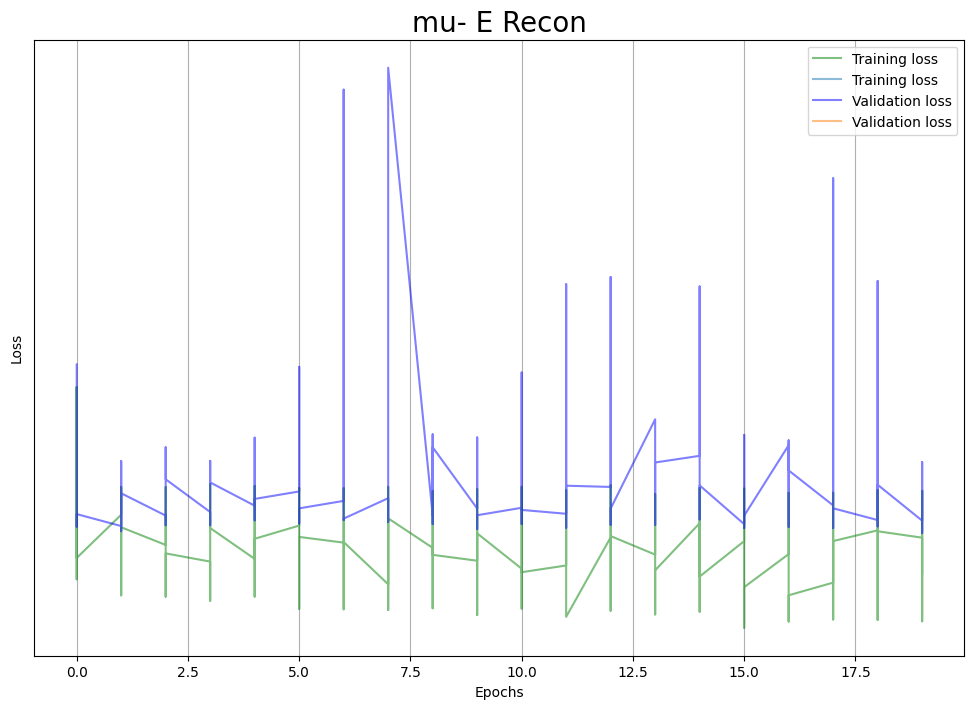

In [72]:
disp_reg_hist(pointnet_reg_loc[0], title='mu- E Recon', show=True, train_num=0)

## Get fiTQun data from files

Note that the loaded fq file contains 400 root files worth of events, this was from the previous train:test:validation ratio of 5:4:1. But the ratio we care about now is 7:1:2, so only 100 root files worth of fq processed events are needed. Luckily the events in the fq outputs are stored in order, so we can just take the first 3000*100 events.

In [45]:
# create dictionaries to fill with fitqun data for each particle type
fq_nsubevents = 0
flag_e = {}
flag_mu = {}
flag_pi0 = {}
reco_mom_e = {}
reco_mom_mu = {}
reco_pos_e = {}
reco_dir_e = {}
reco_pos_mu = {}
reco_dir_mu = {}
particles = {}
totq = {}

In [46]:
# get the data from the fitqun files
fq_path = "/project/rpp-blairt2k/machine_learning/data/HKHybrid/fiTQun/"
for p in particle_names:
    # open the fiTQun TTree from the file with uproot
    fq = uproot.open(fq_path+f"HKHybrid_{p}_3000x400_wo_mPMT.fiTQun.root")['fiTQun']
    # extract each branch of the TTree fom the ROOT file into a numpy array, placed in the dictionaries
    flag_e[p] = np.array(fq['fq1rpcflg'].array()[:,0,1])
    flag_mu[p] = np.array(fq['fq1rpcflg'].array()[:,0,2])
    flag_pi0[p] = np.array(fq['fqpi0pcflg'].array()[:,0])
    reco_mom_e[p] = np.array(fq['fq1rmom'].array()[:,0,1])
    reco_mom_mu[p] = np.array(fq['fq1rmom'].array()[:,0,2])
    reco_pos_e[p] = np.array(fq['fq1rpos'].array()[:,0,1,:])
    reco_dir_e[p] = np.array(fq['fq1rdir'].array()[:,0,1,:])
    reco_pos_mu[p] = np.array(fq['fq1rpos'].array()[:,0,2,:])
    reco_dir_mu[p] = np.array(fq['fq1rdir'].array()[:,0,2,:])
    totq[p] = np.array(fq['fqtotq'].array()[:,0])
    # the labels are just 0, 1, 2, or 3 based on which particle it is, repeated for the number of events
    particles[p] = np.repeat(particle_names.index(p), fq.num_entries)

In [47]:
# create arrays stacking together the particles
# the order of the particles in the test set of the h5 file is [e-, mu-, gamma, pi0]
# particle_order = [particle_names[i] for i in h5_labels[::1200000]]
fq_flag_e = np.concatenate([flag_e[i] for i in particle_order])
fq_flag_mu = np.concatenate([flag_mu[i] for i in particle_order])
fq_flag_pi0 = np.concatenate([flag_pi0[i] for i in particle_order])
fq_reco_mom_e = np.concatenate([reco_mom_e[i] for i in particle_order])
fq_reco_mom_mu = np.concatenate([reco_mom_mu[i] for i in particle_order])
fq_reco_pos_e = np.concatenate([reco_pos_e[i] for i in particle_order])
fq_reco_dir_e = np.concatenate([reco_dir_e[i] for i in particle_order])
fq_reco_pos_mu = np.concatenate([reco_pos_mu[i] for i in particle_order])
fq_reco_dir_mu = np.concatenate([reco_dir_mu[i] for i in particle_order])
fq_particles = np.concatenate([particles[i] for i in particle_order])
fq_totq = np.concatenate([totq[i] for i in particle_order])

# Function allowing you to choose which truth variable to plot against
You can choose from true momentum, true x, y, z location, true to_wall, true dwall, and true angles. The world is your oyster

In [14]:
def plot_against_true_variable(true_values, predicted_values, kinematic_var, recon_type='energies',
                               model_labels=None, plotting_true_name='momentum', plotting_range=[0,1000], 
                               bin_width=50, title=None, particle_name=particle_names[0]):
    '''
    Plot the Root Mean Square Error (RMSE) of residuals against true variable values to evaluate energy 
    resolution for multiple sets of predictions.

    Parameters
    ----------
    true_values :  2D array_like
        2D array of true values of momenta or position.
    predicted_values : 2D array_like
        2D array where each row is an array of predicted values for the given variable, 
        outputted from different tools like ML algorithms or fitqun.
    kinematic_var : array_like
        Array of true values used in plotting as the x axis.
    recon_type : str, optional
        Reconstructed varible type, for different methods of residual calulations
    model_labels : list of str, optional
        List of labels corresponding to each set of predicted values. For example, ['PointNet', 'FiTQun'].
    plotting_true_name : str, optional
        Name of the true variable being plotted, for labeling the x-axis.
    true_value_range : list, optional
        Two-element list specifying the minimum and maximum range for the true values.
    bin_width : int, optional
        Width of the bins in the same units as the true values.

    Returns
    -------
    None
    '''
    predicted_values = np.asarray(predicted_values)
#     true_values = np.asarray(true_values)
    
    # Check if predicted_values is 2D, if not, make it 2D
#     if true_values.ndim == 1:
#         true_values = true_values[np.newaxis, :]
    if predicted_values.ndim == 1:
        predicted_values = predicted_values[np.newaxis, :]
        
    # Check if labels are provided, if not, create default labels
    if model_labels is None:
        model_labels = [f'Set {i+1}' for i in range(len(predicted_values))]
    # Define a colormap
    cmap = cm.get_cmap('viridis', len(predicted_values))


    # 2. Split events into bins based on true momentum (the naming of things are a bit sloppy, the energies 
    # we're dealing with in this notebook are actually momentums)
    
    # ==================================================
    # Iterate over possible bin widths to find the one that minimizes the RMSE
#     possible_bin_widths = np.arange(5, 305, 20)  # Let's check bin widths from 5 to 100 MeV
#     optimal_bin_width = possible_bin_widths[0]
#     min_rmse = float('inf')

#     for bin_width in possible_bin_widths:
#         _, rmse_list = calculate_rmse_for_bin_width(bin_width, plotting_range, true_values, predicted_values)
#         mean_rmse = np.mean(rmse_list)
#         print(bin_width, mean_rmse)
#         if mean_rmse < min_rmse:
#             min_rmse = mean_rmse
#             optimal_bin_width = bin_width

#     print(f"Optimal bin width: {optimal_bin_width} MeV with an average RMSE of: {min_rmse}")

#     # Use the optimal bin width to calculate the RMSE again
#     bin_edges, rmse_values = calculate_rmse_for_bin_width(optimal_bin_width, plotting_range, true_values, predicted_values)
#     bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
#     print(bin_edges, bin_centers)
    # ==================================================
    
    # Calculate the center of each bin for plotting
    bin_edges = np.arange(plotting_range[0], plotting_range[1] + bin_width, bin_width)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_indices = np.digitize(kinematic_var, bins=bin_edges)

    plt.clf()
    uniform_plotting(plotting_true_name)
    
    # For plotting the content of each bin
    hist_content = [[] for _ in range(len(predicted_values))]
    means = [[] for _ in range(len(predicted_values))]
    stds = [[] for _ in range(len(predicted_values))]
    perc_68_values_list = [[] for _ in range(len(predicted_values))]
    
    # Loop over each set of predicted values
    for idx, (single_predicted_values, label) in enumerate(zip(predicted_values, model_labels)):
        # Calculate the residuals
        if recon_type == 'energies':
            residuals = 100 * (single_predicted_values - true_values) / true_values
        elif recon_type == 'positions':
            residuals = (single_predicted_values - true_values)
        else:
            raise ValueError("recon_type can only be energies or positions!")

        # Initialize an array to hold the RMSE for each bin
        rmse_values = np.zeros(len(bin_edges) - 1)
        perc_68_values = np.zeros(len(bin_edges) - 1)

        stde_list = []
        # Calculate RMSE for each bin
        for i in range(1, len(bin_edges)):
            bin_residuals = residuals[bin_indices == i]
            hist_content[idx].append(bin_residuals)
            
            # Plot individual residual distribution in each bin
            mean, std = plot_residual_dist_bin_by_bin(bin_residuals, i, bin_centers[i-1], recon_type)
            means[idx].append(mean)
            stds[idx].append(std)
            
            # Use stde of the distribution per bin as the statistical error
            stde_list.append(std/np.sqrt(len(bin_residuals)))

            rmse = np.sqrt(np.sum(bin_residuals**2) / len(bin_residuals)) if len(bin_residuals) > 0 else 0
            rmse_values[i - 1] = rmse
            
            abs_residuals = np.abs(bin_residuals)
            perc_68 = np.percentile(abs_residuals, 68) if len(bin_residuals) > 0 else 0
            perc_68_values[i - 1] = perc_68

        # extract resolution values for later plotting
        perc_68_values_list.append(perc_68_values)
        
        # Plot RMSE vs true variable
        color = cmap(idx)
        xerr = [bin_width/2 for _ in range(len(bin_centers))]
        plt.errorbar(bin_centers, perc_68_values, xerr=xerr, yerr=stde_list, marker='o', label=label)
#         plt.yscale('log')
#         plt.ylim(0,10)

    plt.legend(fontsize=14)
    if recon_type == 'energies':
#         plt.ylabel(f'RMSE', fontsize=18)
        plt.ylabel(f'Momentum Resolution (%)', fontsize=18)
#         plt.savefig(f'plots/{particle_name}_EResolution_68percentile/\
# {particle_name}_EResolution_68percentile_normalised_vs_{plotting_true_name.replace(" ","_")}_261MeVorMore.png') # mu: 261MeVorMore
    elif recon_type == 'positions':
#         plt.ylabel(f'RMSE (cm)', fontsize=18)
        plt.ylabel(f'{title} Position Resolution (cm)', fontsize=18)
        plt.savefig(f'plots/{particle_name}_posResolution_68percentile/\
{particle_name}_{title}Resolution_68percentile_vs_{plotting_true_name.replace(" ","_")}.png') #_100MeVorMore
    
    plt.show()
    
    return [hist_content, bin_centers, means, stds]


In [15]:
def uniform_plotting(name):
    '''
    This function aims to unifomise the plots plotted
    '''
    fig, ax = plt.subplots(figsize=(12,8))
        
    if name in ['momentum', 'energy']:
        plt.xlabel('True Momentum (MeV/c)', fontsize=18)
    elif name in ['x', 'y', 'z']:
        plt.xlabel(f'True {name} Position (cm)', fontsize=18)
    elif name == 'towall':
        plt.xlabel('towall (cm)', fontsize=18)
    elif name == 'dwall':
        plt.xlabel('dwall (cm)', fontsize=18)
    elif name in ['Cosine of Zenith']:
        plt.xlabel(f'True {name}', fontsize=18)
    elif name in ['Angle', 'Azimuth', 'Zenith']:
        plt.xlabel(f'True {name} (rad)', fontsize=18)
    else:
        plt.xlabel(name, fontsize=18)  # Assuming 'name' was meant to be 'plotting_true_name'

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)

In [16]:
def plot_residual_dist_bin_by_bin(residuals, bin_no, bin_centre, recon_type):
    mean = round(np.mean(residuals), 2)
    std_dev = round(np.std(residuals), 2)
#     fig, ax = plt.subplots(figsize=(12,8))
#     plt.hist(residuals, bins=100, histtype='step')
#     # Add a line for the mean
#     plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean = {mean}')
#     # Add lines for one standard deviation on either side of the mean
#     plt.axvline(mean - std_dev, color='g', linestyle='dashed', linewidth=2, label=f'Std. Dev. = {std_dev}')
#     plt.axvline(mean + std_dev, color='g', linestyle='dashed', linewidth=2)
#     if recon_type == 'energies':
#         plt.xlabel('Residual (Recon/True - 1)', fontsize=18)
#         plt.legend(title=f'Bin Centre at {bin_centre} MeV', fontsize=14, title_fontsize=14)
#     elif recon_type == 'positions':
#         plt.xlabel('Residual (Recon - True)', fontsize=18)
#         plt.legend(title=f'Bin Centre at {bin_centre} cm', fontsize=14, title_fontsize=14)

#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
#     plt.xlim([-1000,1000])
#     plt.yscale('log')
#     plt.savefig(f'test.png')
    return mean, std_dev

In [17]:
def calculate_rmse_for_bin_width(bin_width, plotting_range, true_values, predicted_values):
    bin_edges = np.arange(plotting_range[0], plotting_range[1] + bin_width, bin_width)
    rmse_values = np.zeros(len(bin_edges)-1)  # Initialize with zeros or np.nan

    for i in range(len(bin_edges)-1):
        # Create a mask for the current bin
        bin_mask = (true_values >= bin_edges[i]) & (true_values < bin_edges[i+1])
        # Calculate RMSE only if there are values in the bin
        if np.sum(bin_mask) > 0:
            rmse_values[i] = np.sqrt(mean_squared_error(true_values[bin_mask], predicted_values[bin_mask]))
        else:
            rmse_values[i] = np.nan  # Assign NaN if no values in the bin

    return bin_edges, rmse_values

In [18]:
def plt_residual_in_each_bin(residuals, bin_centre, mean, std_dev, plotting_true_name):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.hist(residuals, bins=100, histtype='step')
    # Add a line for the mean
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean = {mean}')
    # Add lines for one standard deviation on either side of the mean
    plt.axvline(mean - std_dev, color='g', linestyle='dashed', linewidth=2, label=f'Std. Dev. = {std_dev}')
    plt.axvline(mean + std_dev, color='g', linestyle='dashed', linewidth=2)
    if plotting_true_name == 'momentum':
        plt.xlabel('Residual (Recon/True - 1)', fontsize=18)
        plt.legend(title=f'Bin Centre at {bin_centre} MeV', fontsize=14, title_fontsize=14)
    else:
        plt.xlabel('Residual (Recon - True)', fontsize=18)
        plt.legend(title=f'Bin Centre at {bin_centre} cm', fontsize=14, title_fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
#     plt.xlim([-1000,1000])
    plt.yscale('log')
#     plt.savefig(f'test.png')

# Energy (It's acutally momentum, the naming is a bit sloppy)

### First apply cut to get rid of empty events

NameError: name 'true_energy_541' is not defined

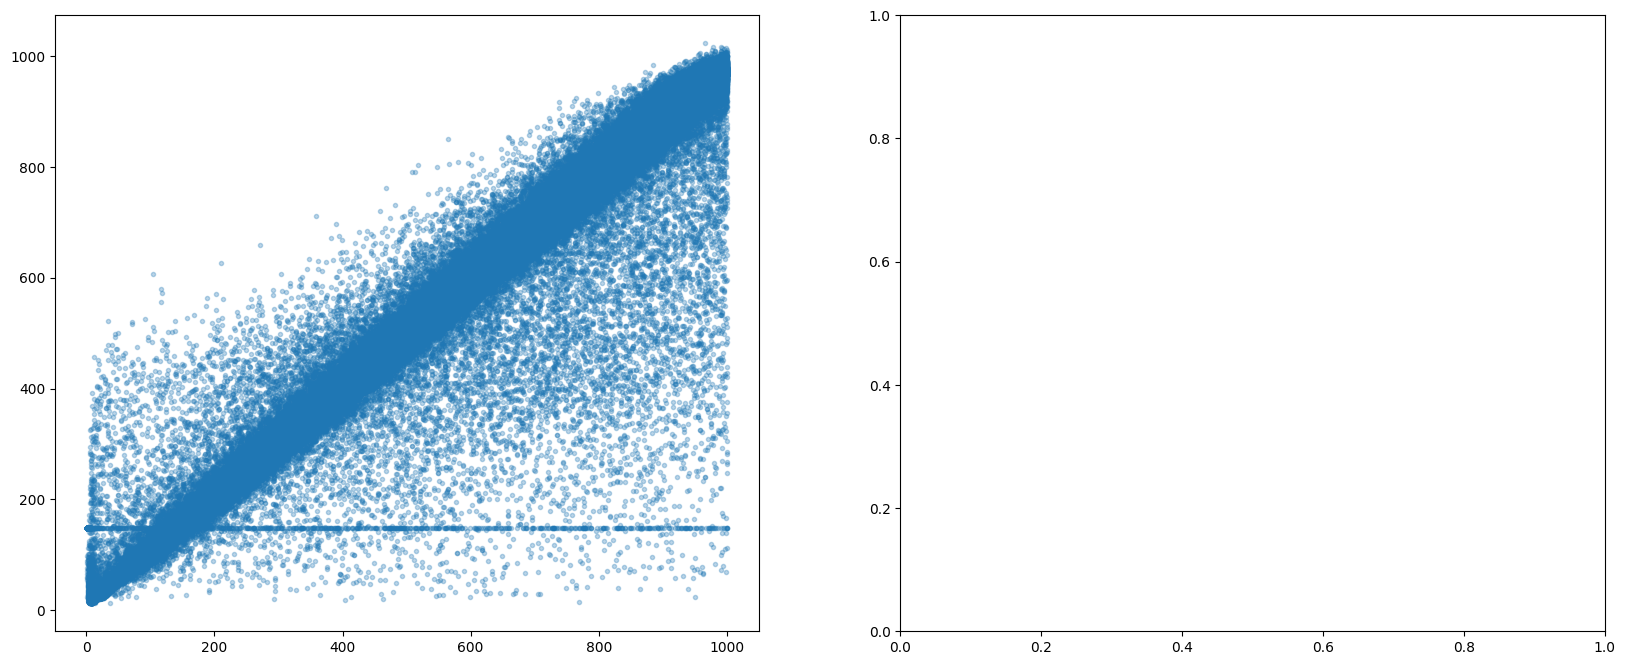

In [21]:
fig, axs = plt.subplots(1,2, figsize=(20,8))

axs[0].plot(true_energies[0], recon_energies[0], ".", color=c[0], alpha=0.3, label='PointNet, 30k events, TVT=7:2:1')
axs[1].plot(true_energy_541[:300000], recon_energy_541[:300000], ".", color=c[3], alpha=0.3, 
            label='PointNet, 30k events, TVT=5:1:4')
for i in range(2):
    axs[i].set_xlabel("True Momentum (MeV)", fontsize=18)
    axs[i].set_ylabel("Recon Momentum (MeV)", fontsize=18)
    axs[i].tick_params(which='both', labelsize=14)
    axs[i].set_xlim([0.,1010.])
    axs[i].set_ylim([0.,1010.])
    axs[i].legend(fontsize=14)
plt.savefig(f'plots/{particle_names[0]}_E_recon_vs_true_two_partitions.png')


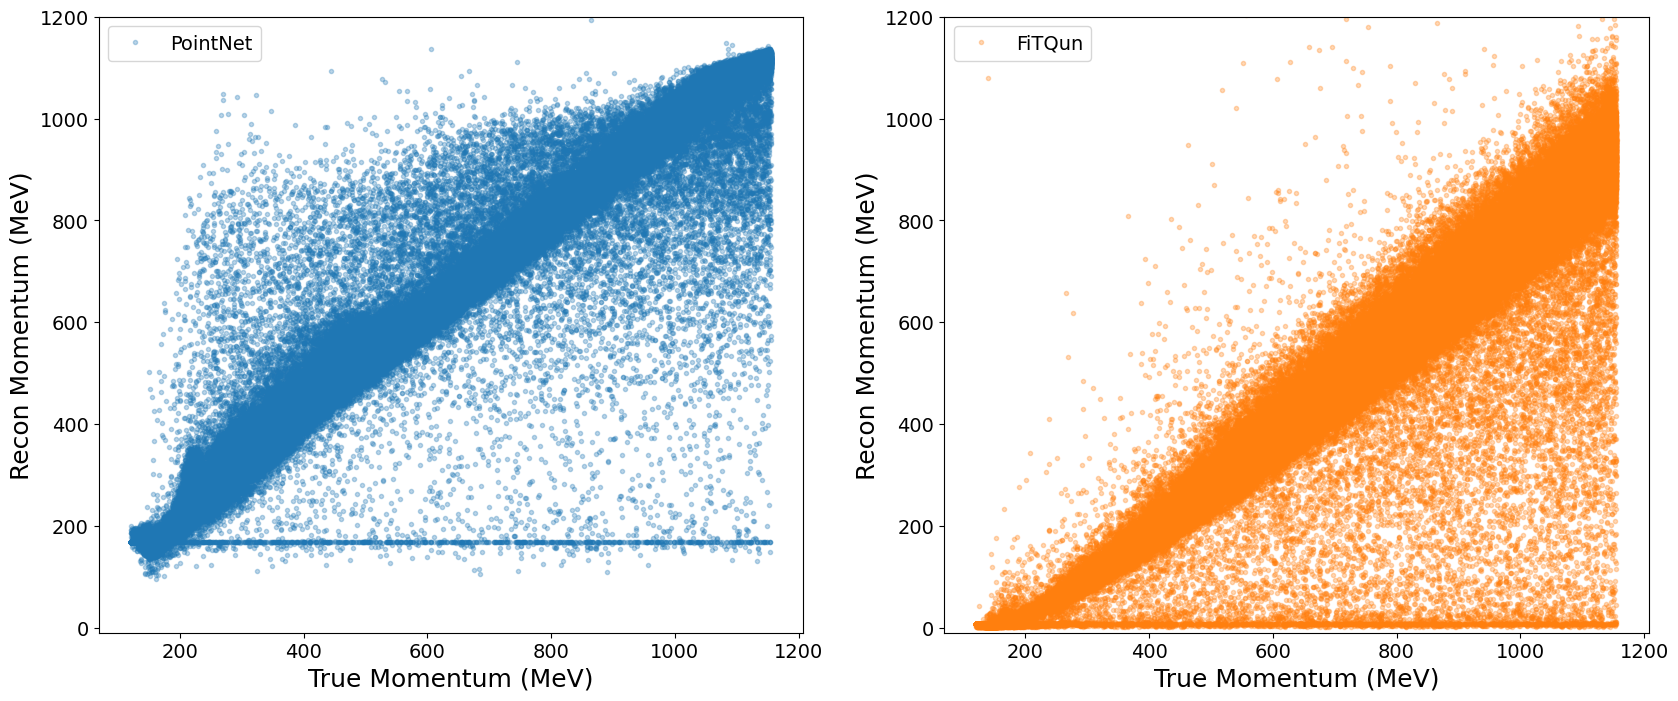

In [58]:
true_momentum = ev.momentum(h5_energies, h5_labels)
ml_momentum = ev.momentum(recon_energies[0], h5_labels)

fig, axs = plt.subplots(1,2, figsize=(20,8))
axs[0].plot(true_momentum, ml_momentum, ".", alpha=0.3, label='PointNet')
axs[1].plot(true_momentum, fq_reco_mom_e[:300000], ".", color=c[1], alpha=0.3, label='FiTQun')
for i in range(2):
    axs[i].set_xlabel("True Momentum (MeV)", fontsize=18)
    axs[i].set_ylabel("Recon Momentum (MeV)", fontsize=18)
    axs[i].tick_params(which='both', labelsize=14)
#     axs[i].set_xlim([100.,1200.])
    axs[i].set_ylim([-10.,1200.])
    axs[i].legend(fontsize=14)
plt.savefig(f'plots/{particle_names[0]}_EResolution_68percentile/{particle_names[0]}_E_recon_vs_true.png')
# plt.ylim([198.6664,198.6668])  # weird mu E line
# plt.xlim(149.36, 149.3605) # e- E location of where the weird line occurs

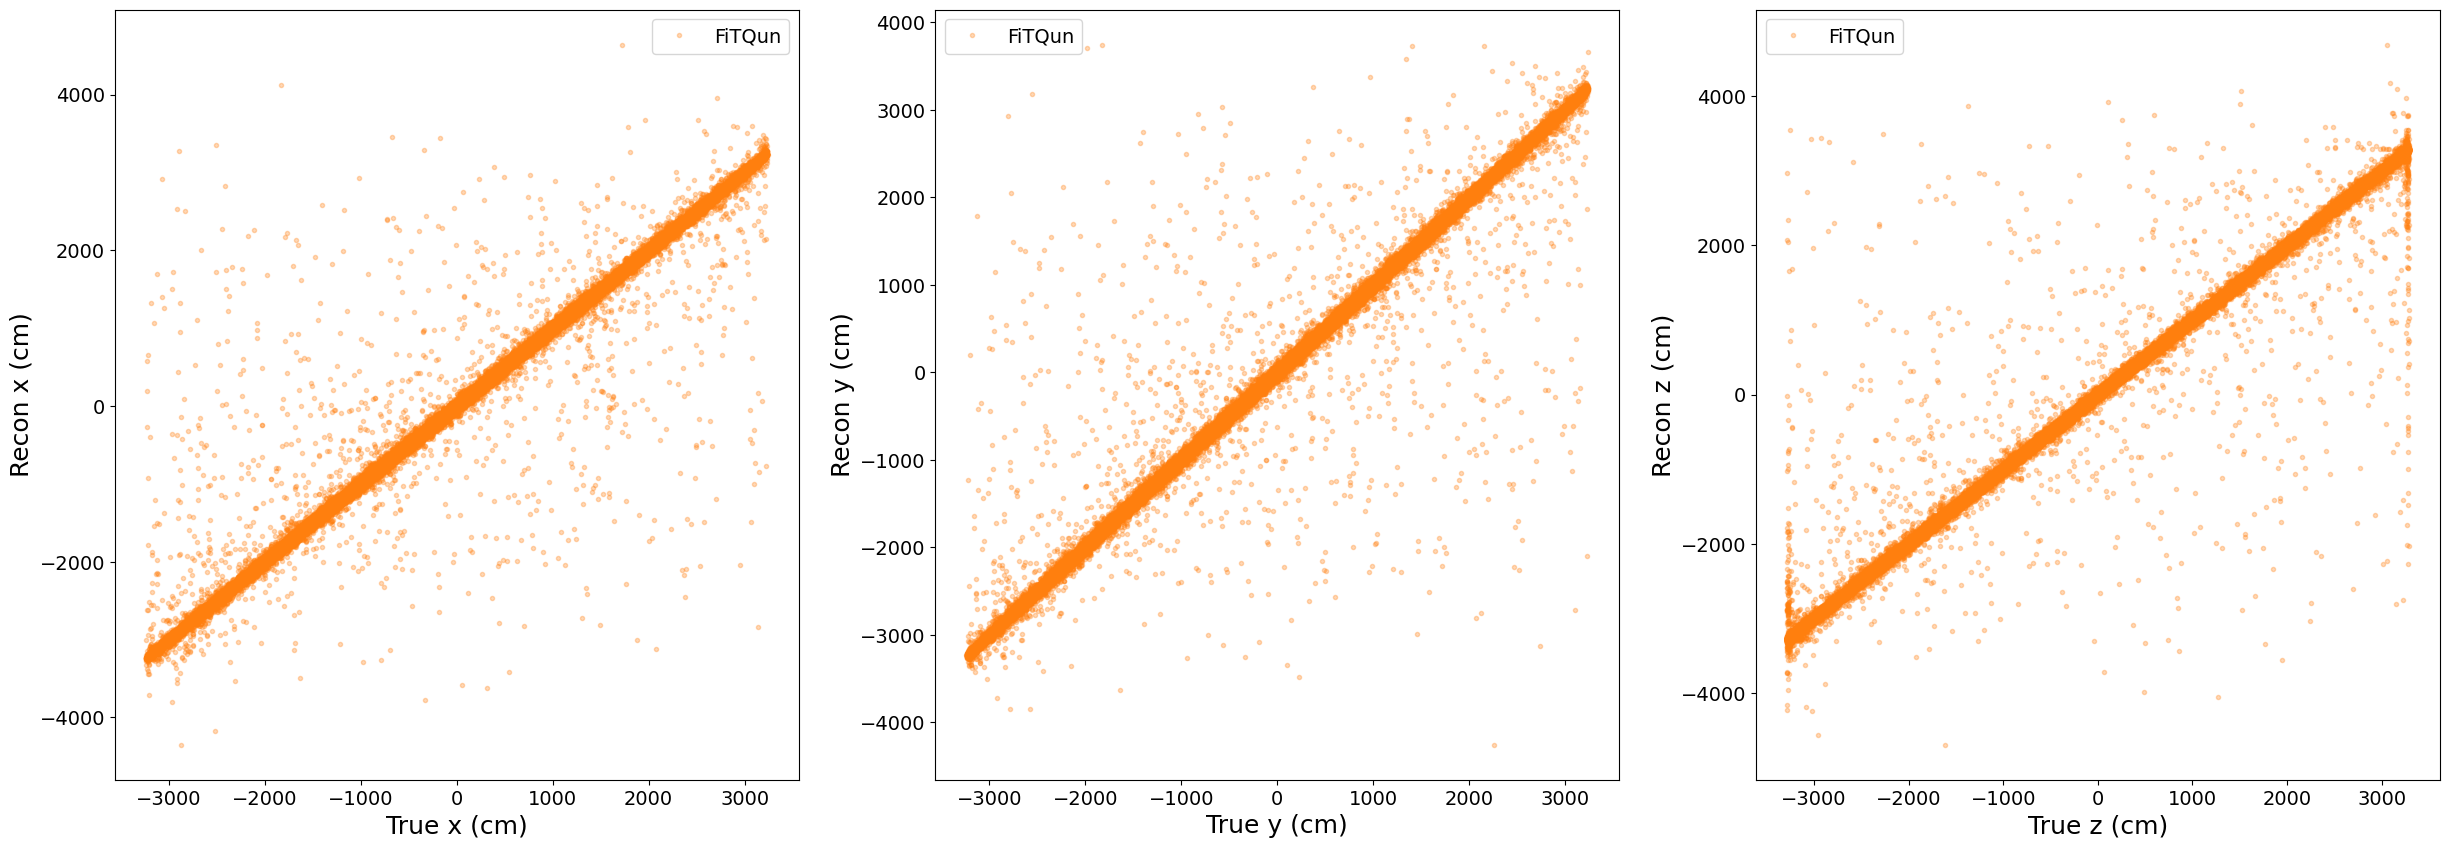

In [115]:
xlabels=['x', 'y', 'z']
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i in range(3):
    axs[i].plot(h5_positions[good_events1][:,i], fq_reco_pos_e[:3000*100][good_events1][:,i], ".", color=c[1], alpha=0.3, label='FiTQun')

    axs[i].set_xlabel(f"True {xlabels[i]} (cm)", fontsize=18)
    axs[i].set_ylabel(f"Recon {xlabels[i]} (cm)", fontsize=18)

#     axs[i].set_ylim([-3600, 3600])
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    axs[i].legend(fontsize=14)
    
    plt.savefig(f'plots/{particle_names[0]}_EResolution_68percentile/\
        {particle_names[0]}_fitqun_pos_recon_vs_true_afterCuts.png')
# plt.ylim(149.36, 149.3605) # location of where the weird line occurs (E energy)
# plt.ylim([48.164,48.17]) # location of where the weird line occurs (x)

In [48]:
# Cuts out empty events
if particle_names[0] == 'e-':
    bad_events    = np.where((recon_energies[0] > 149.36) & (recon_energies[0] < 149.3605))[0]
#     bad_events    = np.where((recon_energies[0] > 184.196) & (recon_energies[0] < 184.198))[0] # 541
    good_events0   = np.delete(range(len(true_energies[0])), bad_events)

    fq_reco_pos_e          = fq_reco_pos_e[:3000*100]
    good_fq_recon_pos      = fq_reco_pos_e[good_events0]
    fq_bad_events = np.where((good_fq_recon_pos[:,0] < -5000) | (good_fq_recon_pos[:,0] > 5000) |
                             (good_fq_recon_pos[:,1] < -5000) | (good_fq_recon_pos[:,1] > 5000) |
                             (good_fq_recon_pos[:,2] < -5000) | (good_fq_recon_pos[:,2] > 5000))[0]
    good_events1   = np.delete(good_events0, fq_bad_events)
elif particle_names[0] == 'mu-':
    bad_events    = np.where((recon_energies[0] > 198.6664) & (recon_energies[0] < 198.6668))[0]
    good_events0   = np.delete(range(len(true_energies[0])), bad_events)
    print(len(bad_events))
    fq_reco_pos_mu          = fq_reco_pos_mu[:3000*100]
    good_fq_recon_pos      = fq_reco_pos_mu[good_events0]
    fq_bad_events = np.where((good_fq_recon_pos[:,0] < -5000) | (good_fq_recon_pos[:,0] > 5000) |
                             (good_fq_recon_pos[:,1] < -5000) | (good_fq_recon_pos[:,1] > 5000) |
                             (good_fq_recon_pos[:,2] < -5000) | (good_fq_recon_pos[:,2] > 5000))[0]
    good_events1   = np.delete(good_events0, fq_bad_events)
    print(len(fq_bad_events))

good_true_energies     = h5_energies[good_events1]
good_ml_recon_energies = recon_energies[0][good_events1]
good_positions         = h5_positions[good_events1]
good_angles            = h5_angles[good_events1]
good_vetos             = h5_vetos[good_events1]
good_labels            = h5_labels[good_events1]

if particle_names[0] == 'e-':
    good_fq_recon_energies = fq_reco_mom_e[good_events1]
elif particle_names[0] == 'mu-':
    good_fq_recon_energies = fq_reco_mom_mu[good_events1]
    
good_true_momentum = ev.momentum(good_true_energies, good_labels)
good_ml_momentum = ev.momentum(good_ml_recon_energies, good_labels)

5956
69


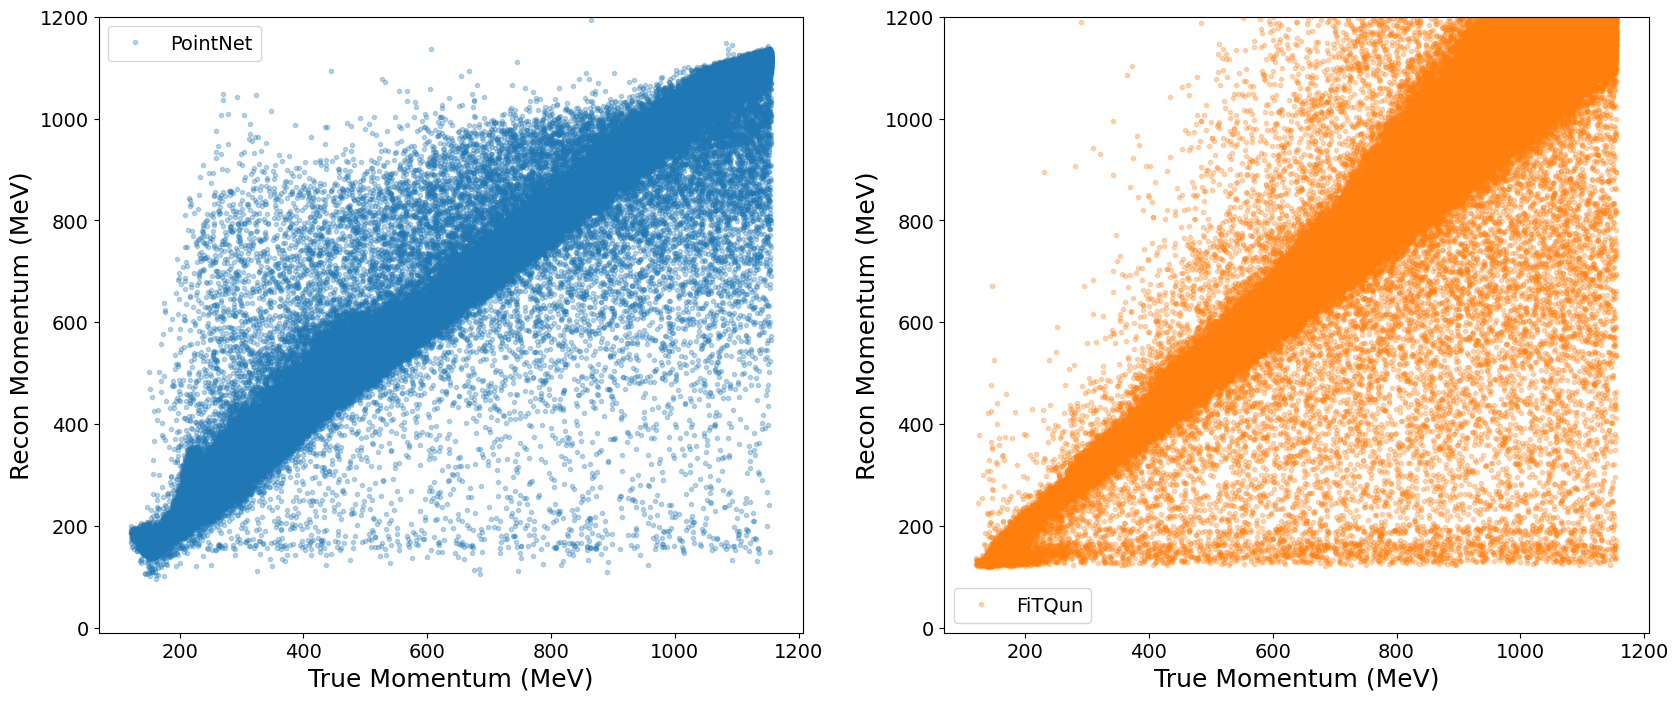

In [49]:
fig, axs = plt.subplots(1,2, figsize=(20,8))
axs[0].plot(good_true_momentum, good_ml_momentum, ".", alpha=0.3, label='PointNet')
axs[1].plot(good_true_momentum, good_fq_recon_energies, ".", color=c[1], alpha=0.3, label='FiTQun')
for i in range(2):
    axs[i].set_xlabel("True Momentum (MeV)", fontsize=18)
    axs[i].set_ylabel("Recon Momentum (MeV)", fontsize=18)
    axs[i].tick_params(which='both', labelsize=14)
    axs[i].set_ylim([-10.,1200.])
    axs[i].legend(fontsize=14)
plt.savefig(f'plots/{particle_names[0]}_EResolution_68percentile/{particle_names[0]}_E_recon_vs_true_afternCuts.png')
# plt.xlim(149.36, 149.3605) # e- E location of where the weird line occurs

# Energy resolution as a function of true variables

In [72]:
recon_energy_541 = recon_energies[0]
true_energy_541 = true_energies[0]

In [88]:
len(true_energies[0])

1

<Figure size 640x480 with 0 Axes>

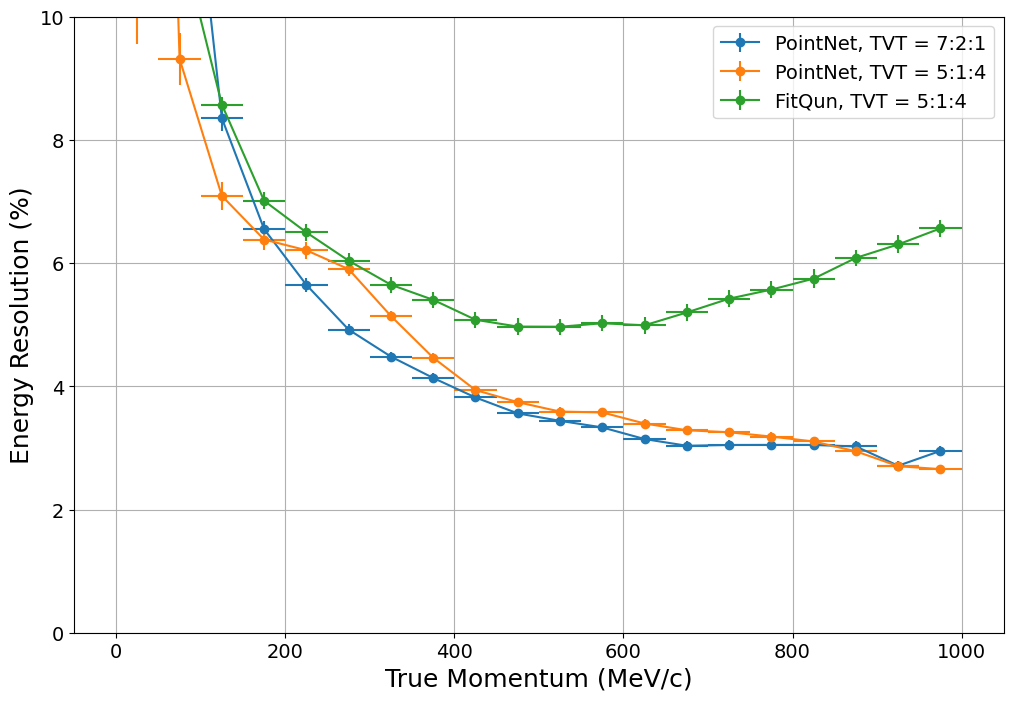

In [103]:
plot_against_true_variable([true_energies[0], true_energy_541[:300000], true_energies[0]],
                           [recon_energies[0], recon_energy_541[:300000], fq_reco_mom_e[:300000]],
                           true_energies[0], recon_type=recon_type, 
                           model_labels=['PointNet, TVT = 7:2:1', 'PointNet, TVT = 5:1:4', 'FitQun, TVT = 5:1:4'])

/tmp/ipykernel_6332/1431064357.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predicted_values, true_values = np.asarray(predicted_values), np.asarray(true_values)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 298382

<Figure size 640x480 with 0 Axes>

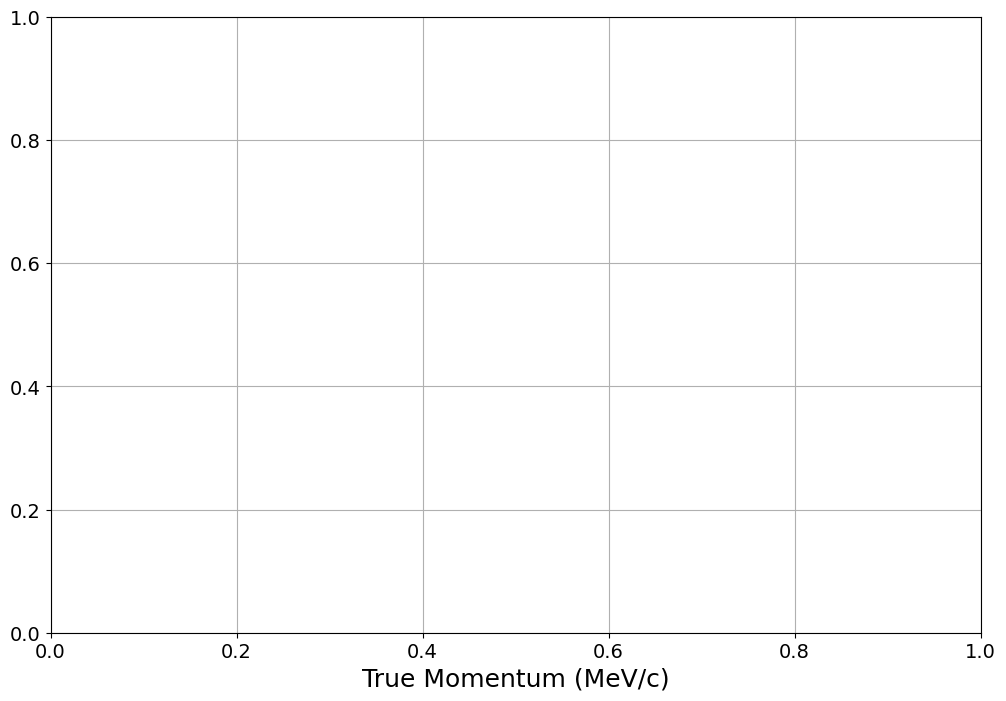

In [63]:
plot_against_true_variable(good_true_energies, [true_energy_541, good_fq_recon_energies],
                           good_true_energies, recon_type=recon_type, model_labels=['PointNet', 'FiTQun'],
                           plotting_range=[161., 1161.]) # for muon plotting

<Figure size 640x480 with 0 Axes>

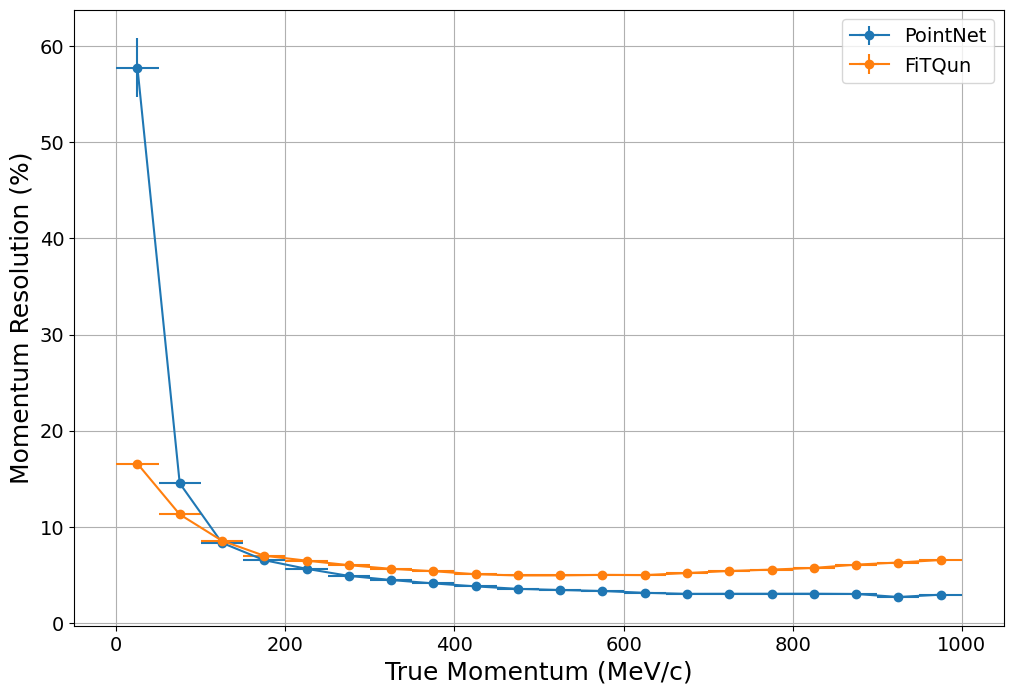

In [20]:
# As a function of true mom
plotting_essentials = plot_against_true_variable(good_true_momentum, [good_ml_momentum, good_fq_recon_energies],
                           good_true_energies, recon_type=recon_type, model_labels=['PointNet', 'FiTQun'])#,
#                            plotting_range=[161., 1161.]) # for muon plotting

### Against Various Vertex Positions

In [62]:
# making yet another cut because the PN sucks at reconstruting low energy stuff (<100MeV), and it skews the
# E resolution for all other true variables apart from true mom
if particle_names[0] == 'e-':
    lowe_event_idxs = np.where(h5_energies[good_events1] < 100)[0]
elif particle_names[0] == 'mu-':
    lowe_event_idxs = np.where(h5_energies[good_events1] < 261)[0] # the cherenkov threshold of mu is 160.26MeV

good_events2 = np.delete(good_events1, lowe_event_idxs)

good_true_energies     = h5_energies[good_events2]
good_ml_recon_energies = recon_energies[0][good_events2]
good_positions         = h5_positions[good_events2]
good_angles            = h5_angles[good_events2]
good_vetos             = h5_vetos[good_events2]
good_labels            = h5_labels[good_events2]

if particle_names[0] == 'e-':
    good_fq_recon_energies = fq_reco_mom_e[good_events2]
elif particle_names[0] == 'mu-':
    good_fq_recon_energies = fq_reco_mom_mu[good_events2]

In [63]:
# Producing more position related variables
# need to overwrite the tank_half_height and tank_radius parameters that towall and dwall funcs takes in
# The length unit is mm and the the lengths are the dimentions of the ID, so HK ID tank is 32.4m (?) in radius
# and 65.8 m (?) in height. Note the half height is 32.9 m.
towall = ev.towall(good_positions, good_angles, tank_half_height=3287, tank_radius=3240, tank_axis=2)
dwall = ev.dwall(good_positions, tank_half_height=3287, tank_radius=3240, tank_axis=2)
good_true_momentum = ev.momentum(good_true_energies, good_labels)
good_ml_momentum = ev.momentum(good_ml_recon_energies, good_labels)

<Figure size 640x480 with 0 Axes>

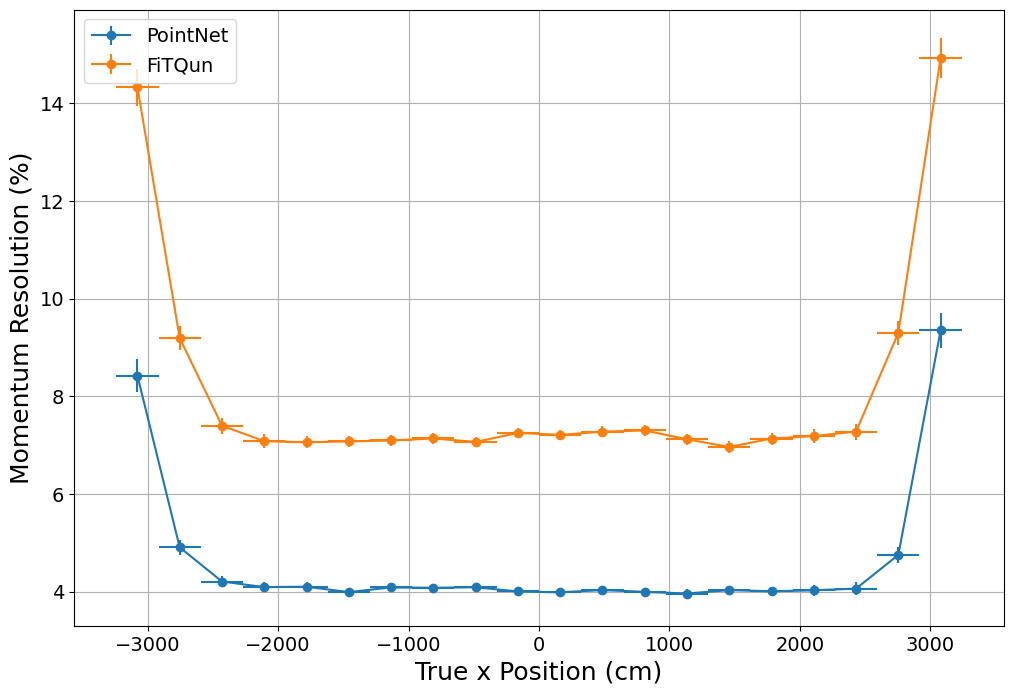

<Figure size 640x480 with 0 Axes>

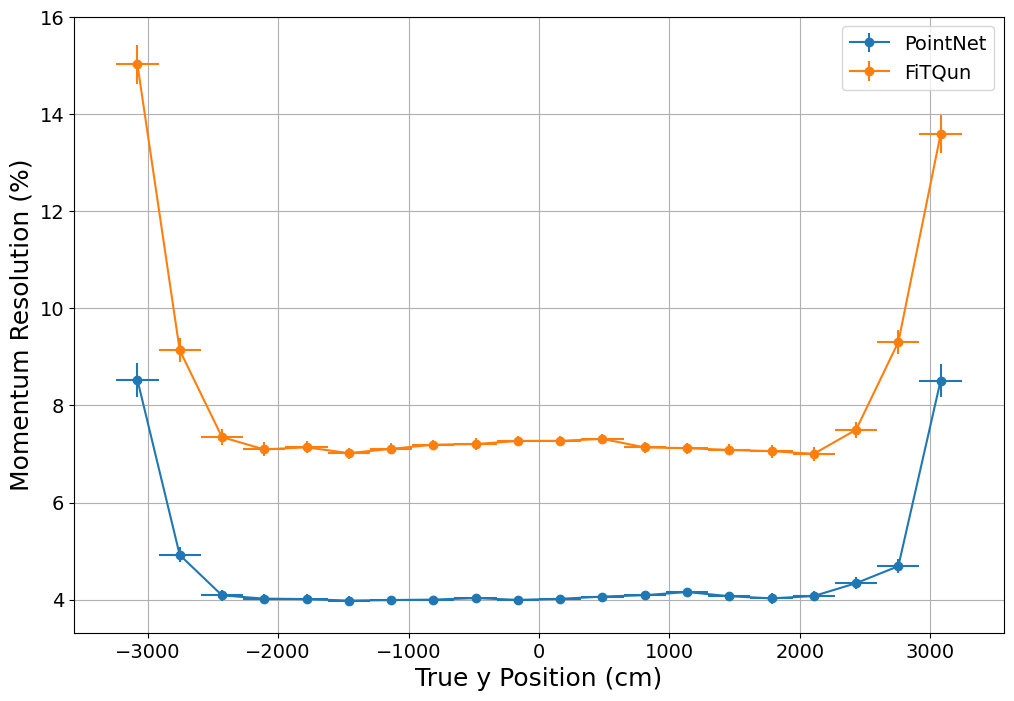

<Figure size 640x480 with 0 Axes>

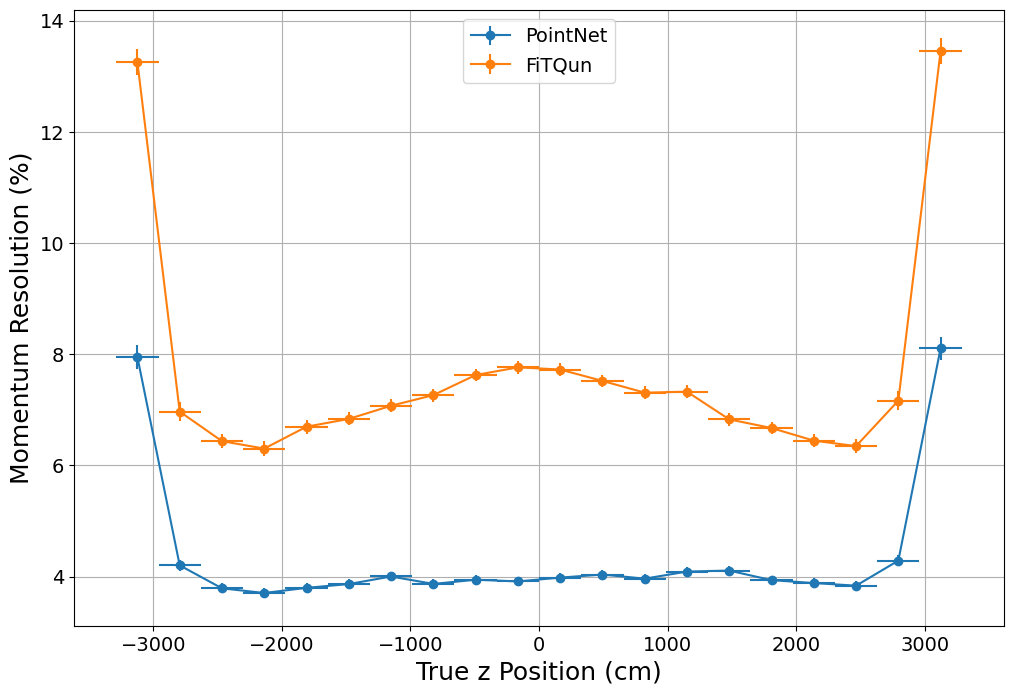

<Figure size 640x480 with 0 Axes>

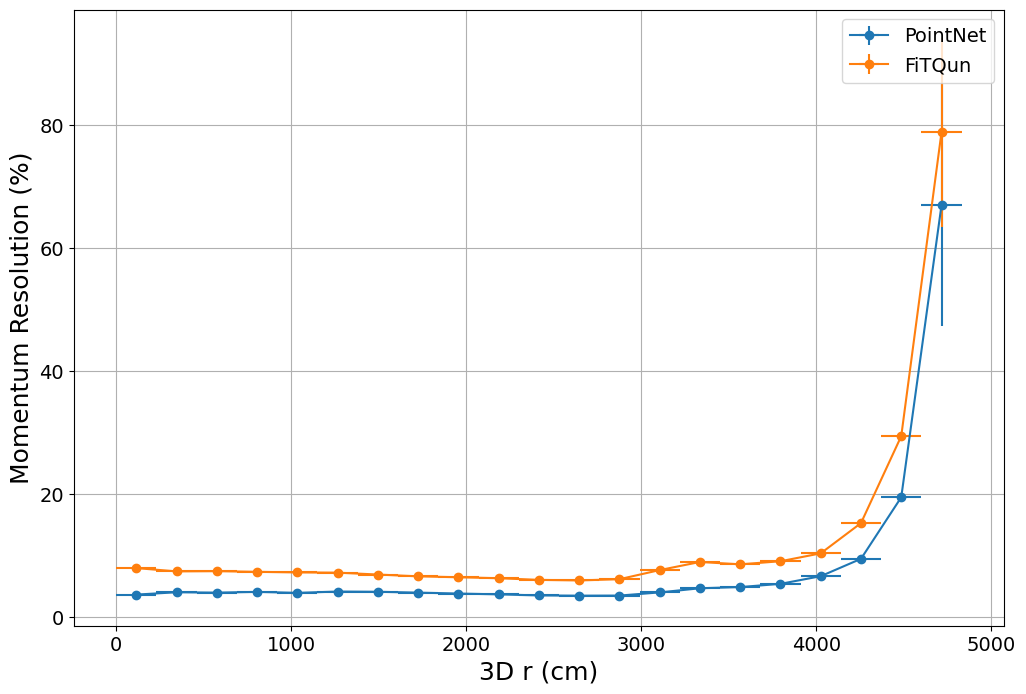

In [64]:
# As a function of x, y, z
# # x, bin width 324 cm -> 20 bins
plotting_essentials = plot_against_true_variable(good_true_momentum, [good_ml_momentum, good_fq_recon_energies], 
                           good_positions[:,0], 'energies', ['PointNet', 'FiTQun'], 'x', [-3240, 3240], 324)
# y, 20 bins
plot_against_true_variable(good_true_momentum, [good_ml_momentum, good_fq_recon_energies],
                           good_positions[:,1], recon_type, ['PointNet', 'FiTQun'], 'y', [-3240, 3240], 324)
# z, 20 bins
plot_against_true_variable(good_true_momentum, [good_ml_momentum, good_fq_recon_energies], 
                           good_positions[:,2], recon_type, ['PointNet', 'FiTQun'], 'z', [-3287, 3287], 328.7)

# The E resolution vs a single dim didn't look great. Trying to plot against r = sqrt(x^2+y^2+z^2)
r_3d = np.sqrt(good_positions[:,0]**2 + good_positions[:,1]**2 + good_positions[:,2]**2)
plot_against_true_variable(good_true_momentum, [good_ml_momentum, good_fq_recon_energies], r_3d, 
                           recon_type, ['PointNet', 'FiTQun'], '3D r (cm)', [0., round(max(r_3d),0)+1], 230.)


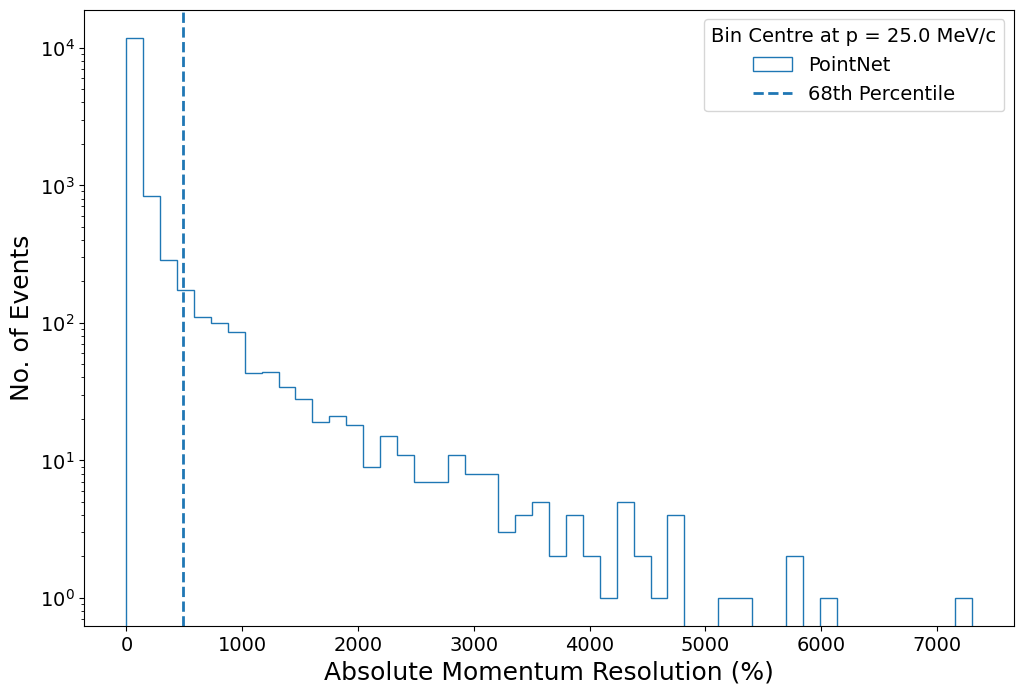

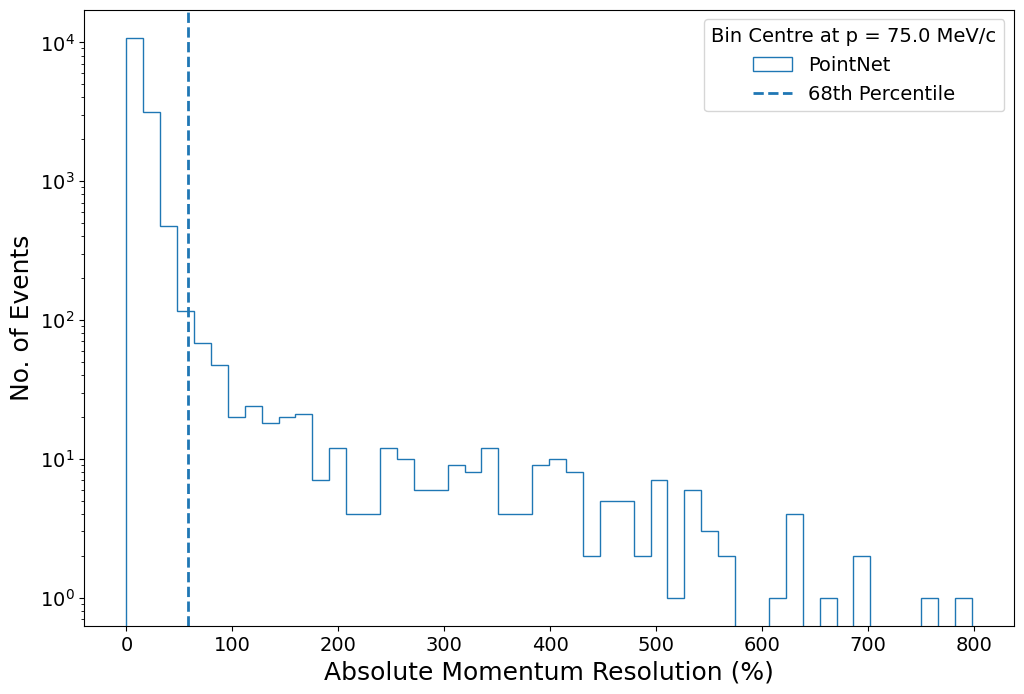

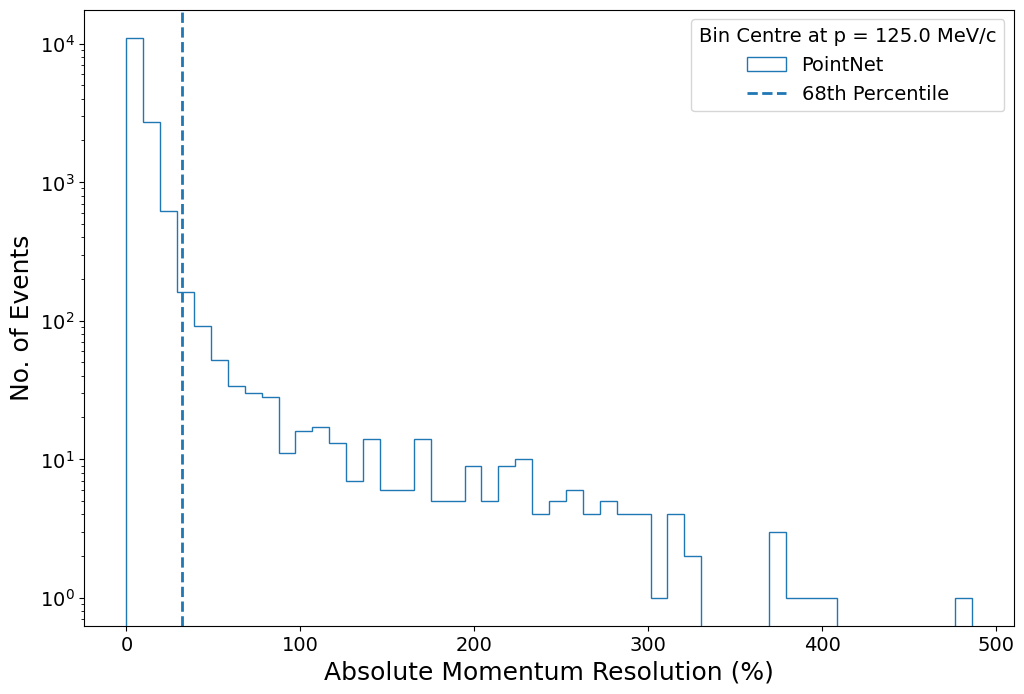

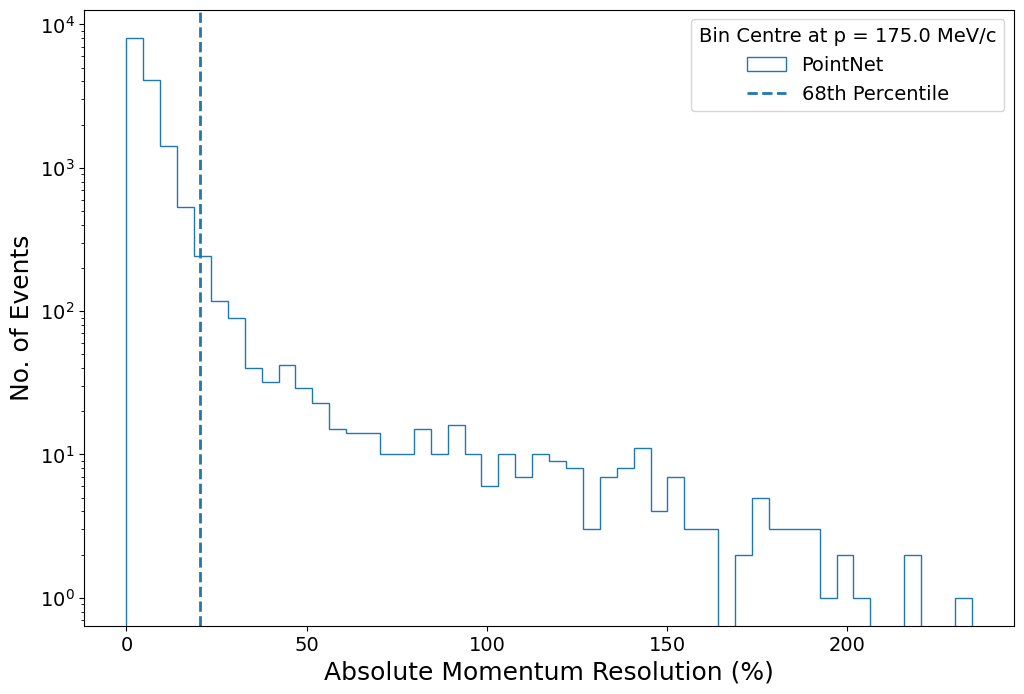

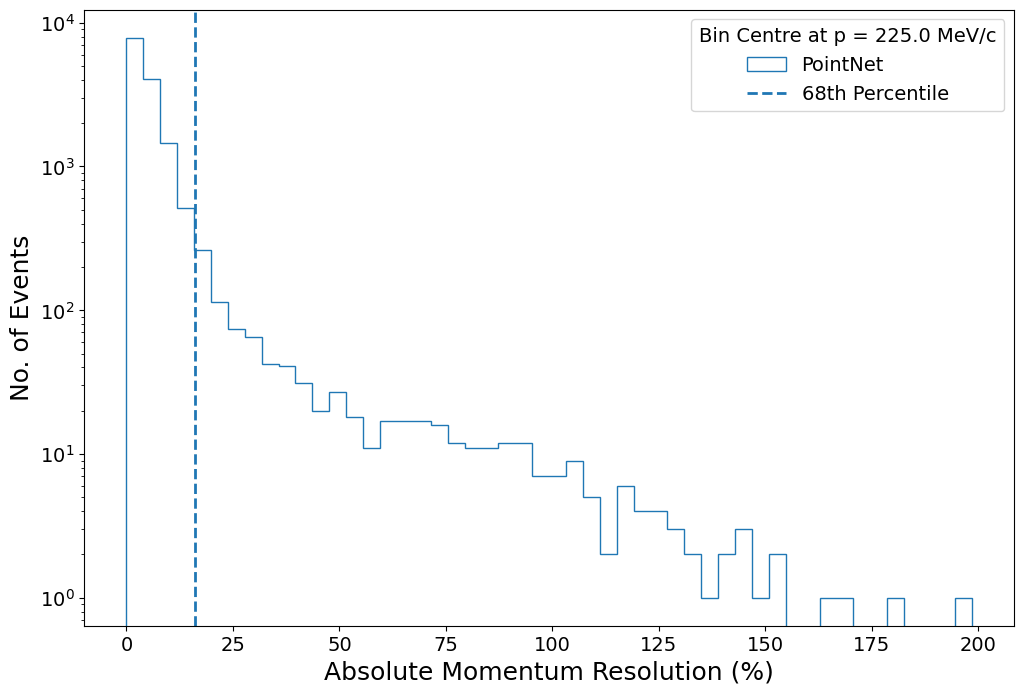

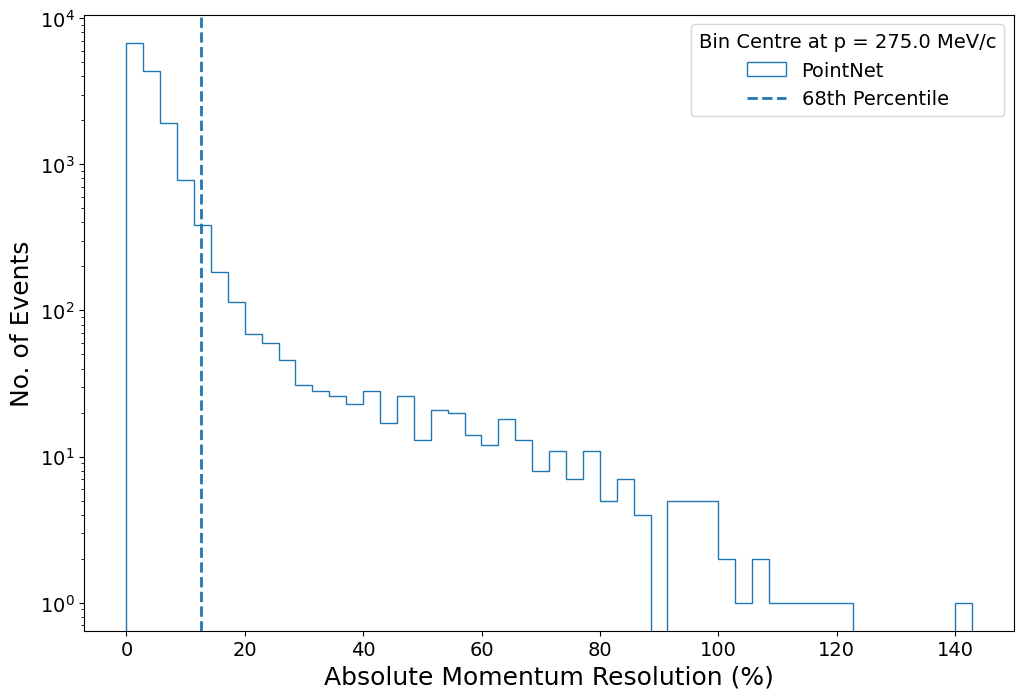

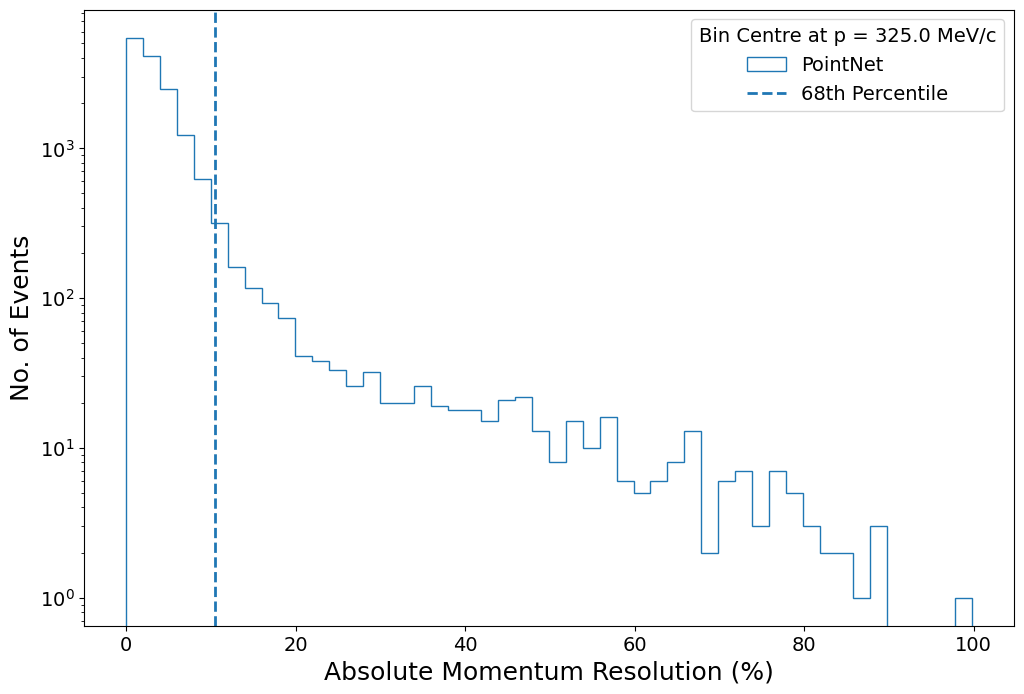

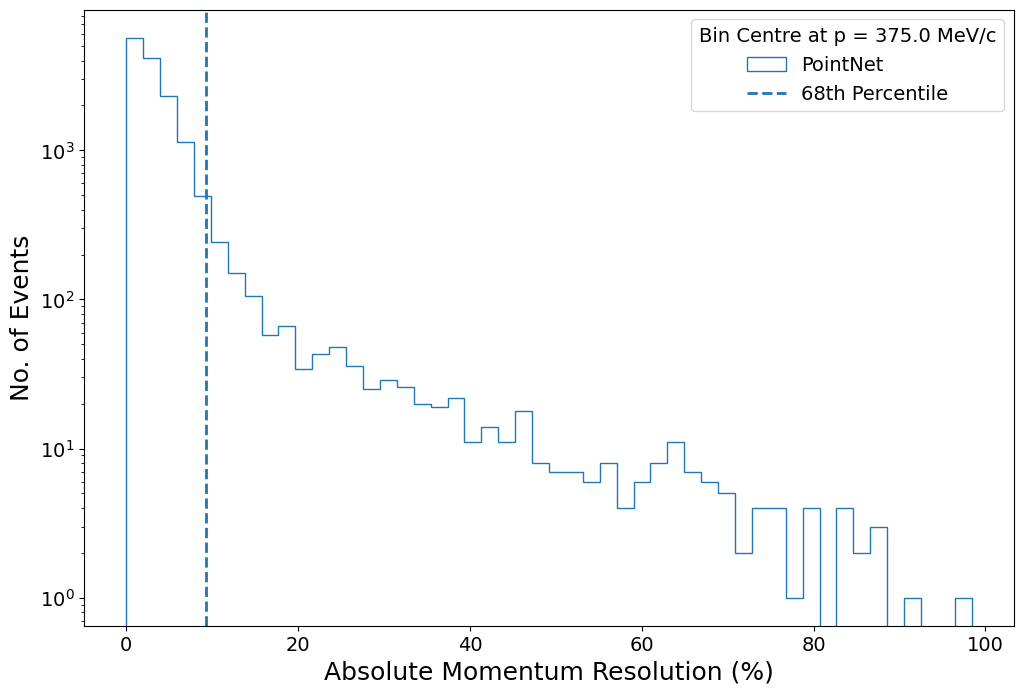

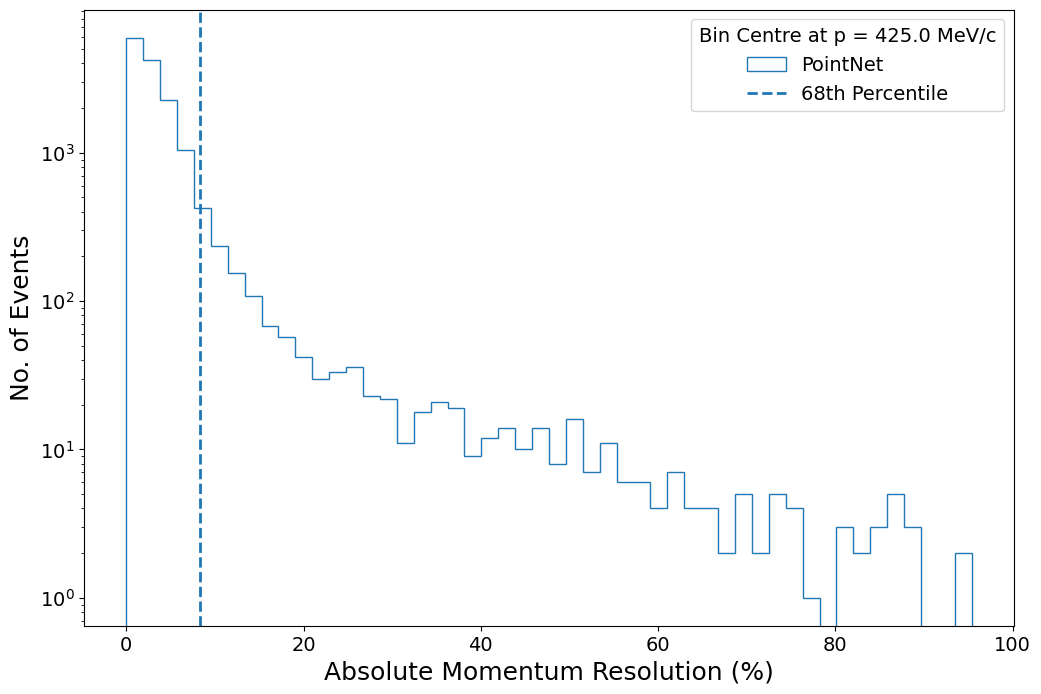

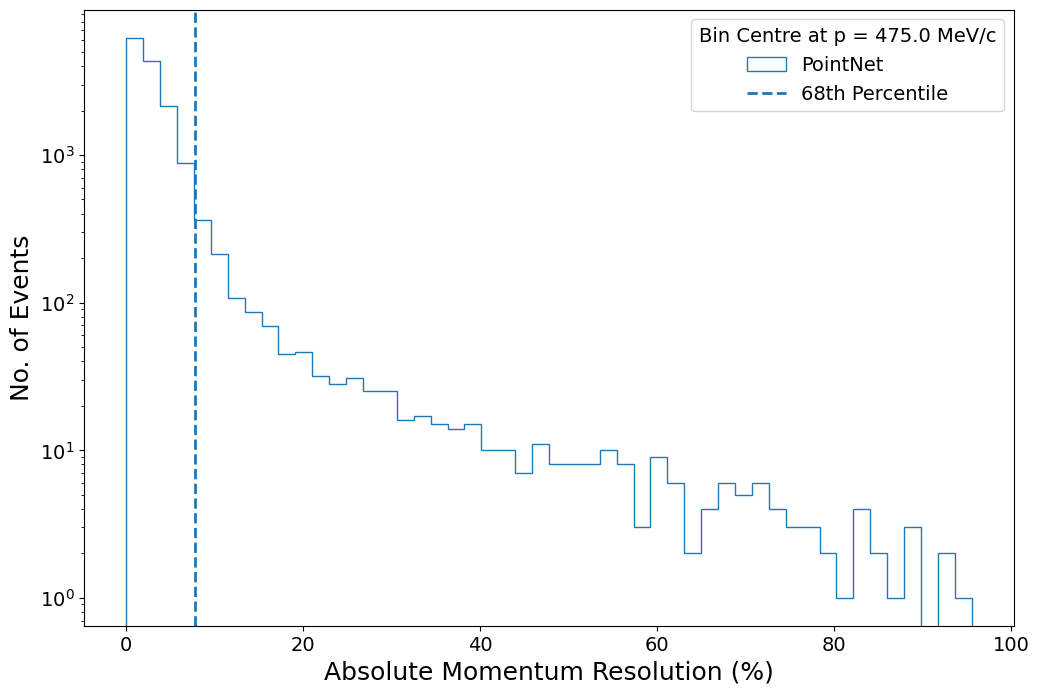

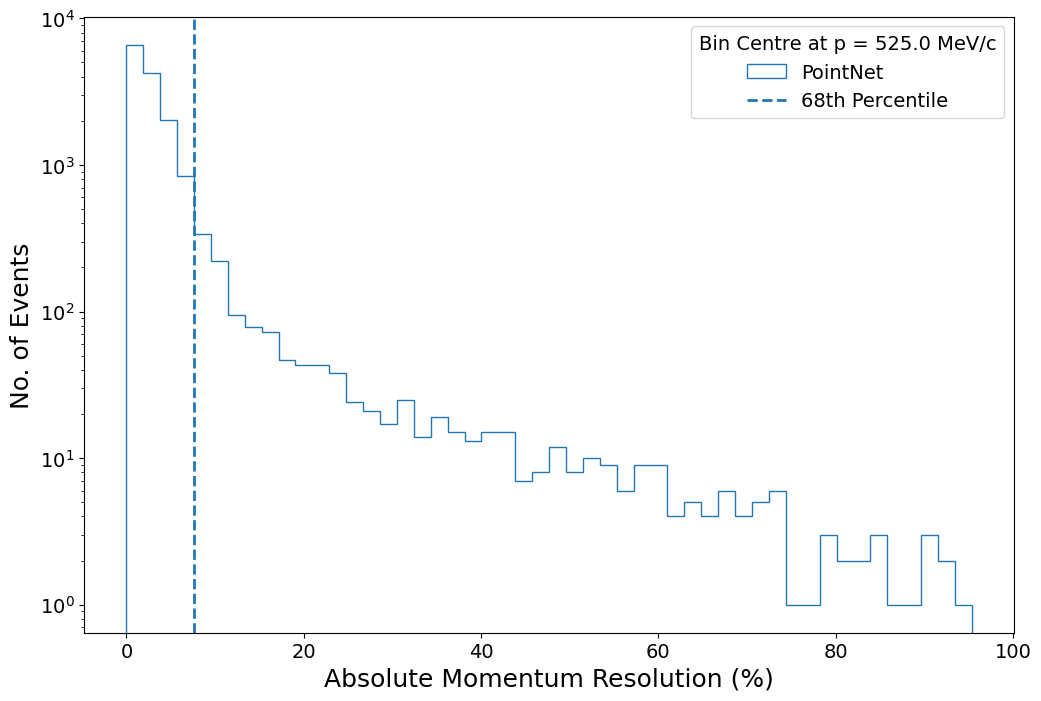

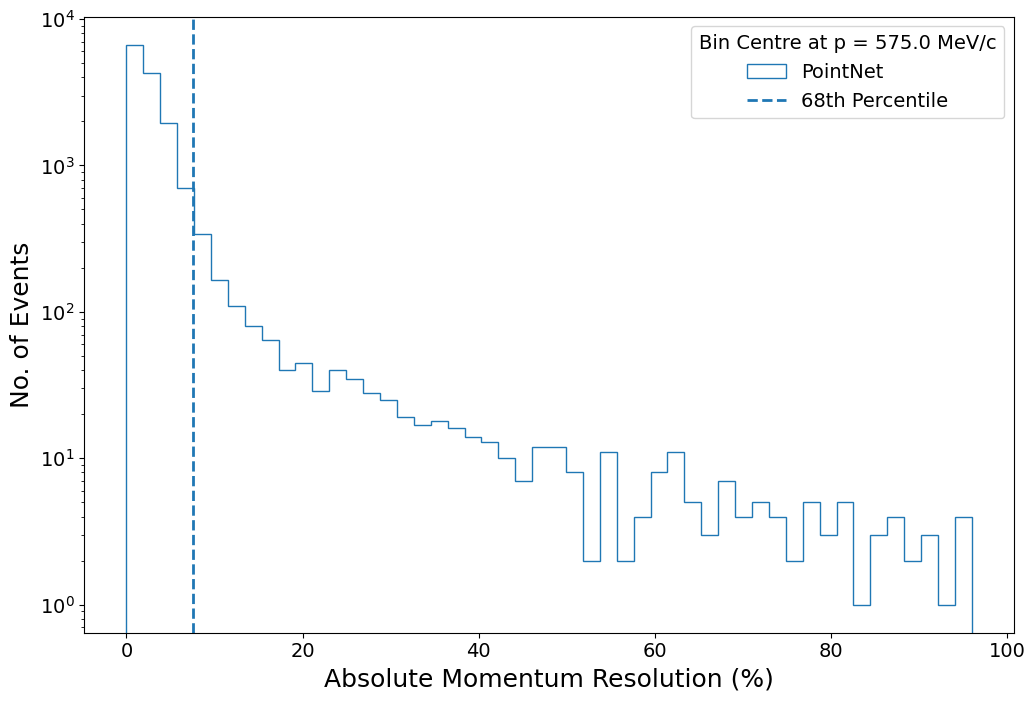

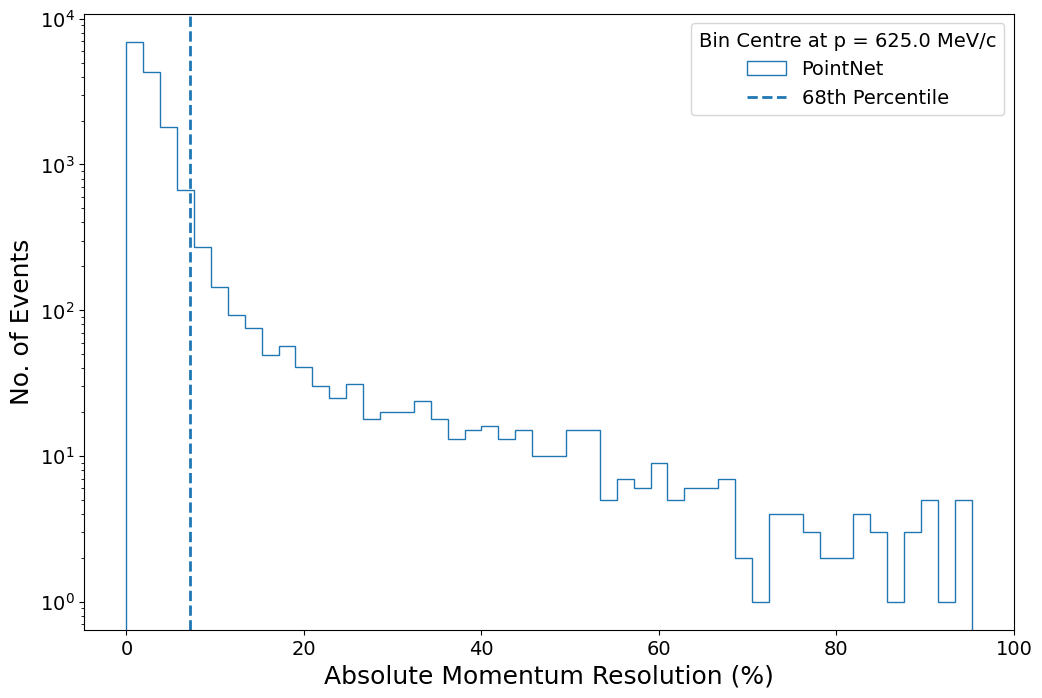

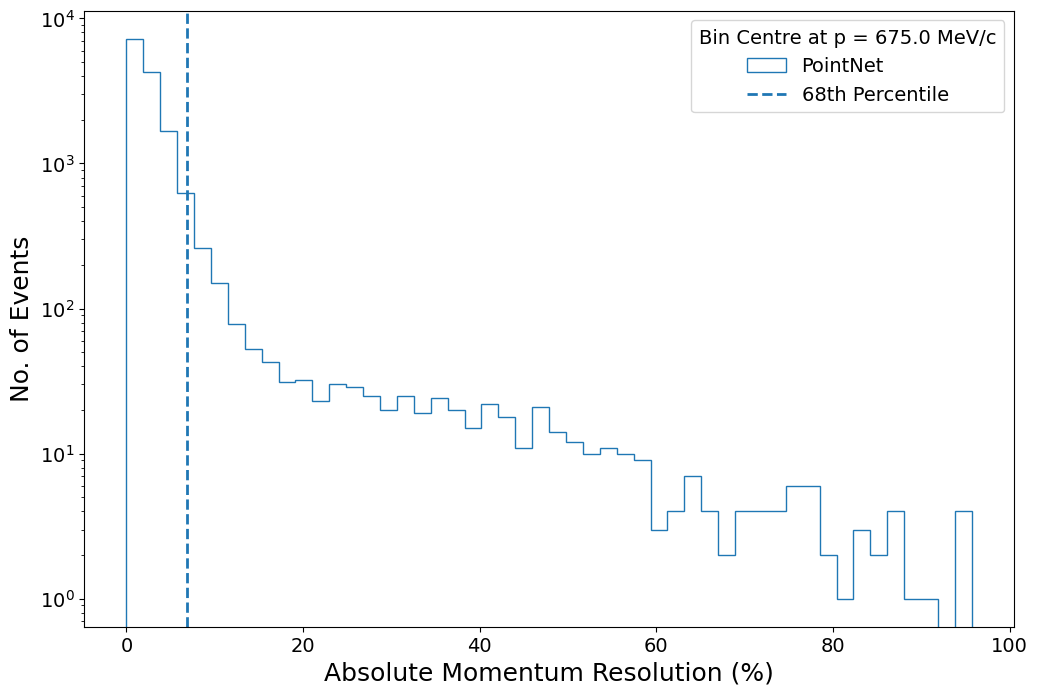

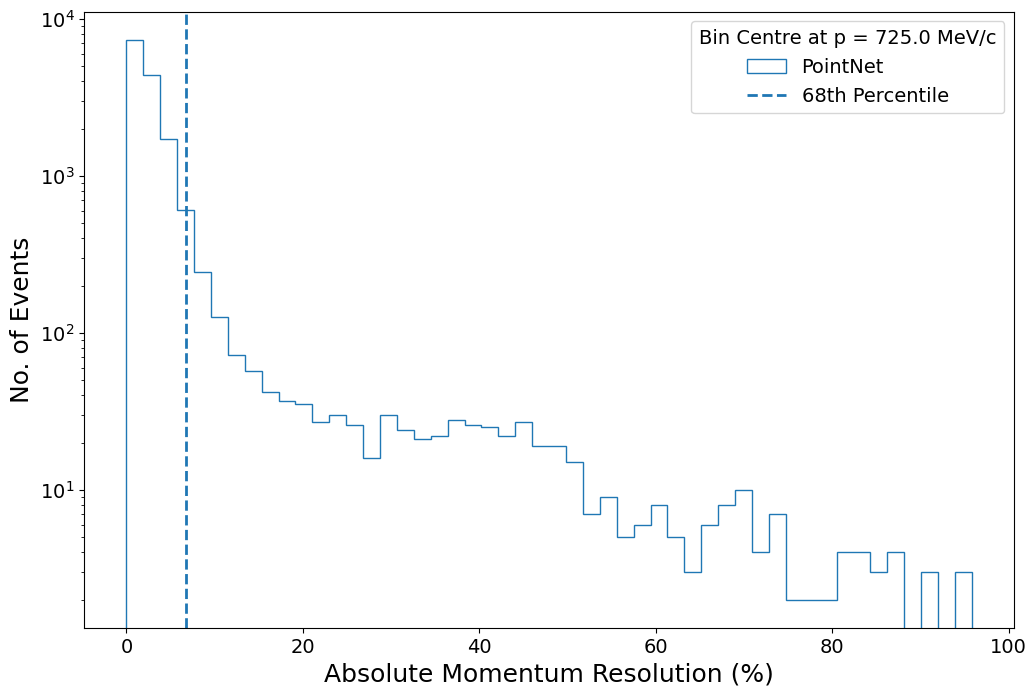

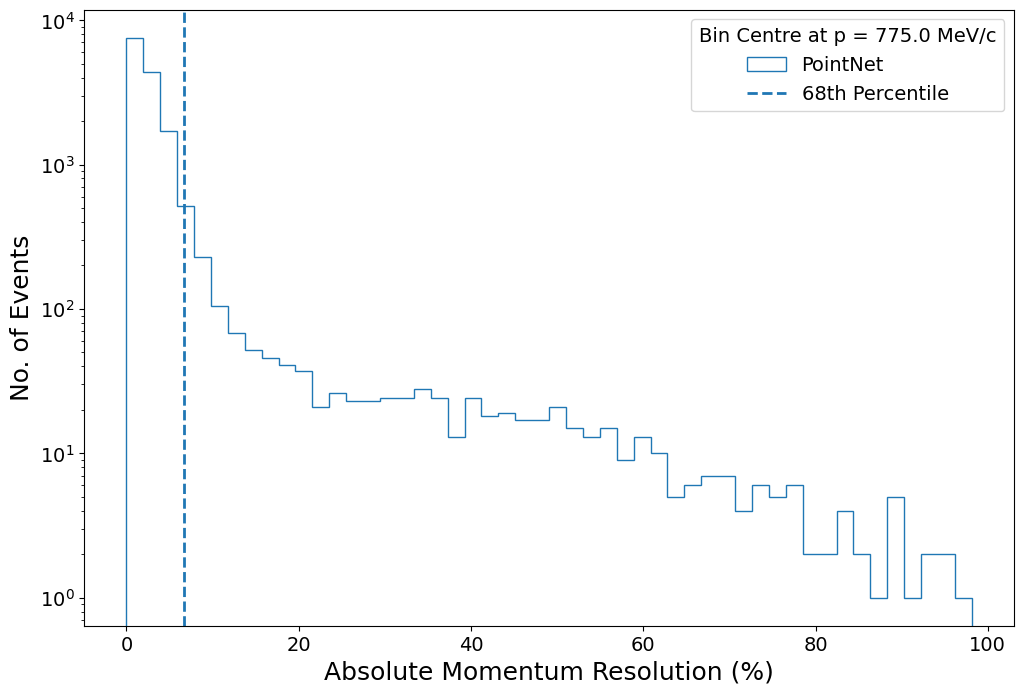

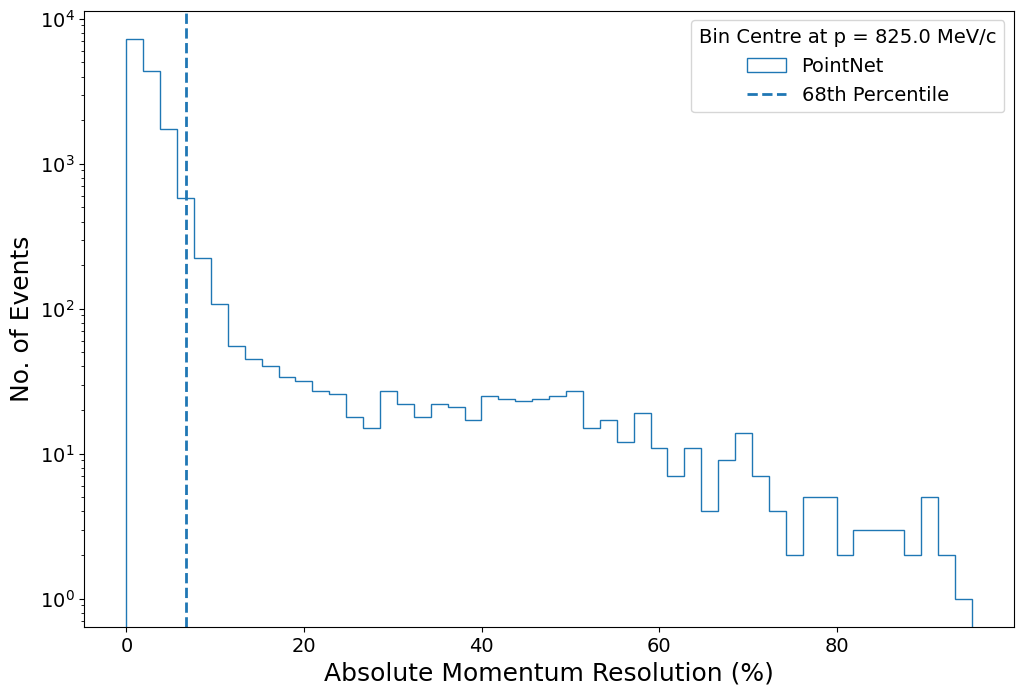

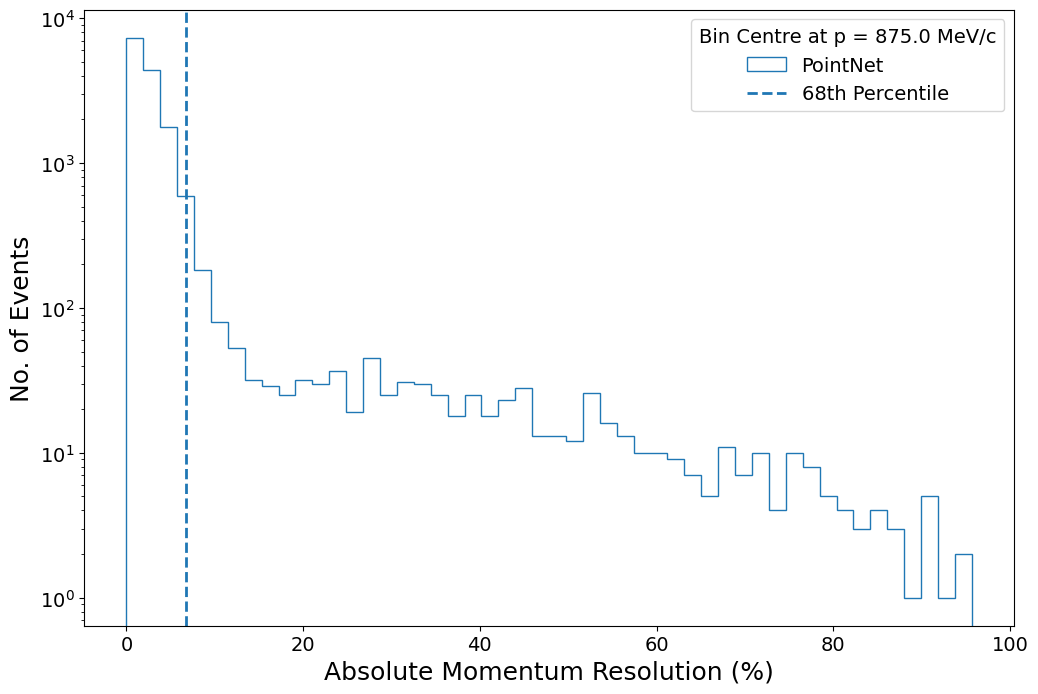

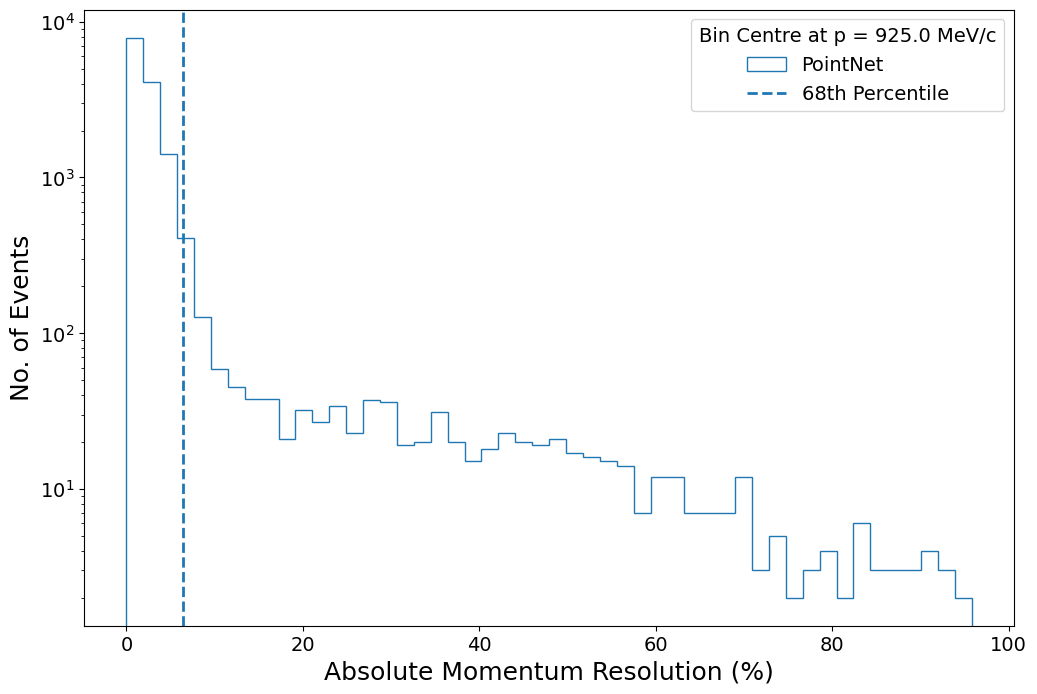

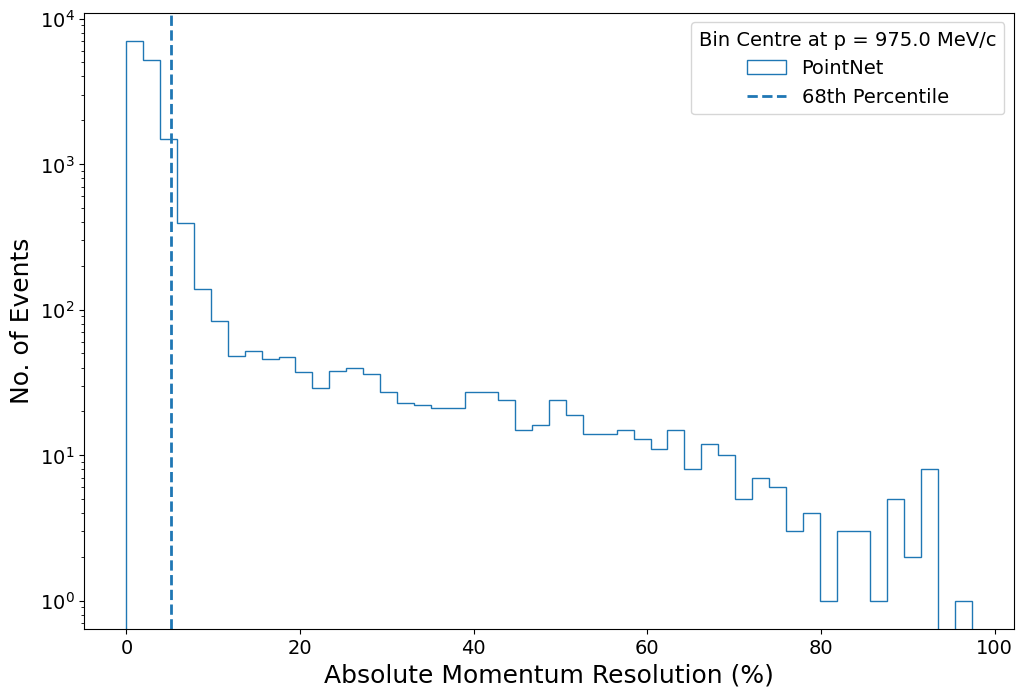

In [31]:
# For plotting out bin contents
hist_content, bin_centers, means, stds = plotting_essentials
for i in range(len(bin_centers)):
    # Define the bin width
    bin_width = 10

    hist_content[0][i] = abs(hist_content[0][i])
    hist_content[1][i] = abs(hist_content[1][i])
    
    # Determine the combined range
    min_bin = min(min(hist_content[0][i]), min(hist_content[1][i]))
    max_bin = max(max(hist_content[0][i]), max(hist_content[1][i]))

    # Ensure the max_bin is inclusive for the range
    max_bin += bin_width

    # Create bins
    bins = np.arange(min_bin, max_bin, bin_width)
    
    fig, ax = plt.subplots(figsize=(12,8))
    plt.hist(hist_content[0][i], bins=50, histtype='step', label='PointNet')
    # Add a line for the mean
#     plt.axvline(means[0][i], color='tab:blue', linestyle='-', linewidth=2, label=f'PN Mean = {means[0][i]}')
#     plt.axvline(means[0][i] - stds[0][i], color='tab:blue', linestyle='dashed', linewidth=2, label=f'PN Std. Dev. = {stds[0][i]}')
    plt.axvline(means[0][i] + stds[0][i], color='tab:blue', linestyle='dashed', linewidth=2, label=f'68th Percentile')
    
#     plt.hist(hist_content[1][i], bins=bins, histtype='step', label='FiTQun')
# #     plt.axvline(means[1][i], color='tab:orange', linestyle='-', linewidth=2, label=f'FQ Mean = {means[1][i]}')
# #     plt.axvline(means[1][i] - stds[1][i], color='tab:orange', linestyle='dashed', linewidth=2, label=f'FQ Std. Dev. = {stds[1][i]}')
#     plt.axvline(means[1][i] + stds[1][i], color='tab:orange', linestyle='dashed', linewidth=2, label=f'FQ 68th Percentile')
    
    plt.xlabel('Absolute Momentum Resolution (%)', fontsize=18)
    plt.ylabel('No. of Events', fontsize=18)
    plt.legend(title=f'Bin Centre at p = {bin_centers[i]} MeV/c', fontsize=14, title_fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.yscale('log')
#     plt.xlim(-10, 1000)
    plt.savefig(f'plots/e-_EResolution_68percentile/bin_by_bin_in_true_p/true_p_normalised_bin_{i}.png')

<Figure size 640x480 with 0 Axes>

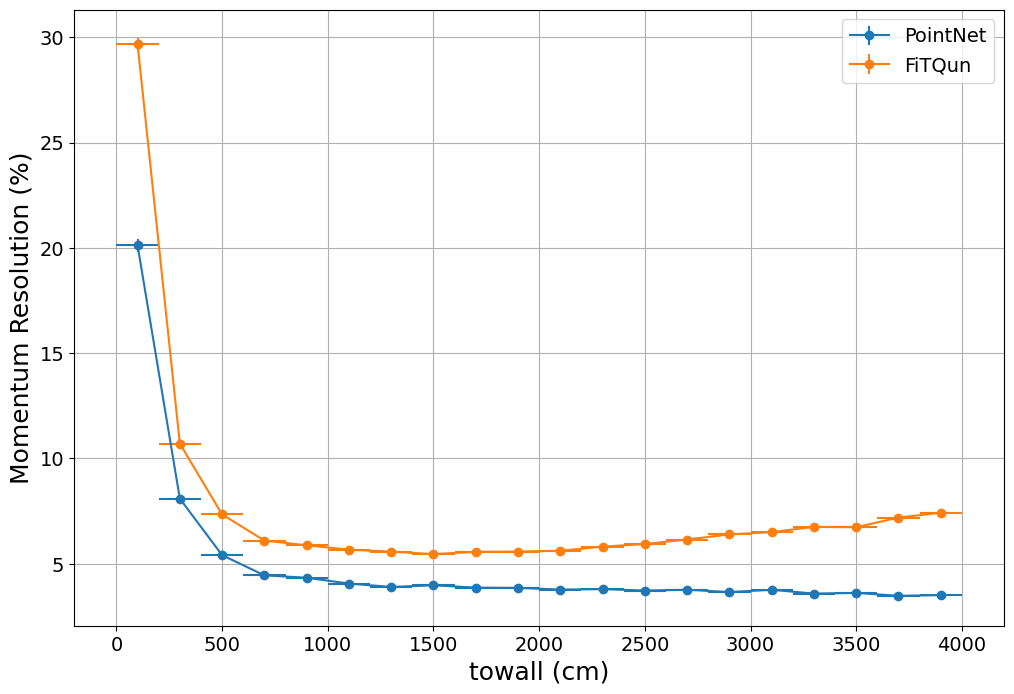

<Figure size 640x480 with 0 Axes>

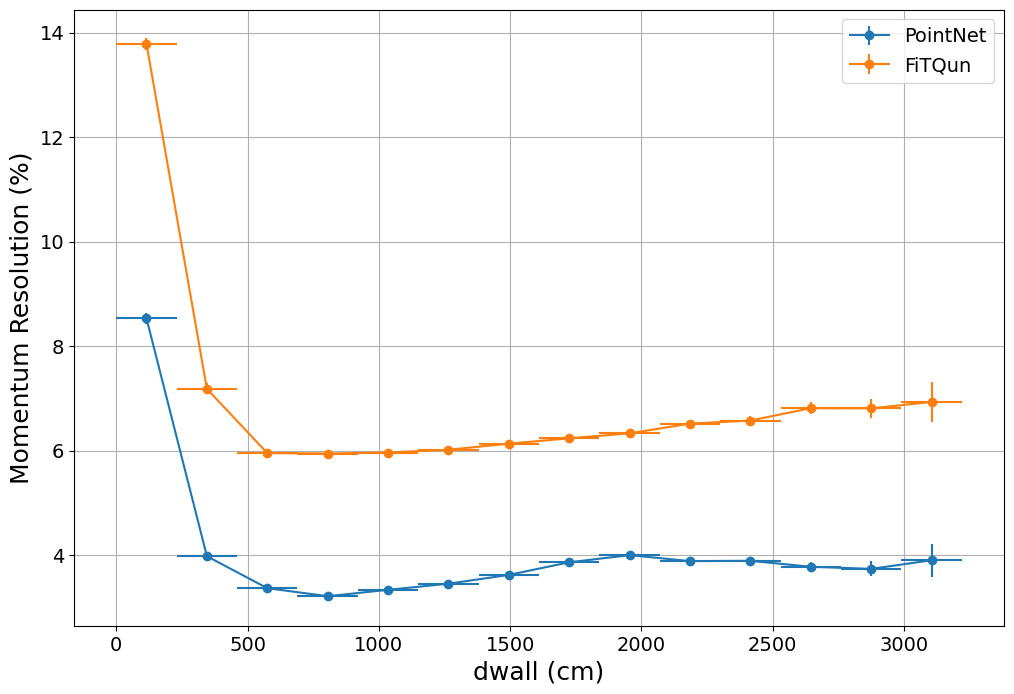

In [65]:
plot_against_true_variable(good_true_energies, [good_ml_recon_energies, good_fq_recon_energies], towall,
#                            recon_type, ['PointNet', 'FiTQun'], 'towall', [0., round(max(towall),0)+1], 230.)
                           recon_type, ['PointNet', 'FiTQun'], 'towall', [0., 4000.], 200.)

plot_against_true_variable(good_true_energies, [good_ml_recon_energies, good_fq_recon_energies], dwall, 
                           recon_type, ['PointNet', 'FiTQun'], 'dwall', [0., round(max(dwall),0)+1], 230.)

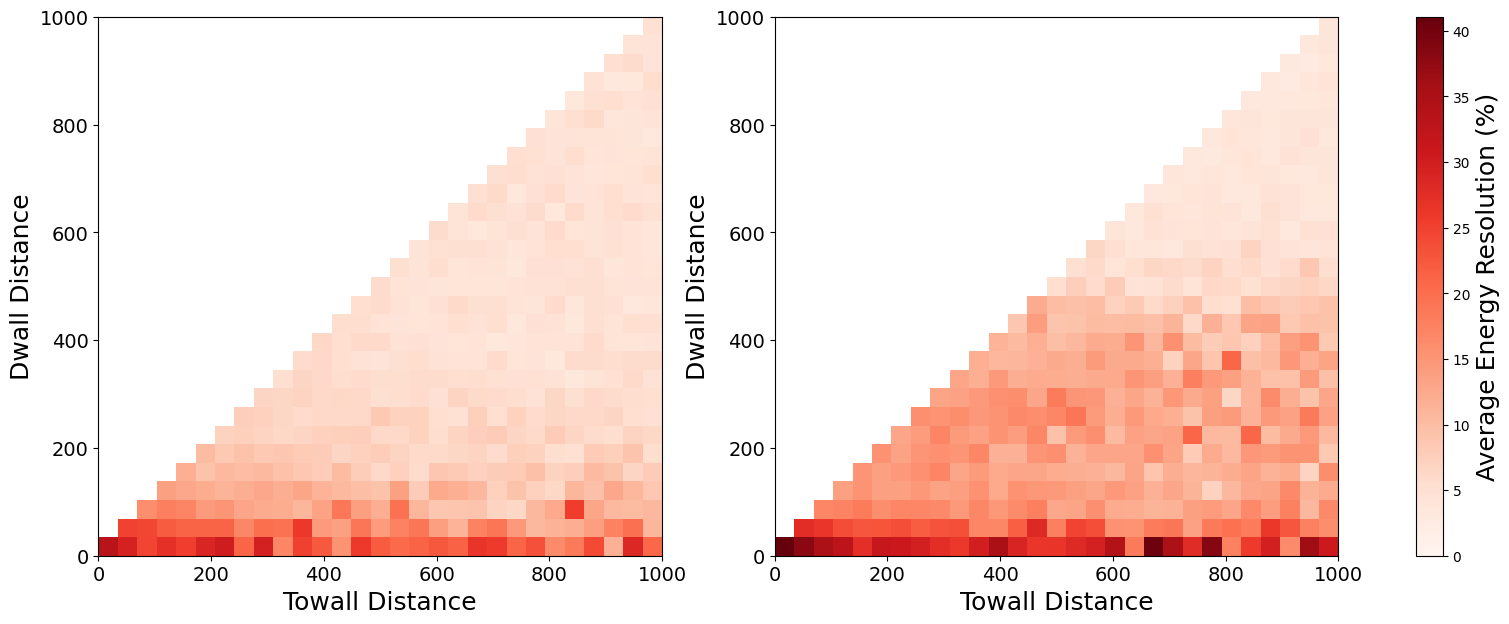

In [52]:
# Plot dwall vs. towall as histo and overlay energy resolution (%)
towall_edges = np.linspace(0., 1000., 30)
dwall_edges = np.linspace(0., 1000., 30)

residuals_ml = abs(((good_ml_momentum/good_true_momentum) - 1)*100)
residuals_fq = abs(((good_fq_recon_energies/good_true_momentum) - 1)*100)

energy_res_bin_ml = np.zeros((len(towall_edges)-1, len(dwall_edges)-1))
energy_res_bin_fq = np.zeros((len(towall_edges)-1, len(dwall_edges)-1))


# Fill the array with average energy resolutions
for i in range(len(towall_edges)-1):
    for j in range(len(dwall_edges)-1):
        # Get indices of events in the current bin
        indices = np.where((towall >= towall_edges[i]) & (towall < towall_edges[i+1]) &
                           (dwall >= dwall_edges[j]) & (dwall < dwall_edges[j+1]))

        # Calculate average energy resolution for the bin
        if len(indices[0]) > 0:
            energy_res_bin_ml[i, j] = np.mean(np.take(residuals_ml, indices))
            energy_res_bin_fq[i, j] = np.mean(np.take(residuals_fq, indices))

masked_energy_res_bin_ml = np.ma.masked_where(energy_res_bin_ml == 0, energy_res_bin_ml)
masked_energy_res_bin_fq = np.ma.masked_where(energy_res_bin_fq == 0, energy_res_bin_fq)

# Keep the colour consistent
global_min = min(np.min(energy_res_bin_ml), np.min(energy_res_bin_fq))
global_max = max(np.max(energy_res_bin_ml), np.max(energy_res_bin_fq))

# Create a colormap that sets masked values (zeros) to white
cmap = plt.cm.Reds  # or any colormap you prefer
cmap.set_bad(color='white')

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
# Plot for ML residuals
pc = axs[0].pcolormesh(towall_edges, dwall_edges, masked_energy_res_bin_ml.T, cmap=cmap, shading='auto', 
                       vmin=global_min, vmax=global_max)
axs[0].set_xlabel('Towall Distance', fontsize=18)
axs[0].set_ylabel('Dwall Distance', fontsize=18)
axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
# axs[0].set_title('PointNet Residuals', fontsize=18)

# Plot for FQ residuals
pc = axs[1].pcolormesh(towall_edges, dwall_edges, masked_energy_res_bin_fq.T, cmap=cmap, shading='auto', 
                       vmin=global_min, vmax=global_max)
axs[1].set_xlabel('Towall Distance', fontsize=18)
axs[1].set_ylabel('Dwall Distance', fontsize=18)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)
# axs[1].set_title('FitQun Residuals', fontsize=18)

# Colorbar
cbar = fig.colorbar(pc, ax=axs.ravel().tolist())
cbar.set_label(label='Average Energy Resolution (%)', fontsize=18)

plt.savefig(f'plots/{particle_names[0]}_EResolution_68percentile/{particle_names[0]}_EResolution_68percentile_FV_compare_261MeVorMore.png')
plt.show()

### Against Angles/Directions

In [66]:
cos_zenith = np.cos(good_angles[:,0])

<Figure size 640x480 with 0 Axes>

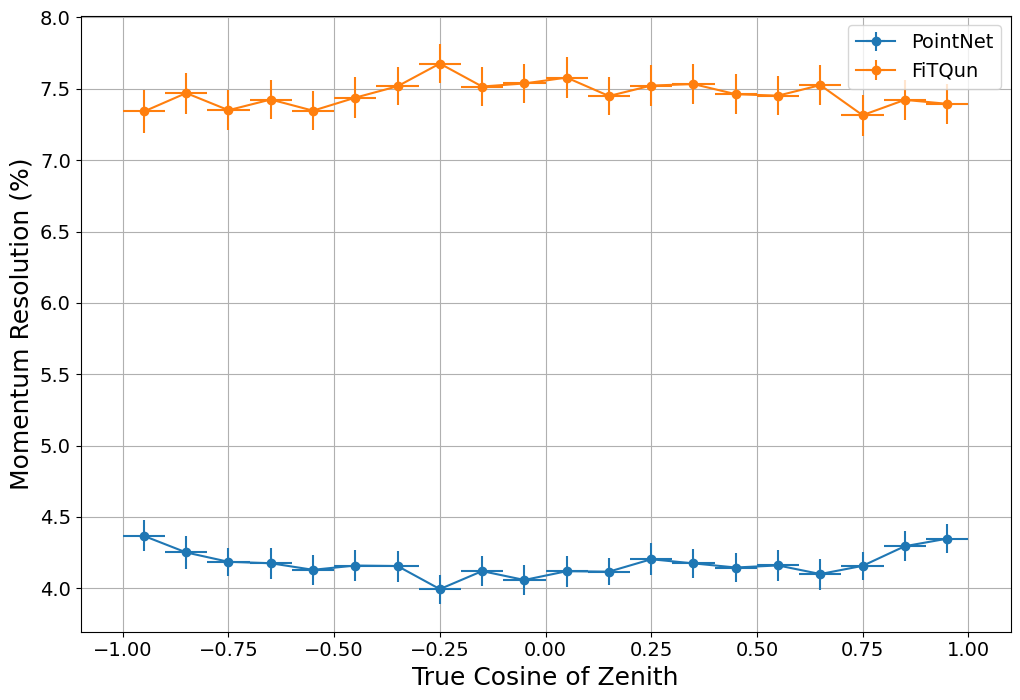

<Figure size 640x480 with 0 Axes>

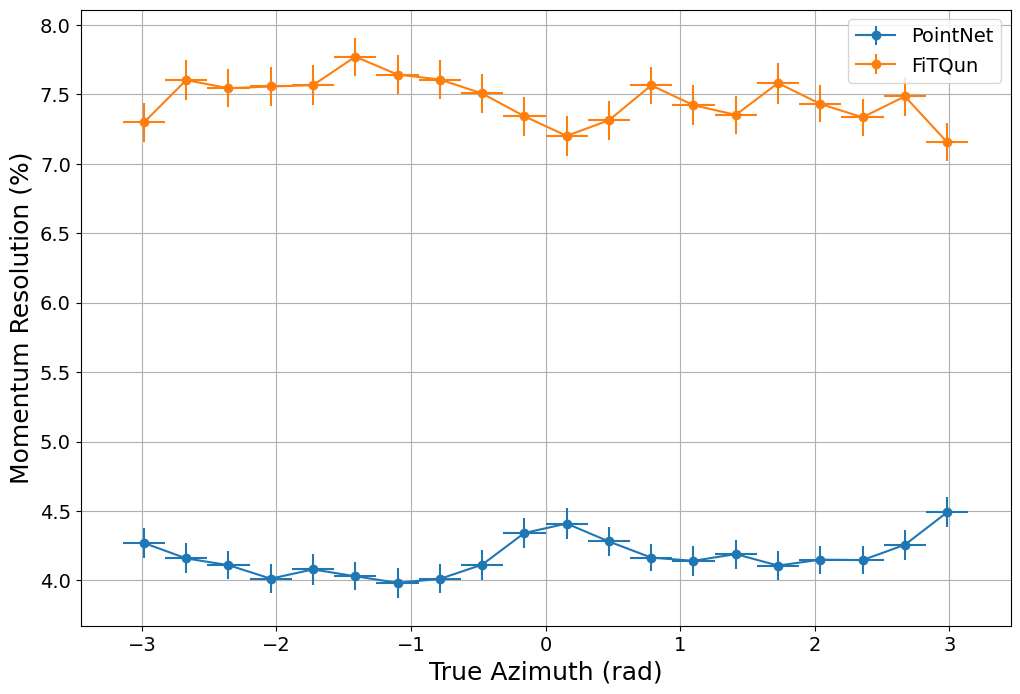

In [67]:
plot_against_true_variable(good_true_momentum, [good_ml_momentum, good_fq_recon_energies], cos_zenith,
                           recon_type, ['PointNet', 'FiTQun'], 'Cosine of Zenith', [-1, 1], 0.1)
plot_against_true_variable(good_true_momentum, [good_ml_momentum, good_fq_recon_energies], 
                           good_angles[:,1], recon_type, ['PointNet', 'FiTQun'], 'Azimuth',
                           [-np.pi, np.pi], np.pi/10)

# Position

### First apply cut to get rid of empty events

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


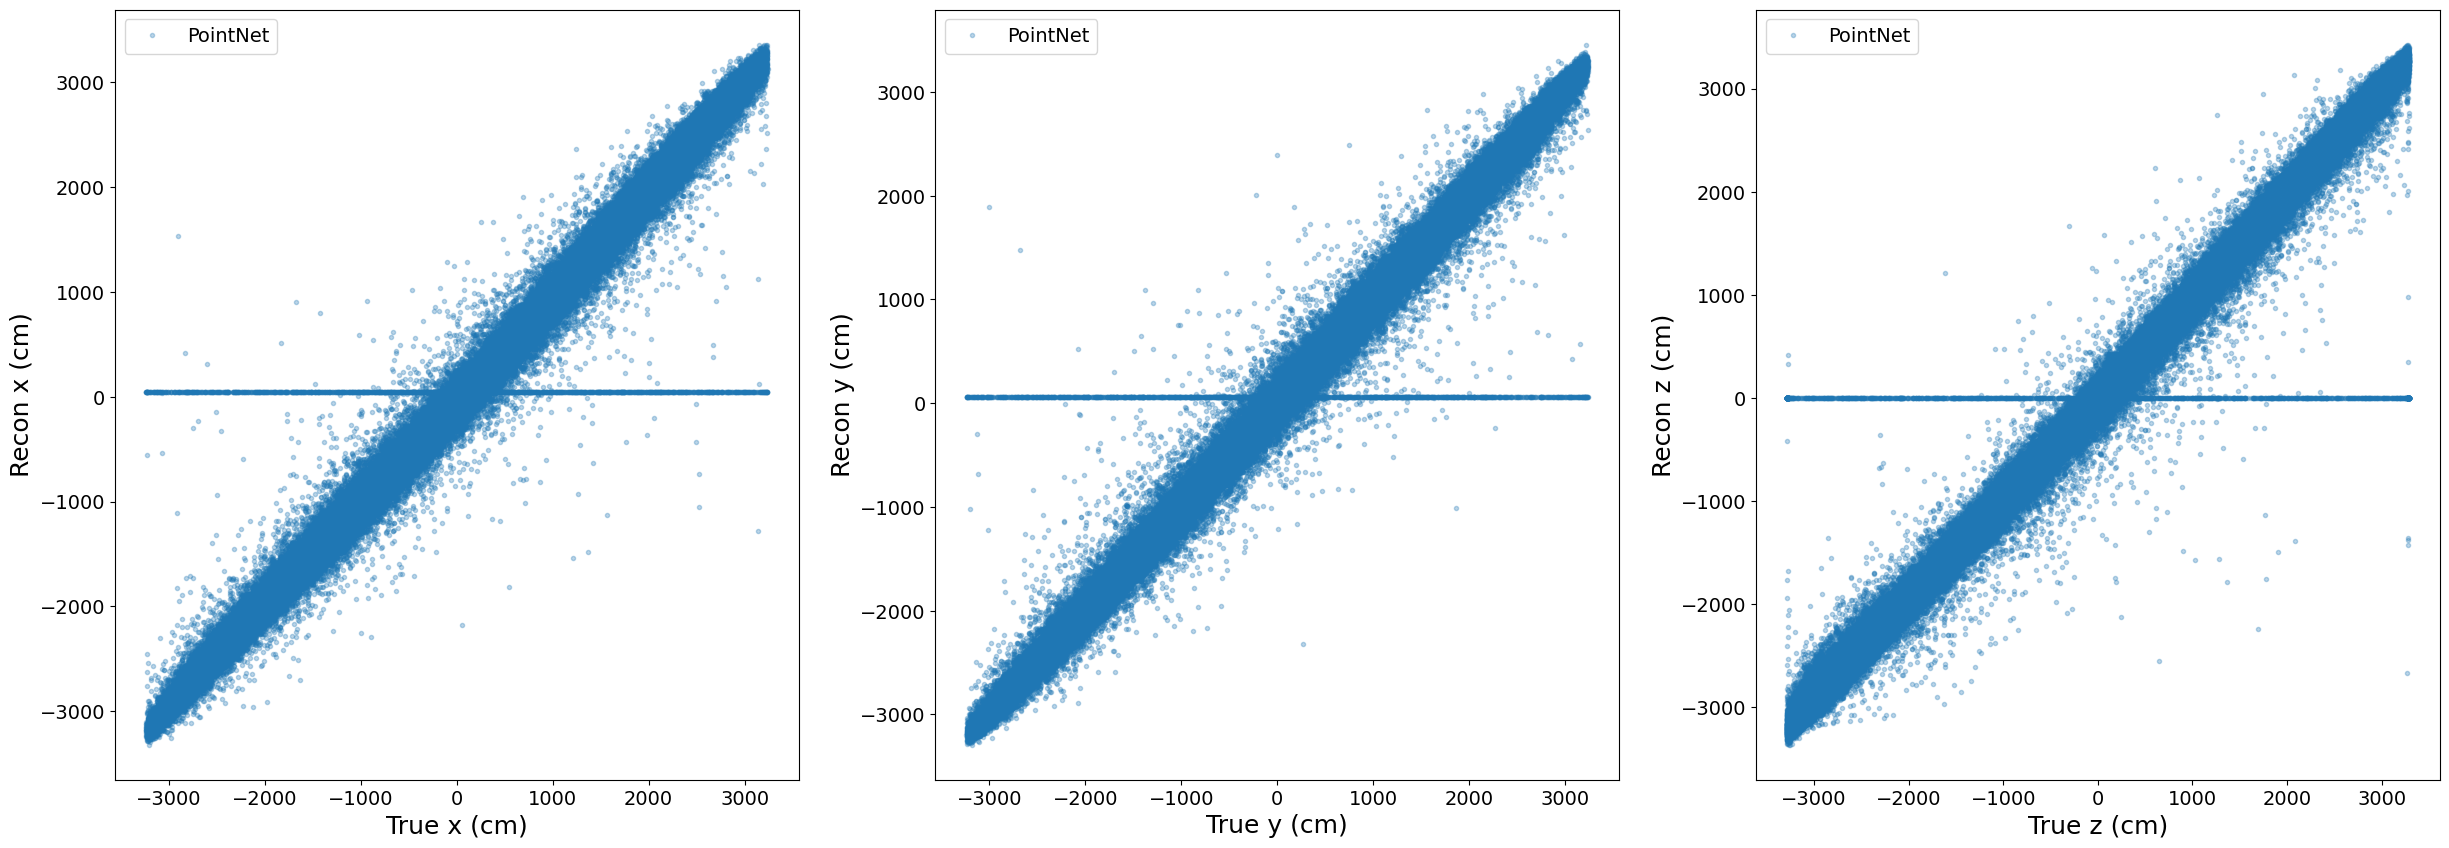

In [54]:
xlabels=['x', 'y', 'z']
fig, axs = plt.subplots(2, 3, figsize=(30, 20))
for i in range(3):
    axs[0, i].plot(true_positions[0][:,i], recon_positions[0][:,i], ".", alpha=0.3, label='PointNet')
    axs[1, i].plot(h5_positions[:,i], fq_reco_pos_mu[:3000*100][:,i], ".", color=c[1], alpha=0.3, label='FiTQun')

    axs[0, i].set_xlabel(f"True {xlabels[i]} (cm)", fontsize=18)
    axs[0, i].set_ylabel(f"Recon {xlabels[i]} (cm)", fontsize=18)
    axs[1, i].set_xlabel(f"True {xlabels[i]} (cm)", fontsize=18)
    axs[1, i].set_ylabel(f"Recon {xlabels[i]} (cm)", fontsize=18)

#     axs[i].set_ylim([-3600, 3600])
    axs[0, i].tick_params(axis='x', labelsize=14)
    axs[0, i].tick_params(axis='y', labelsize=14)
    axs[1, i].tick_params(axis='x', labelsize=14)
    axs[1, i].tick_params(axis='y', labelsize=14)
    axs[0, i].legend(fontsize=14)
    axs[1, i].legend(fontsize=14)
    
    plt.legend(fontsize=14)
    plt.savefig(f'plots/{particle_names[0]}_posResolution_68percentile/{particle_names[0]}_pos_recon_vs_true.png')
# plt.ylim(149.36, 149.3605) # location of where the weird line occurs (E energy)
# plt.ylim([48.164,48.17]) # location of where the weird line occurs (x)

In [19]:
print(true_positions)

In [18]:
# Cuts on ML data/output
if particle_names[0] == 'e-':
    bad_events  = np.where((recon_positions[0][:,0] > 48.164) & (recon_positions[0][:,0] < 48.17))[0]
    good_events0 = np.delete(range(len(true_positions[0])), bad_events)

    fq_reco_pos_e          = fq_reco_pos_e[:3000*100]
    good_fq_recon_pos      = fq_reco_pos_e[good_events0]
    fq_bad_events = np.where((good_fq_recon_pos[:,0] < -5000) | (good_fq_recon_pos[:,0] > 5000) |
                             (good_fq_recon_pos[:,1] < -5000) | (good_fq_recon_pos[:,1] > 5000) |
                             (good_fq_recon_pos[:,2] < -5000) | (good_fq_recon_pos[:,2] > 5000))[0]
    good_events1   = np.delete(good_events0, fq_bad_events)
    
elif particle_names[0] == 'mu-':
    bad_events  = np.where((recon_positions[0][:,0] > 10.584) & (recon_positions[0][:,0] < 10.6))[0]
    good_events0 = np.delete(range(len(true_positions[0])), bad_events)

    fq_reco_pos_e          = fq_reco_pos_mu[:3000*100]
    good_fq_recon_pos      = fq_reco_pos_mu[good_events0]
    fq_bad_events = np.where((good_fq_recon_pos[:,0] < -5000) | (good_fq_recon_pos[:,0] > 5000) |
                             (good_fq_recon_pos[:,1] < -5000) | (good_fq_recon_pos[:,1] > 5000) |
                             (good_fq_recon_pos[:,2] < -5000) | (good_fq_recon_pos[:,2] > 5000))[0]
    good_events1   = np.delete(good_events0, fq_bad_events)

good_true_energies     = h5_energies[good_events1]
good_ml_recon_pos      = recon_positions[0][good_events1]
good_true_positions    = h5_positions[good_events1]
good_angles            = h5_angles[good_events1]
good_vetos             = h5_vetos[good_events1]
good_labels            = h5_labels[good_events1]
good_idxs              = indices[0][good_events1]

if particle_names[0] == 'e-':
    good_fq_recon_pos      = fq_reco_pos_e[good_events1]
elif particle_names[0] == 'mu-':
    good_fq_recon_pos      = fq_reco_pos_mu[good_events1]

In [19]:
dist_diff_3d_ml = np.sqrt((good_ml_recon_pos[:,0] - good_true_positions[:,0])**2 
                          + (good_ml_recon_pos[:,1] - good_true_positions[:,1])**2 
                          + (good_ml_recon_pos[:,2] - good_true_positions[:,2])**2)

dist_diff_3d_fq = np.sqrt((good_fq_recon_pos[:,0] - good_true_positions[:,0])**2 
                          + (good_fq_recon_pos[:,1] - good_true_positions[:,1])**2 
                          + (good_fq_recon_pos[:,2] - good_true_positions[:,2])**2)
momentum = ev.momentum(good_true_energies, good_labels)
# r_3d = np.sqrt(good_true_positions[:,0]**2 + good_true_positions[:,1]**2 + good_true_positions[:,2]**2)
# recon_r_3d_ml = np.sqrt(good_ml_recon_pos[:,0]**2 + good_ml_recon_pos[:,1]**2 + good_ml_recon_pos[:,2]**2)
# recon_r_3d_fq = np.sqrt(good_fq_recon_pos[:,0]**2 + good_fq_recon_pos[:,1]**2 + good_fq_recon_pos[:,2]**2)

In [20]:
good_labels

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

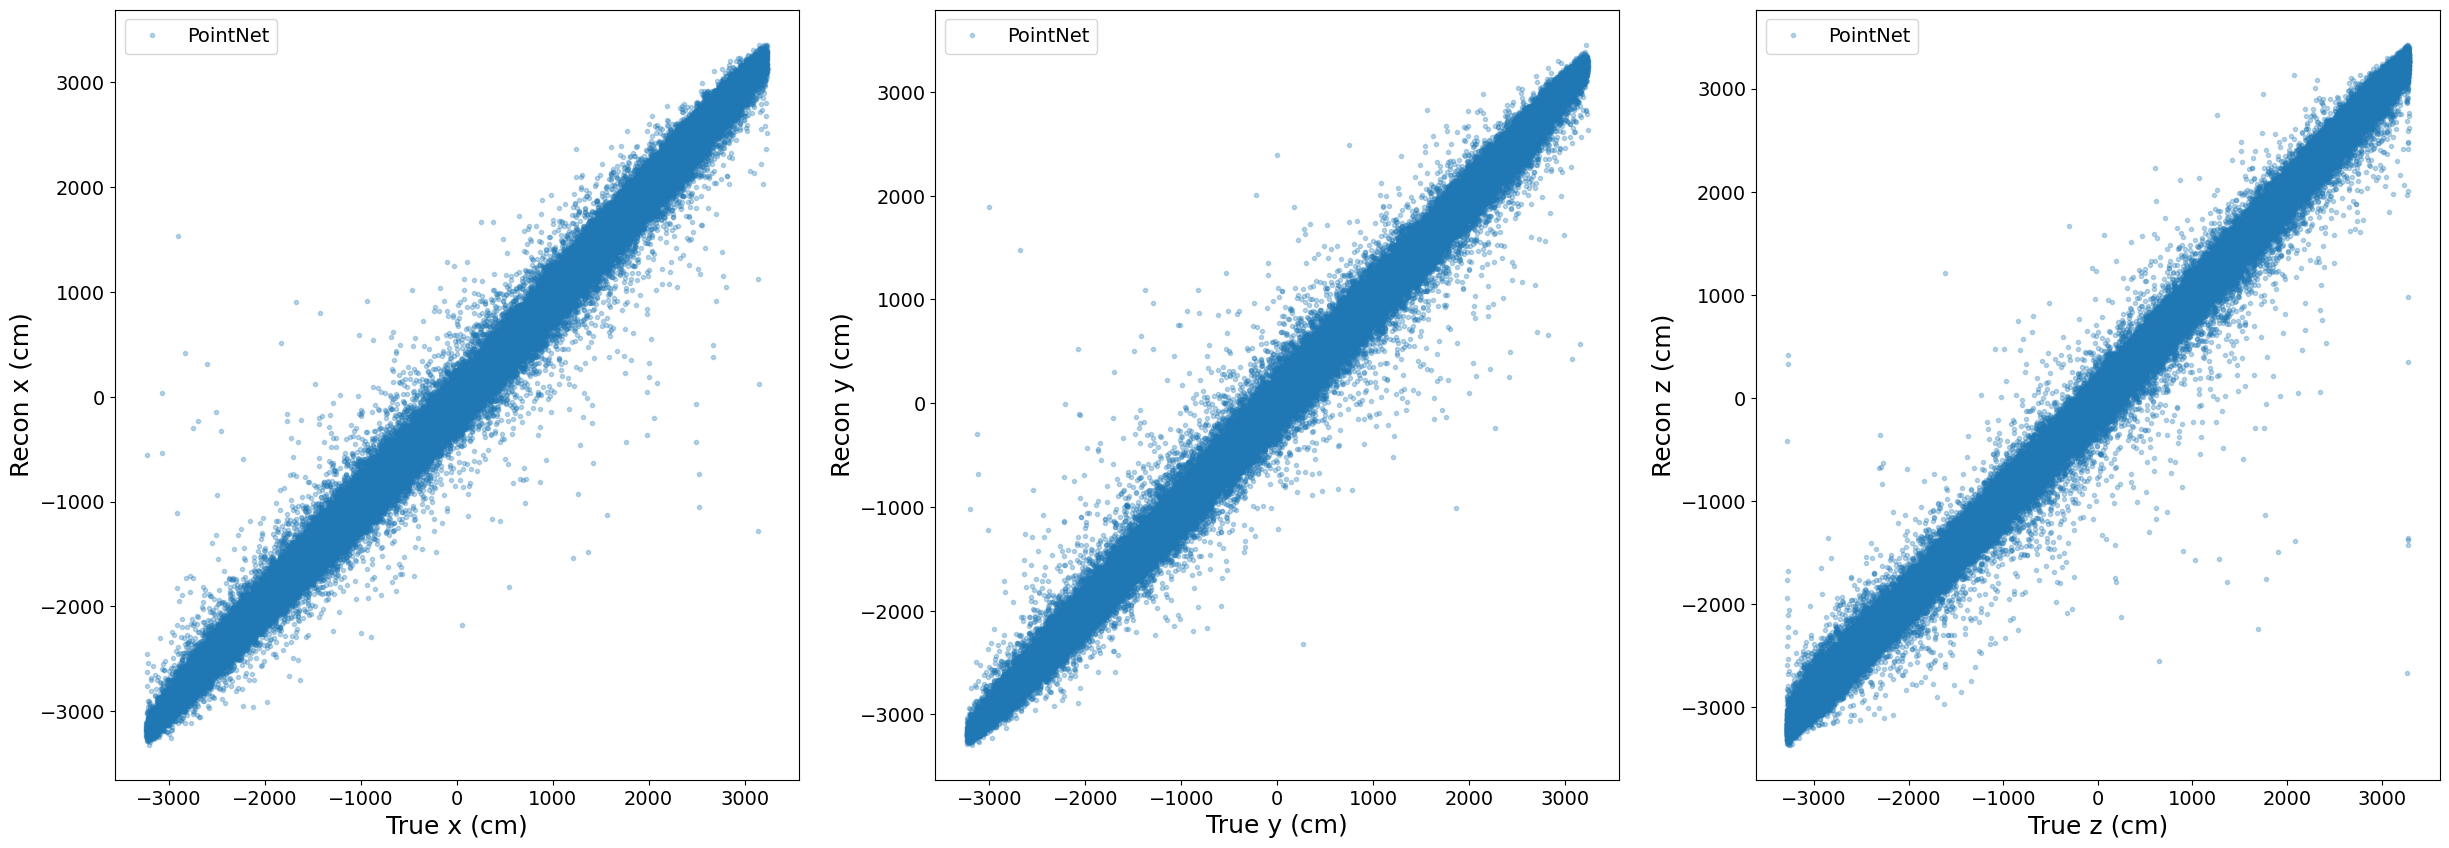

In [56]:
xlabels=['x', 'y', 'z']
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i in range(3):
    axs[i].plot(good_true_positions[:,i], good_ml_recon_pos[:,i], ".", alpha=0.3, label='PointNet')
#     axs[1, i].plot(good_true_positions[:,i], good_fq_recon_pos[:,i], ".", color='pink', alpha=0.3, label='FiTQun')

    axs[i].set_xlabel(f"True {xlabels[i]} (cm)", fontsize=18)
    axs[i].set_ylabel(f"Recon {xlabels[i]} (cm)", fontsize=18)
#     axs[1, i].set_xlabel(f"True {xlabels[i]} (cm)", fontsize=18)
#     axs[1, i].set_ylabel(f"Recon {xlabels[i]} (cm)", fontsize=18)

#     axs[i].set_ylim([-3600, 3600])
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
#     axs[1, i].tick_params(axis='x', labelsize=14)
#     axs[1, i].tick_params(axis='y', labelsize=14)
    axs[i].legend(fontsize=14)
#     axs[1, i].legend(fontsize=14)
    
    plt.savefig(f'plots/{particle_names[0]}_posResolution_68percentile/\
{particle_names[0]}_pos_recon_vs_true_afterCuts.png')

    
# plt.ylim(149.36, 149.3605) # location of where the weird line occurs (E energy)
# plt.ylim([48.164,48.17]) # location of where the weird line occurs (x)

# Position resolution as a function of true variables

### Against True Momentum

<Figure size 640x480 with 0 Axes>

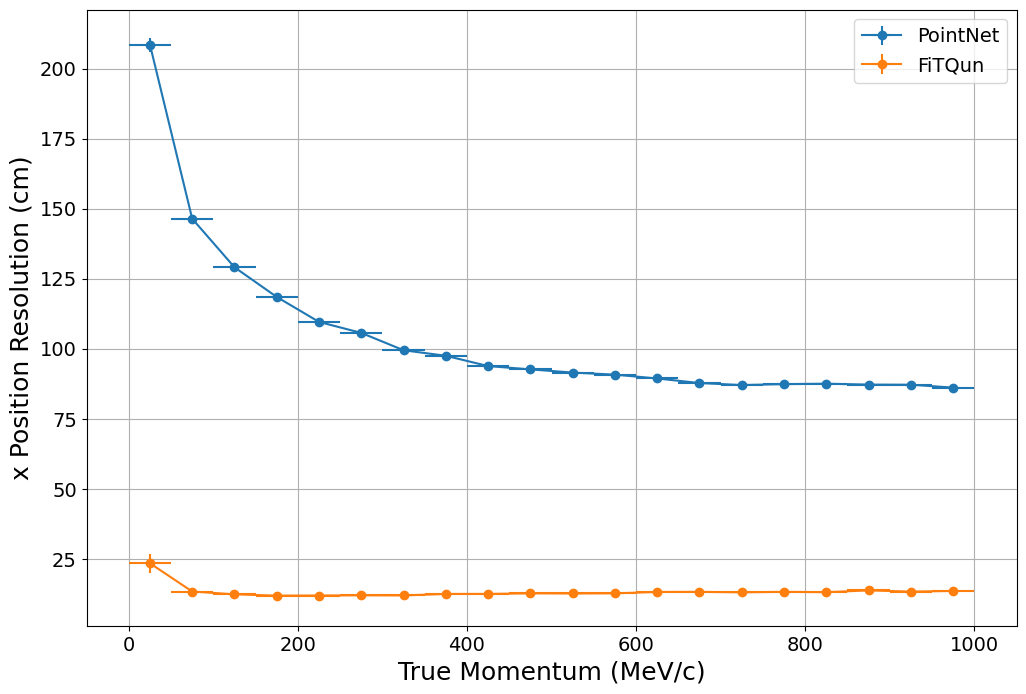

<Figure size 640x480 with 0 Axes>

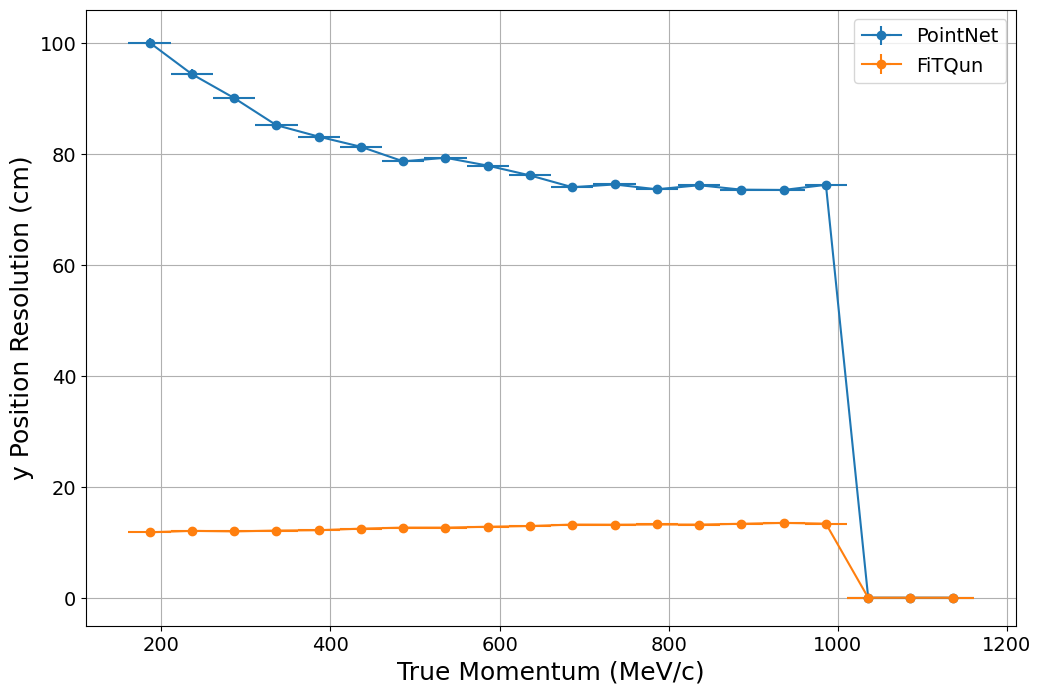

<Figure size 640x480 with 0 Axes>

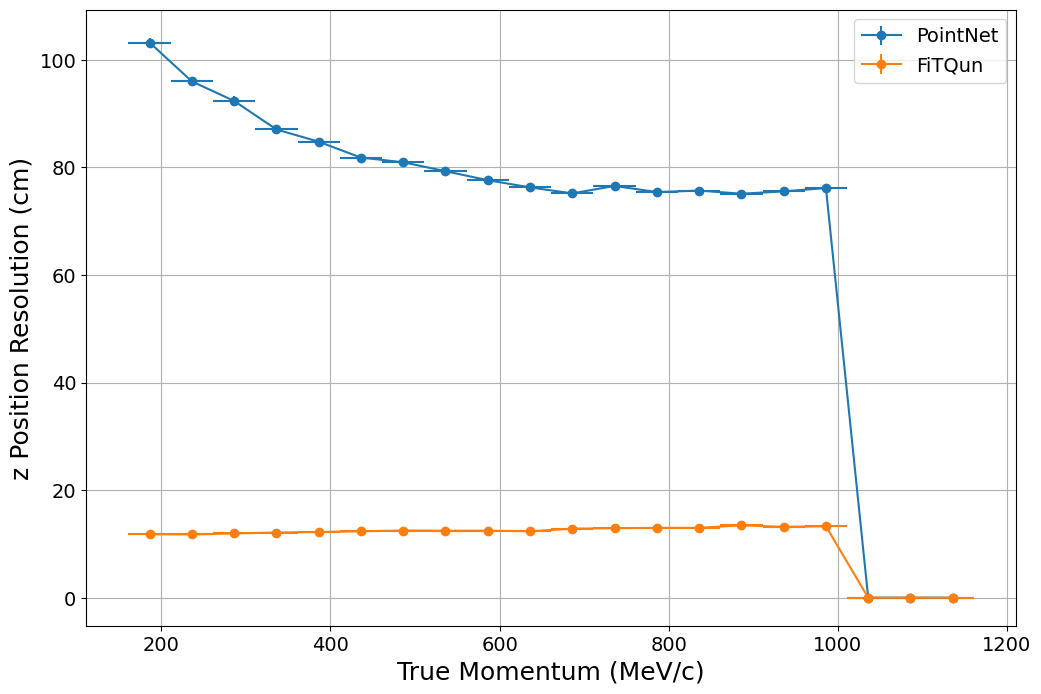

In [37]:
plot_against_true_variable(good_true_positions[:,0], [good_ml_recon_pos[:,0], good_fq_recon_pos[:,0]],
                           good_true_energies, 'positions', ['PointNet', 'FiTQun'], 'momentum', title='x')#,
#                            plotting_range=[161., 1161.]) # for muon plotting
plot_against_true_variable(good_true_positions[:,1], [good_ml_recon_pos[:,1], good_fq_recon_pos[:,1]], 
                           good_true_energies, 'positions', ['PointNet', 'FiTQun'], 'momentum', title='y',
                           plotting_range=[161., 1161.]) # for muon plotting
plot_against_true_variable(good_true_positions[:,2], [good_ml_recon_pos[:,2], good_fq_recon_pos[:,2]], 
                           good_true_energies, 'positions', ['PointNet', 'FiTQun'], 'momentum', title='z',
                           plotting_range=[161., 1161.]) # for muon plotting

<Figure size 640x480 with 0 Axes>

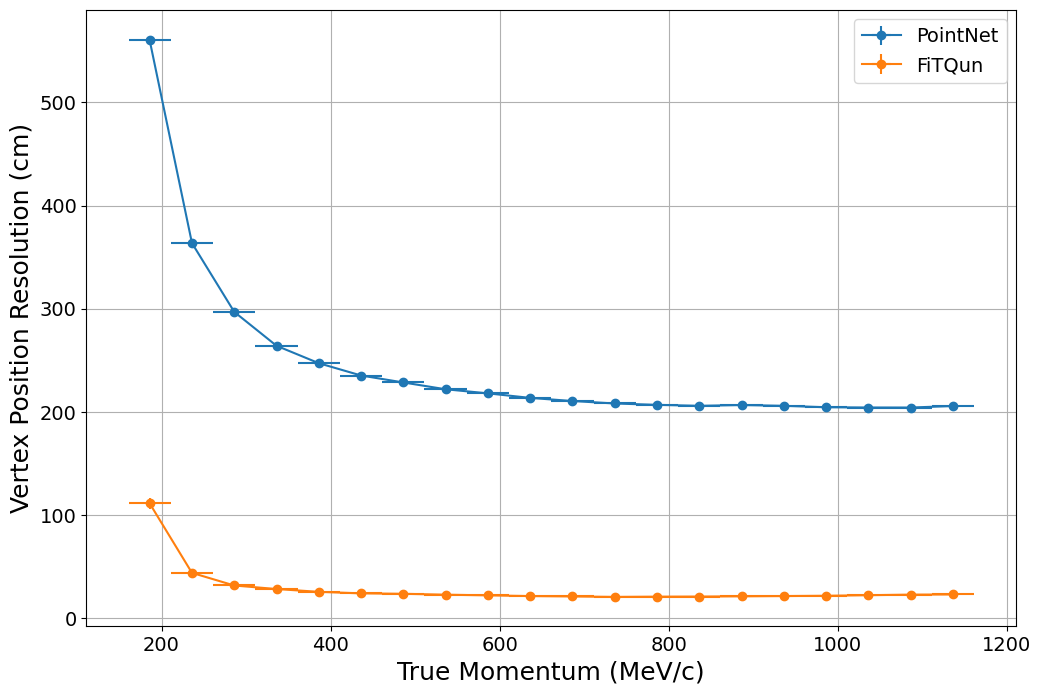

In [21]:
plot_against_true_variable(np.zeros(dist_diff_3d_ml.shape), [dist_diff_3d_ml, dist_diff_3d_fq], 
                           momentum, 'positions', ['PointNet', 'FiTQun'], 'momentum', 
                           title='Vertex',
                           plotting_range=[161., 1161.]) # for muon plotting

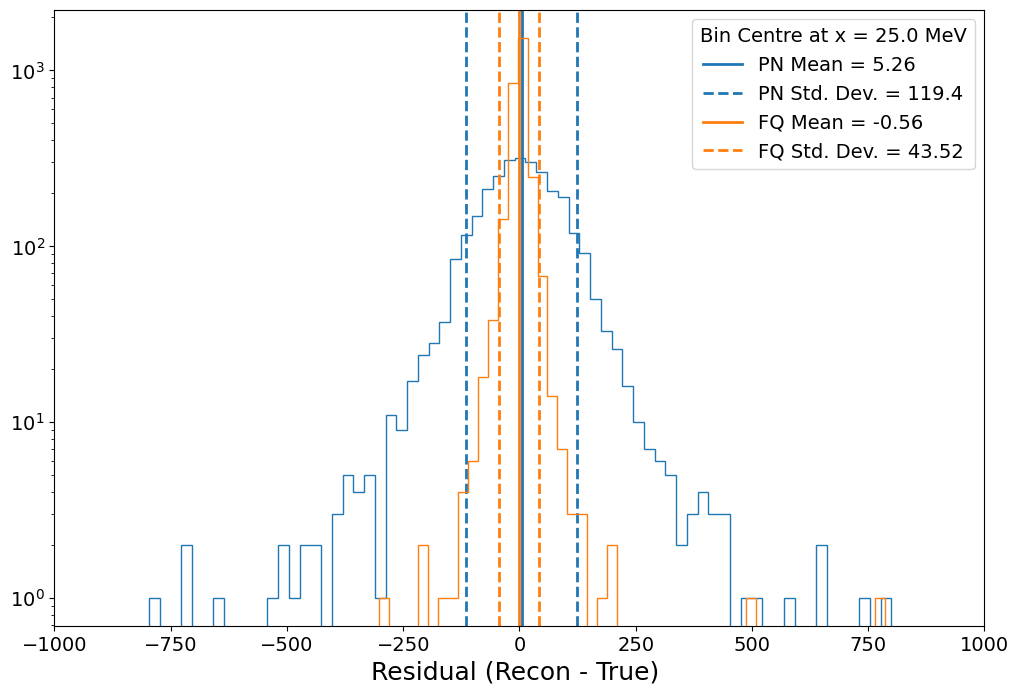

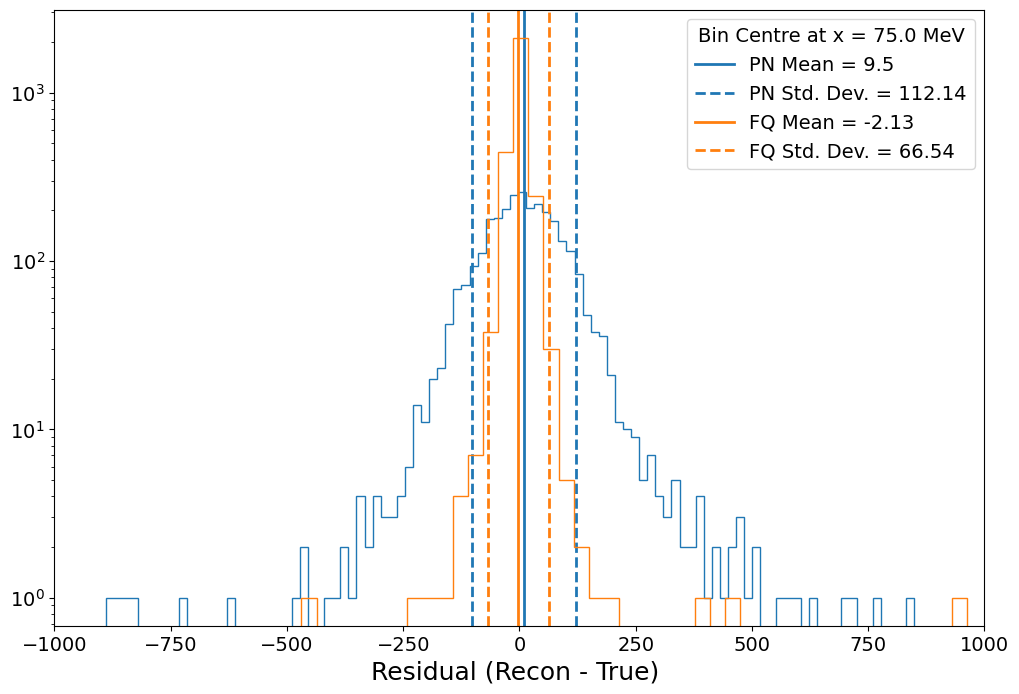

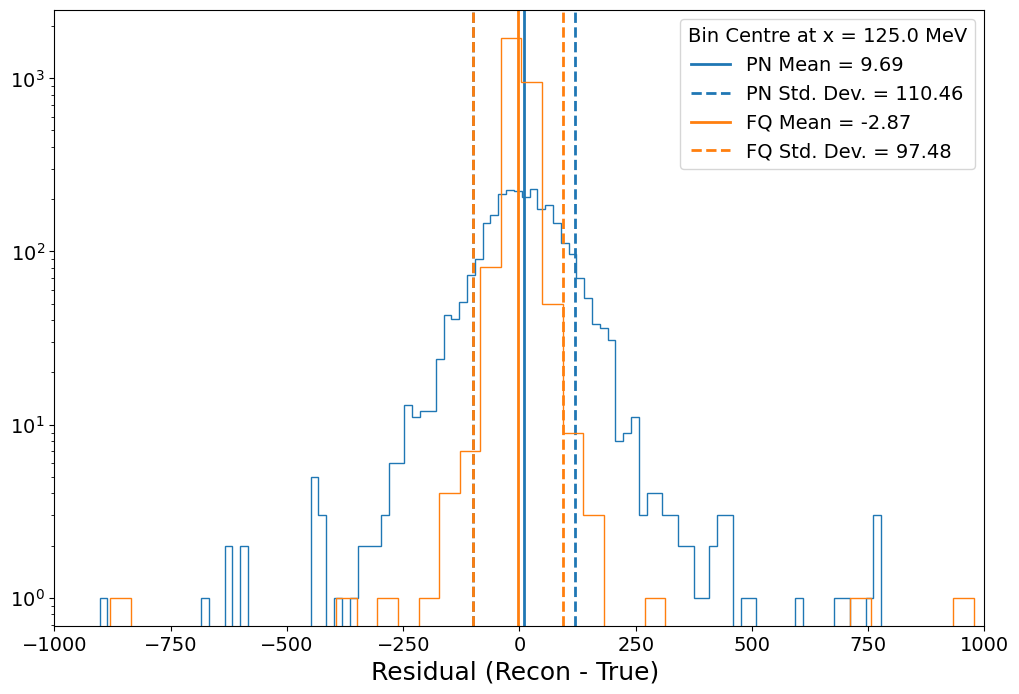

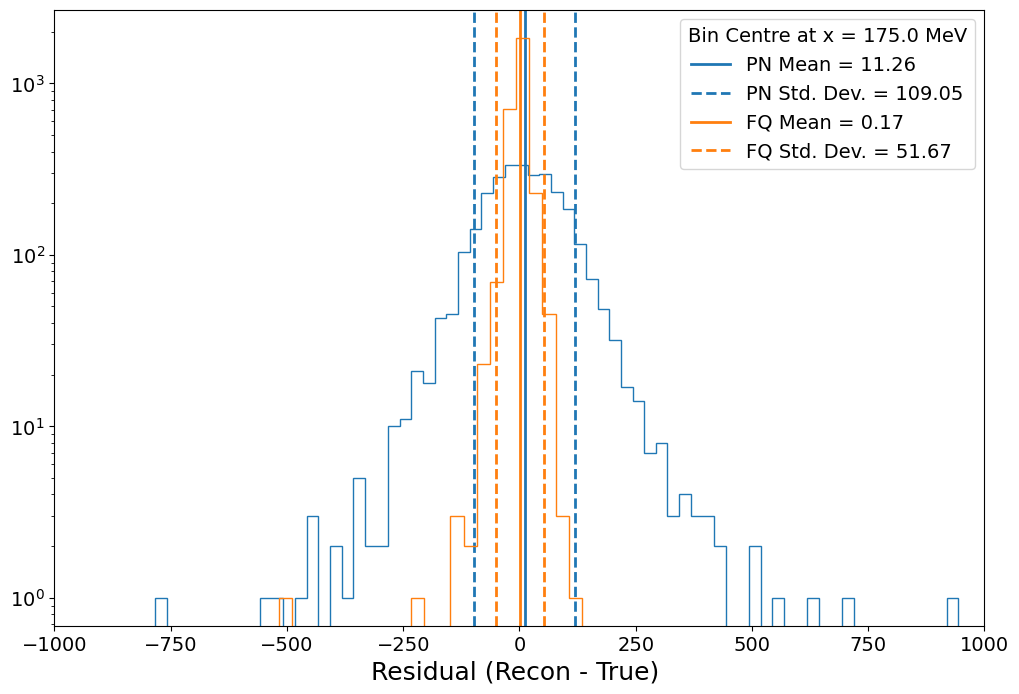

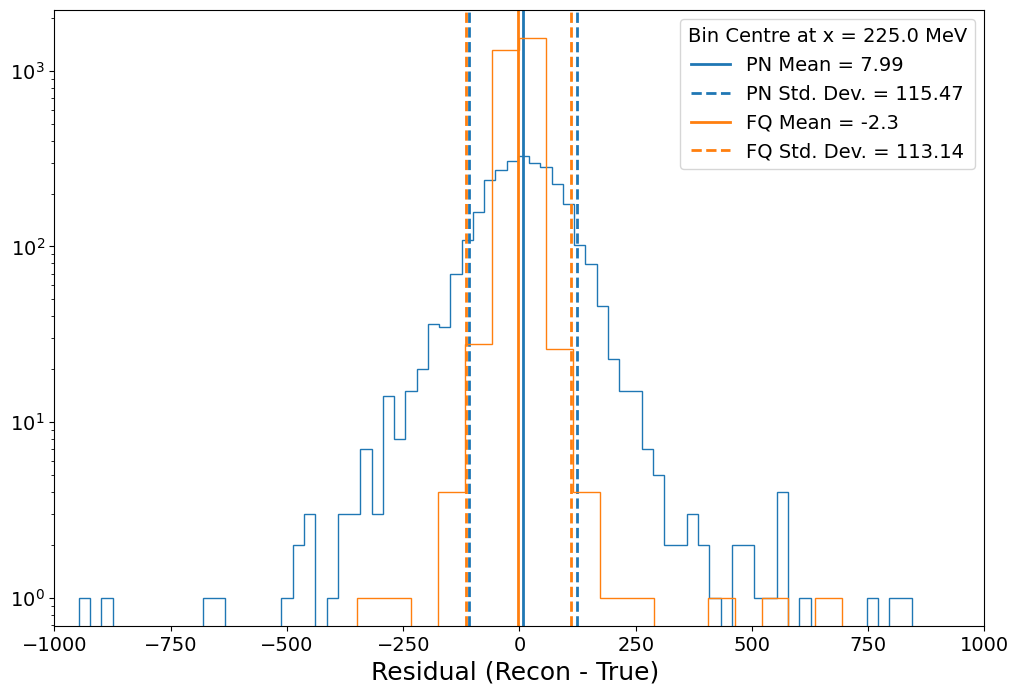

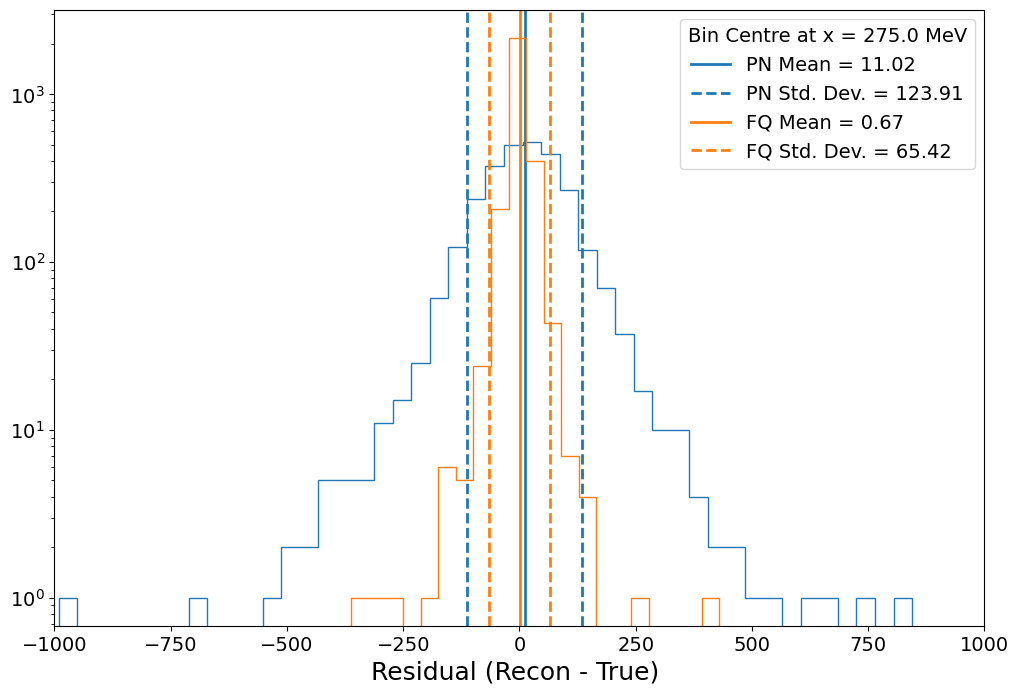

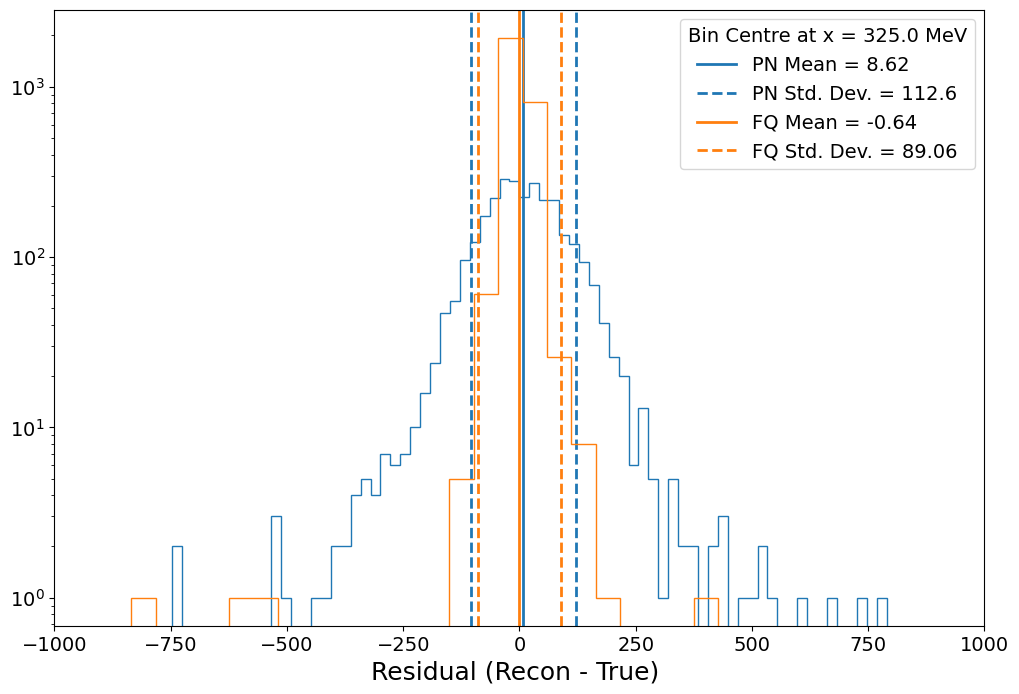

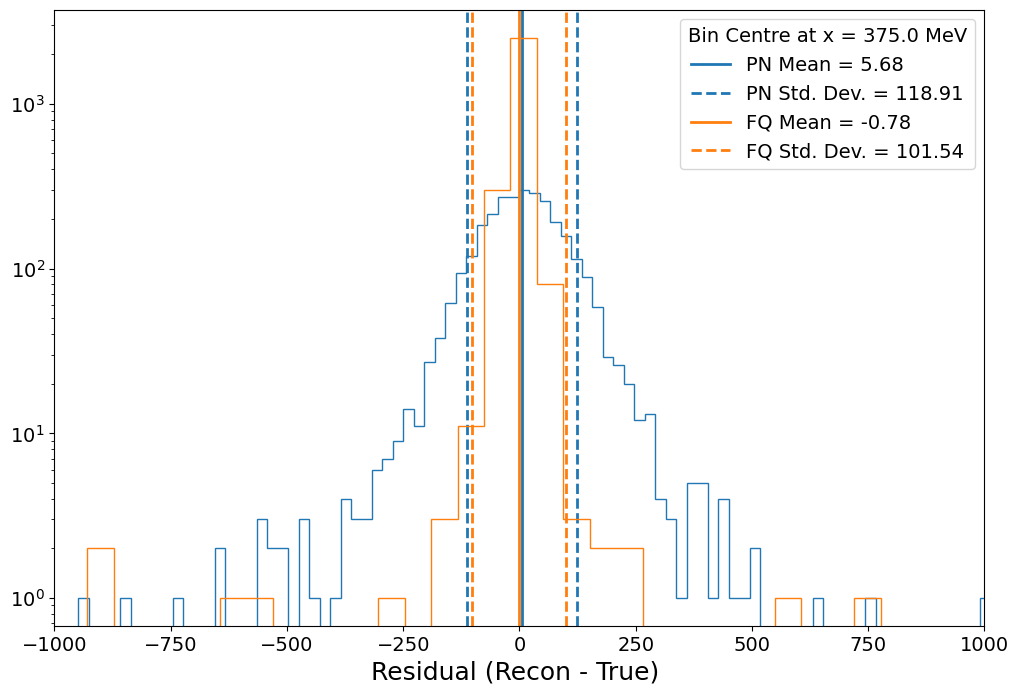

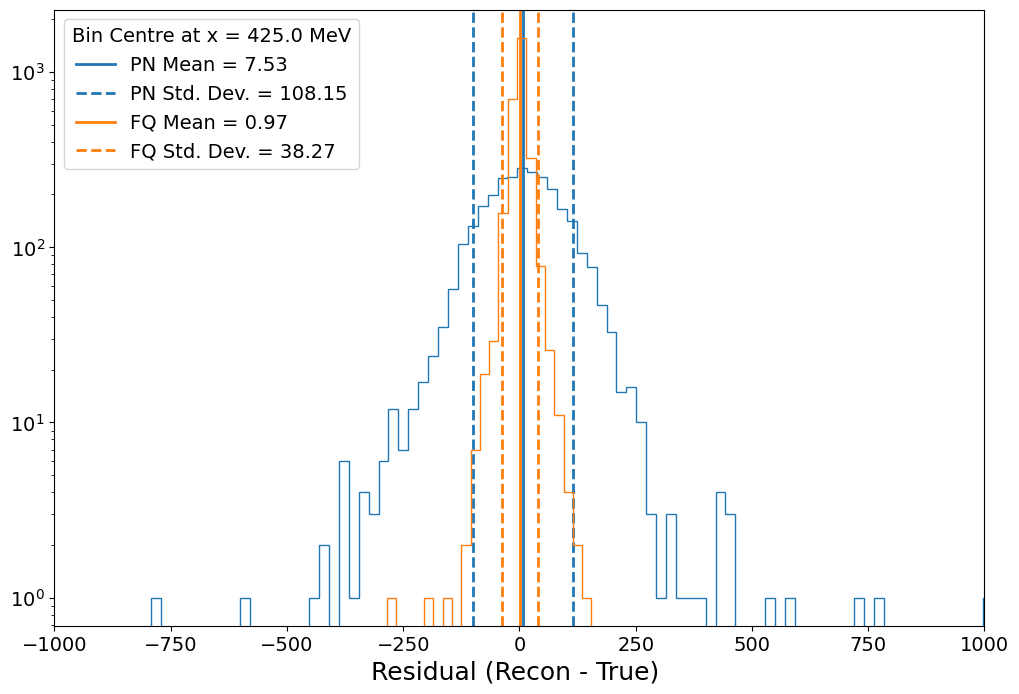

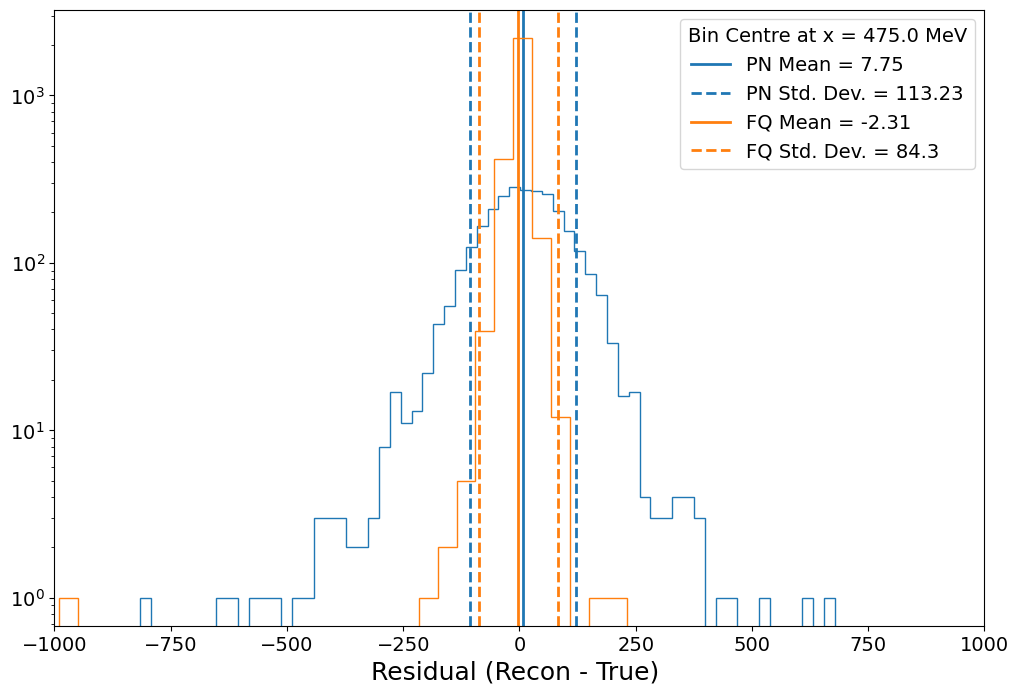

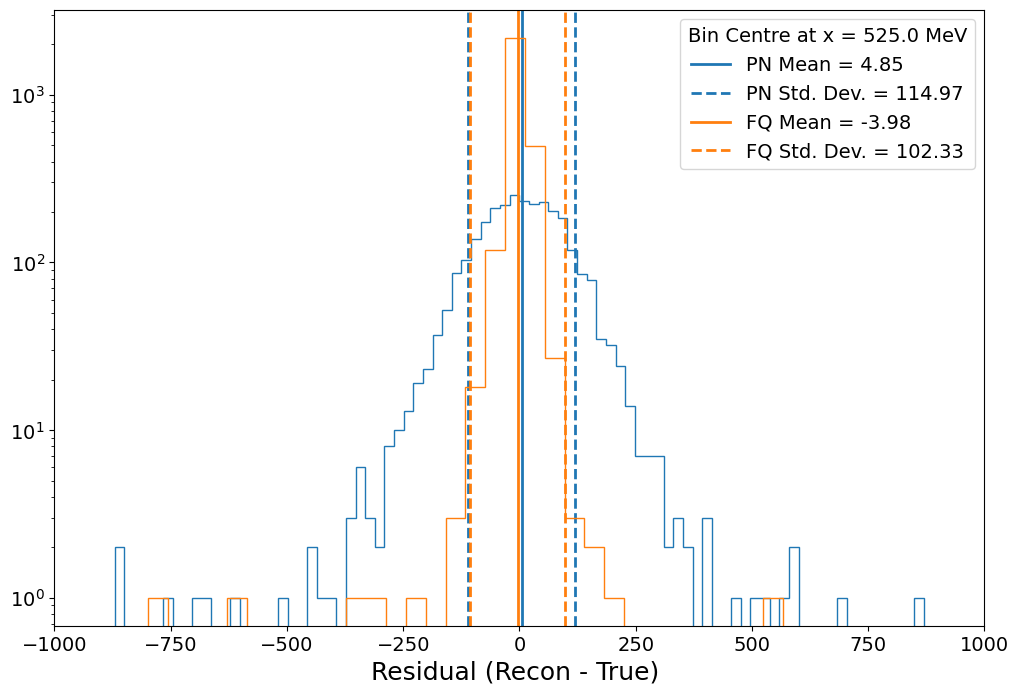

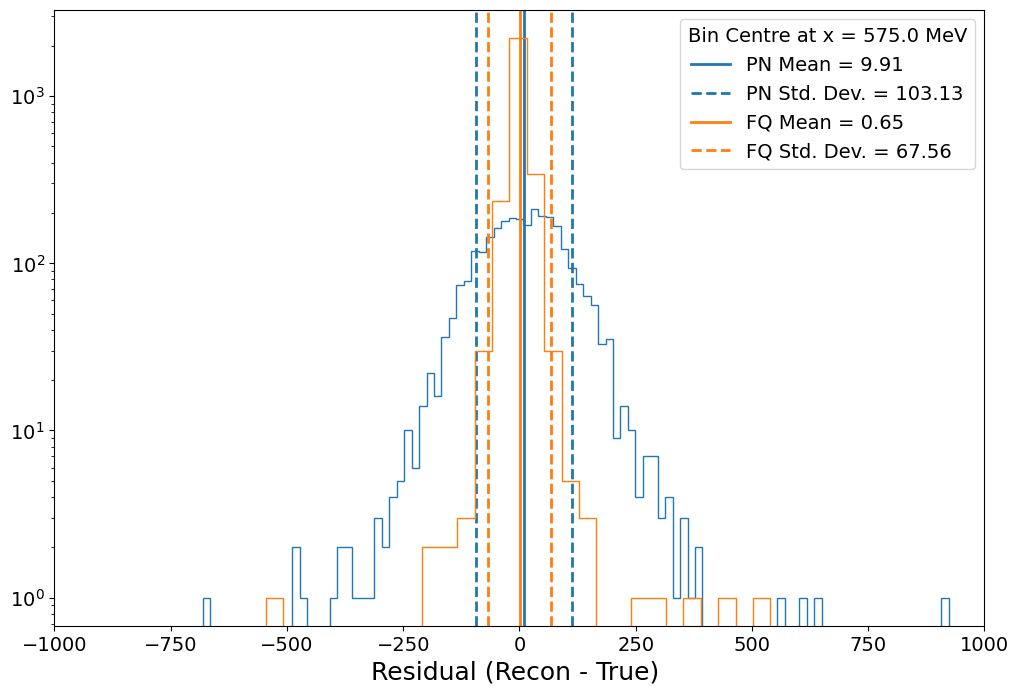

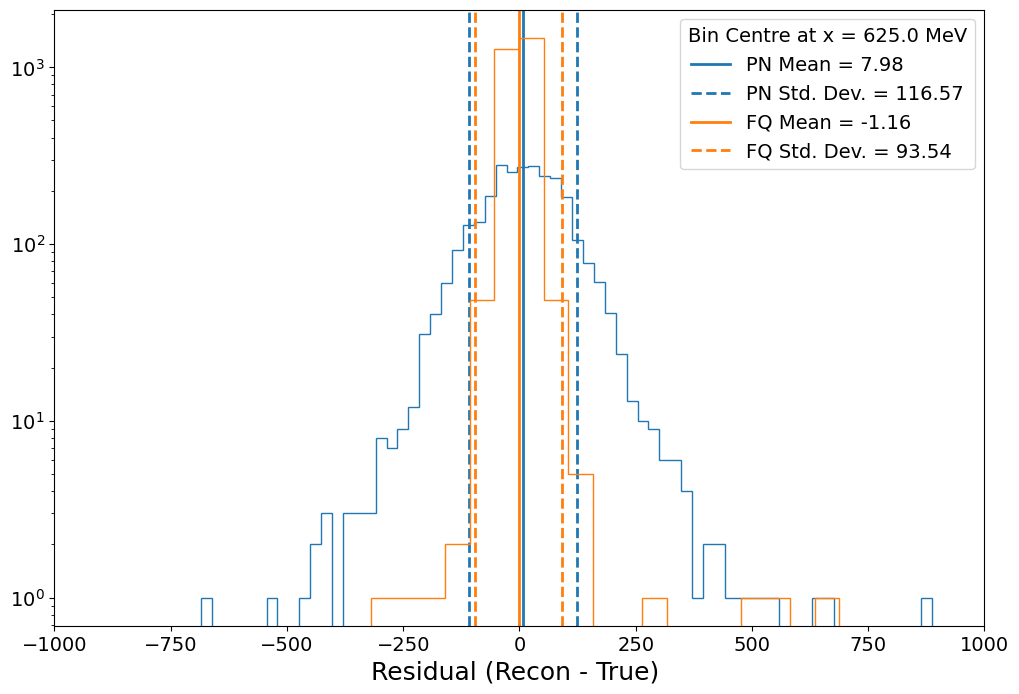

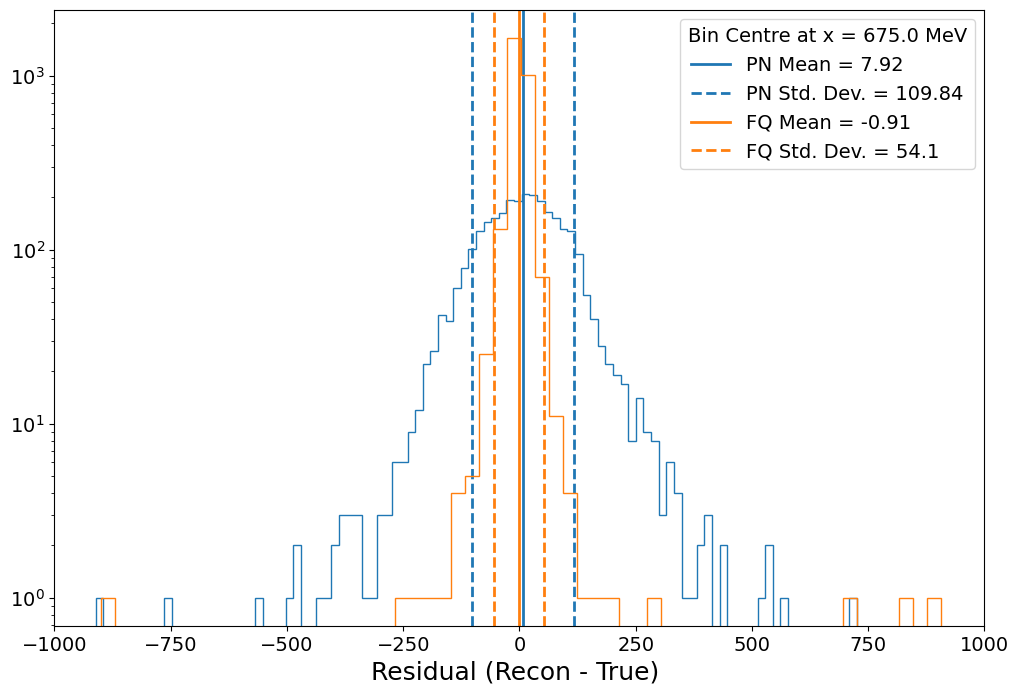

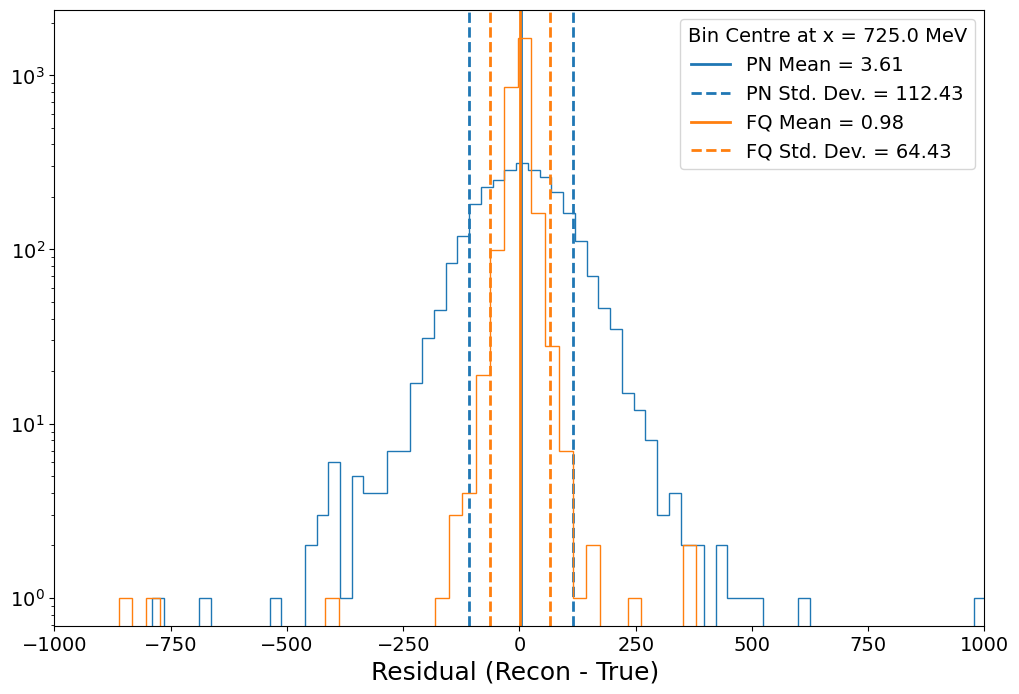

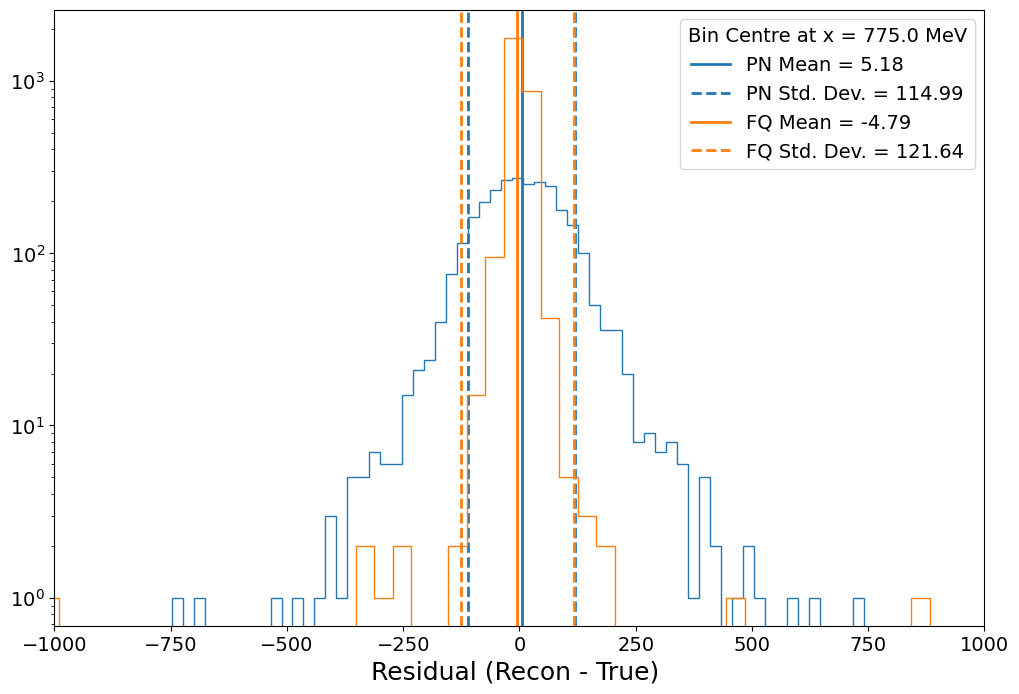

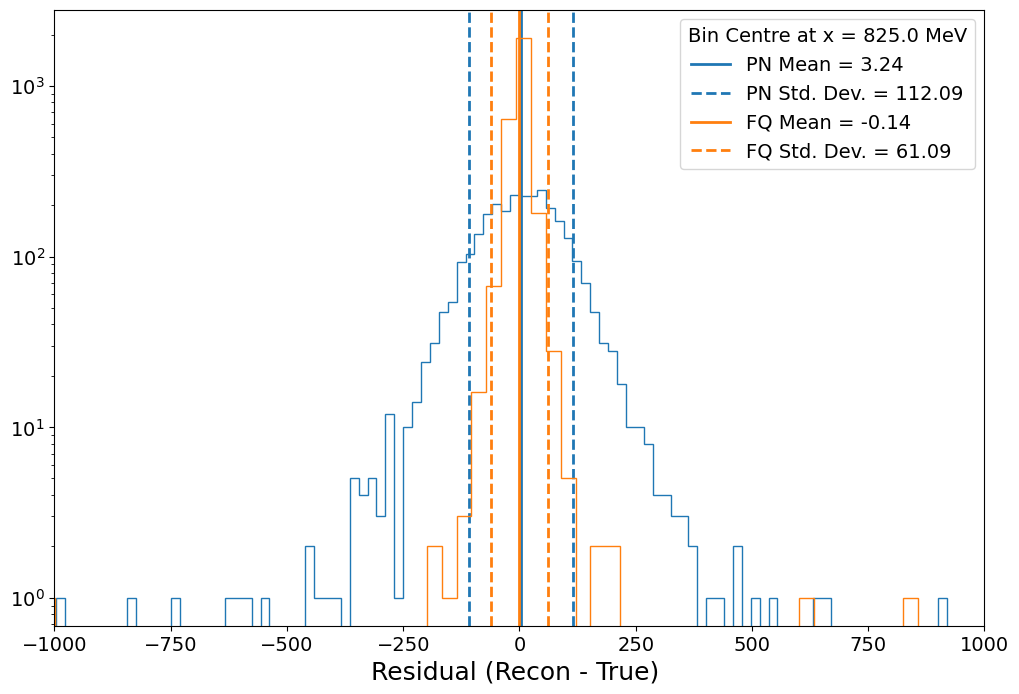

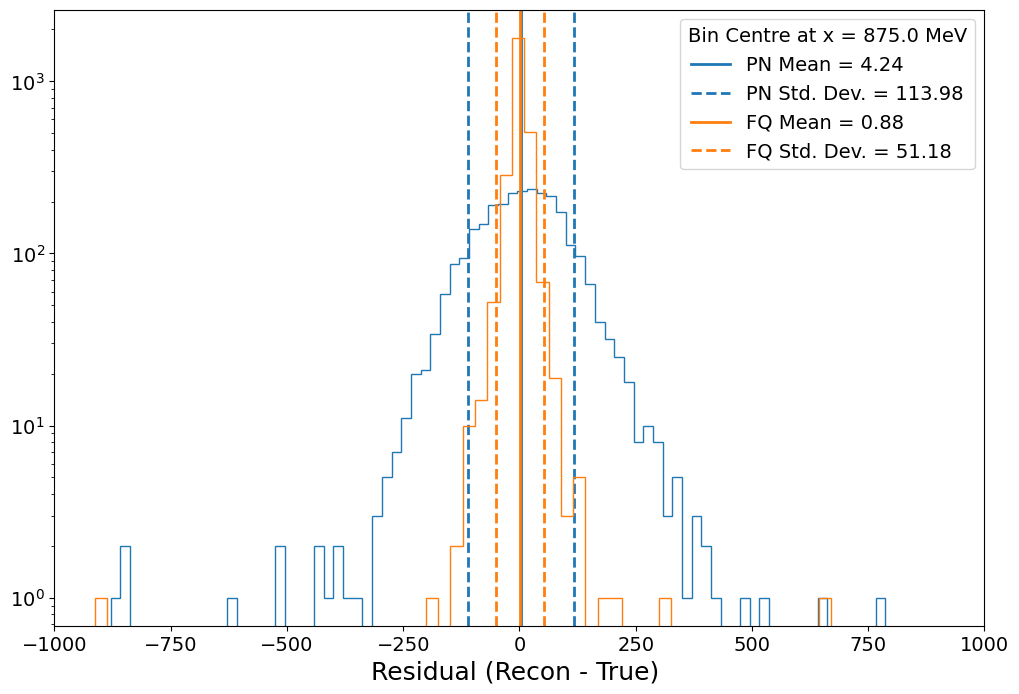

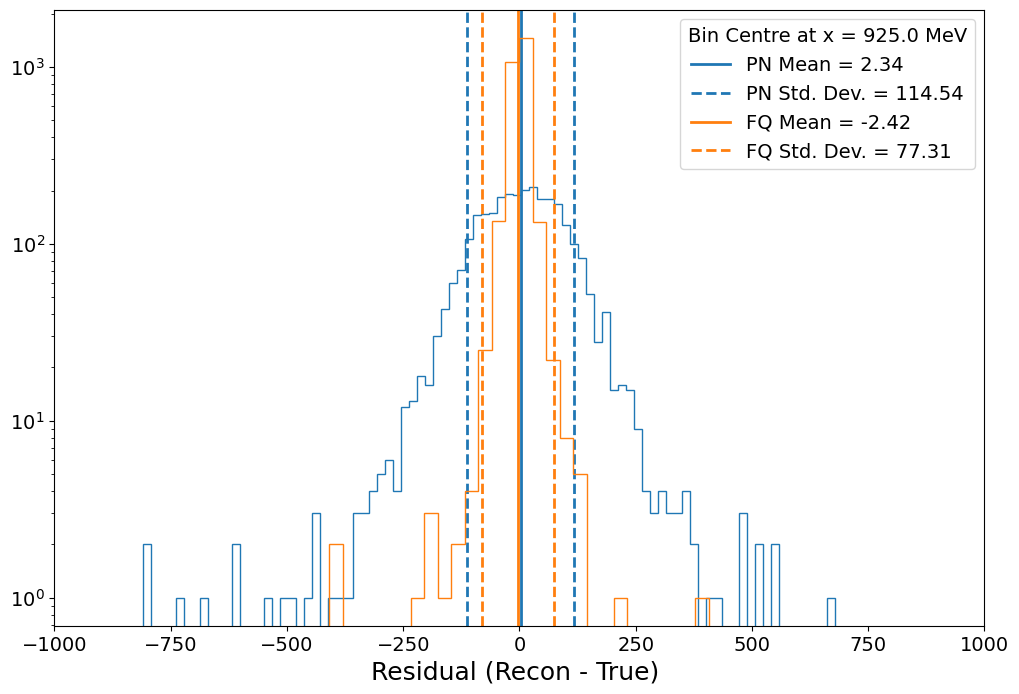

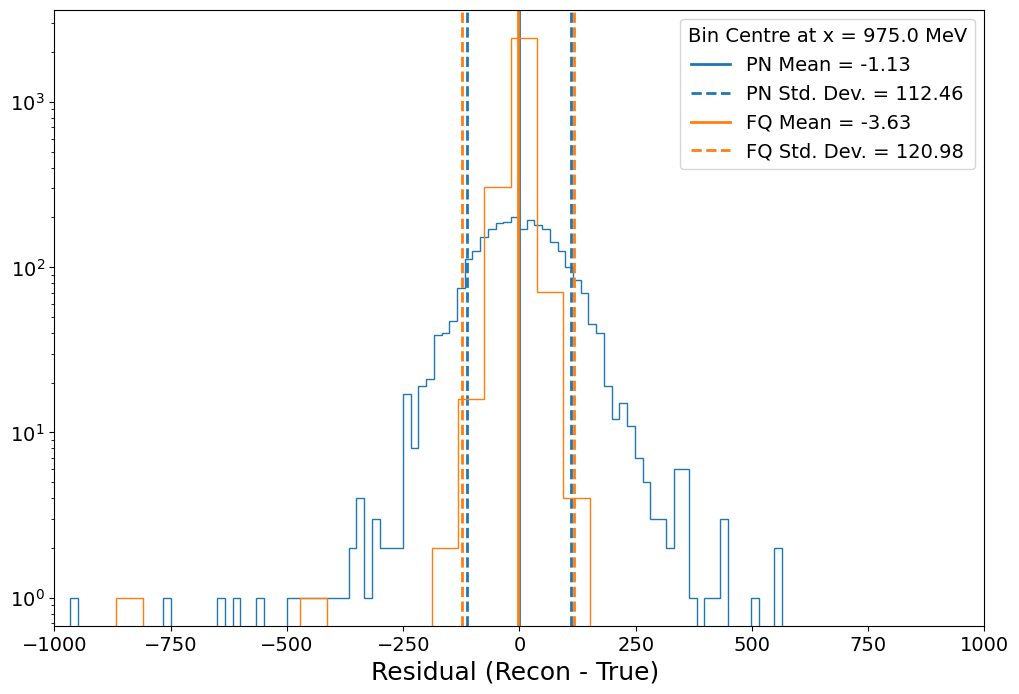

In [43]:
# For plotting out bin contents
hist_content, bin_centers, means, stds = plotting_essentials
for i in range(len(bin_centers)):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.hist(hist_content[0][i], bins=100, histtype='step')
    # Add a line for the mean
    plt.axvline(means[0][i], color='tab:blue', linestyle='-', linewidth=2, label=f'PN Mean = {means[0][i]}')
    plt.axvline(means[0][i] - stds[0][i], color='tab:blue', linestyle='dashed', linewidth=2, label=f'PN Std. Dev. = {stds[0][i]}')
    plt.axvline(means[0][i] + stds[0][i], color='tab:blue', linestyle='dashed', linewidth=2)
    
    plt.hist(hist_content[1][i], bins=100, histtype='step')
    plt.axvline(means[1][i], color='tab:orange', linestyle='-', linewidth=2, label=f'FQ Mean = {means[1][i]}')
    plt.axvline(means[1][i] - stds[1][i], color='tab:orange', linestyle='dashed', linewidth=2, label=f'FQ Std. Dev. = {stds[1][i]}')
    plt.axvline(means[1][i] + stds[1][i], color='tab:orange', linestyle='dashed', linewidth=2)
    
    plt.xlabel('Residual (Recon - True) ', fontsize=18)
    plt.xlim(-1000,1000)
    plt.legend(title=f'Bin Centre at x = {bin_centers[i]} MeV', fontsize=14, title_fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.yscale('log')
#     plt.savefig(f'true_x_normalised_bin_{i}.png')

### Against Various Vertex Positions

In [22]:
# making yet another cut because the PN sucks at reconstruting low energy stuff (<100MeV), and it skews the
# E resolution for all other true variables apart from true mom
if particle_names[0] == 'e-':
    lowe_event_idxs = np.where(h5_energies[good_events1] < 100)[0]
elif particle_names[0] == 'mu-':
    lowe_event_idxs = np.where(h5_energies[good_events1] < 261)[0]
good_events2 = np.delete(good_events1, lowe_event_idxs)

good_true_energies     = h5_energies[good_events2]
good_ml_recon_pos      = recon_positions[0][good_events2]
good_true_positions    = h5_positions[good_events2]
good_angles            = h5_angles[good_events2]
good_vetos             = h5_vetos[good_events2]
good_labels            = h5_labels[good_events2]
good_idxs              = indices[0][good_events2]

if particle_names[0] == 'e-':
    good_fq_recon_pos = fq_reco_pos_e[good_events2]
elif particle_names[0] == 'mu-':
    good_fq_recon_pos = fq_reco_pos_mu[good_events2]

In [23]:
r_3d = np.sqrt(good_true_positions[:,0]**2 + good_true_positions[:,1]**2 + good_true_positions[:,2]**2)
dist_diff_3d_ml = np.sqrt((good_ml_recon_pos[:,0] - good_true_positions[:,0])**2 
                          + (good_ml_recon_pos[:,1] - good_true_positions[:,1])**2 
                          + (good_ml_recon_pos[:,2] - good_true_positions[:,2])**2)

dist_diff_3d_fq = np.sqrt((good_fq_recon_pos[:,0] - good_true_positions[:,0])**2 
                          + (good_fq_recon_pos[:,1] - good_true_positions[:,1])**2 
                          + (good_fq_recon_pos[:,2] - good_true_positions[:,2])**2)

In [24]:
# Producing more position related variables
# need to overwrite the tank_half_height and tank_radius parameters that towall and dwall funcs takes in
# The length unit is mm and the the lengths are the dimentions of the ID, so HK ID tank is 32.4m (?) in radius
# and 65.8 m (?) in height. Note the half height is 32.9 m.
towall = ev.towall(good_true_positions, good_angles, tank_half_height=3287, tank_radius=3240, tank_axis=2)
dwall = ev.dwall(good_true_positions, tank_half_height=3287, tank_radius=3240, tank_axis=2)
momentum = ev.momentum(good_true_energies, good_labels)

#### x resolution

<Figure size 640x480 with 0 Axes>

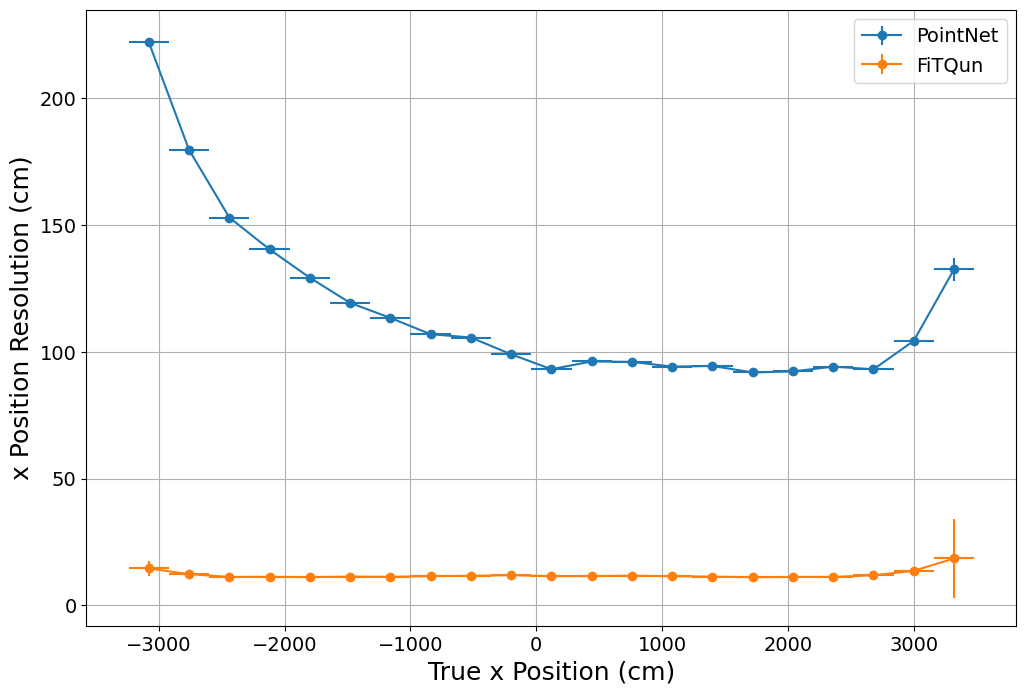

<Figure size 640x480 with 0 Axes>

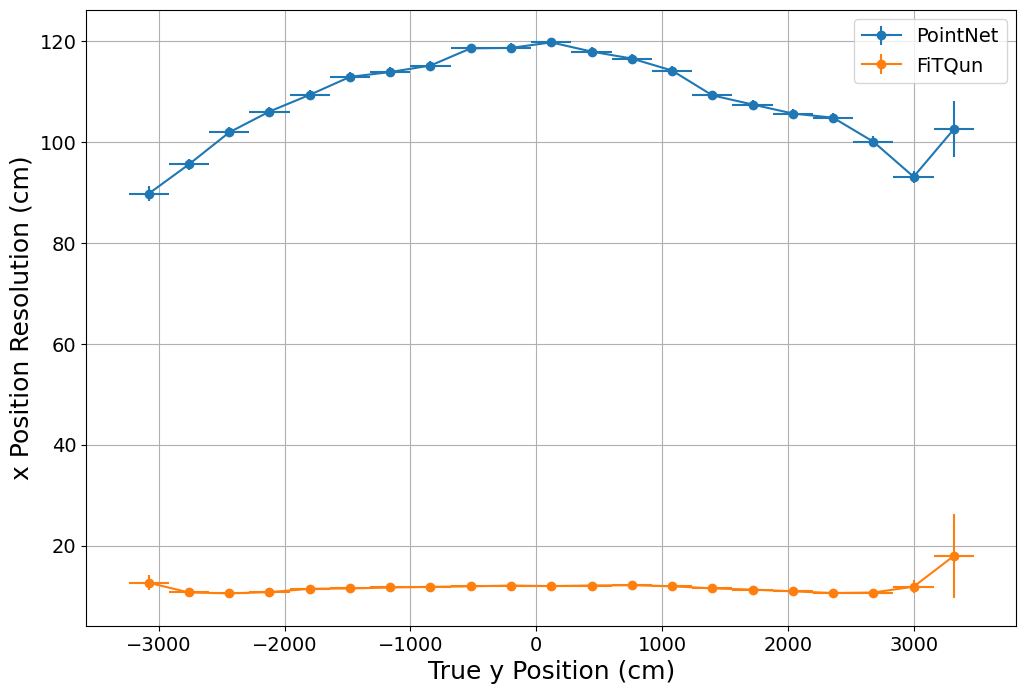

<Figure size 640x480 with 0 Axes>

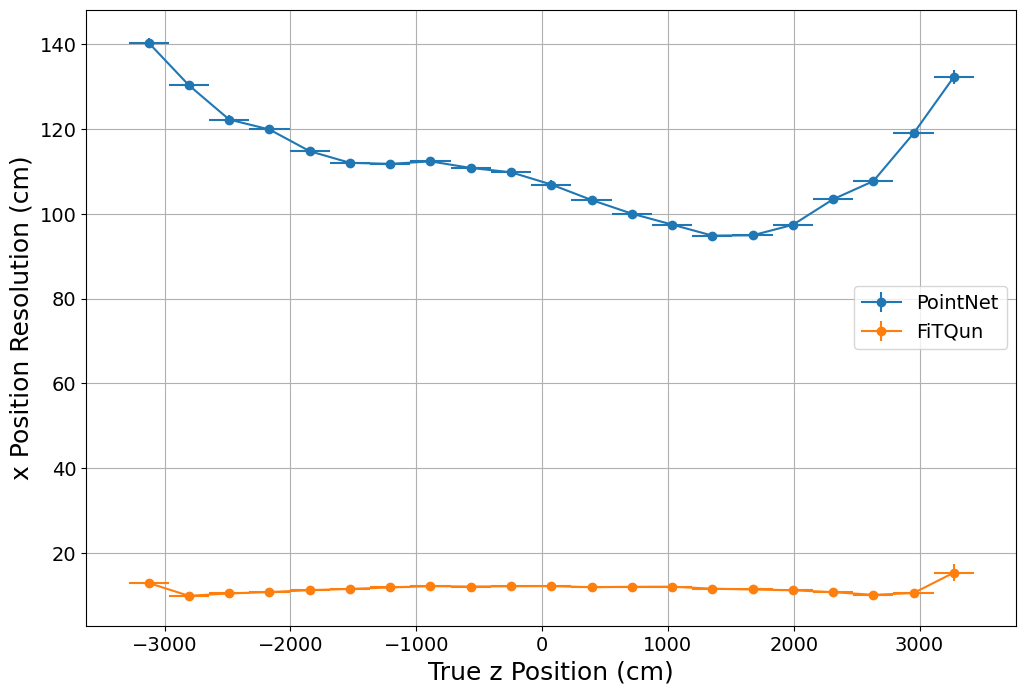

<Figure size 640x480 with 0 Axes>

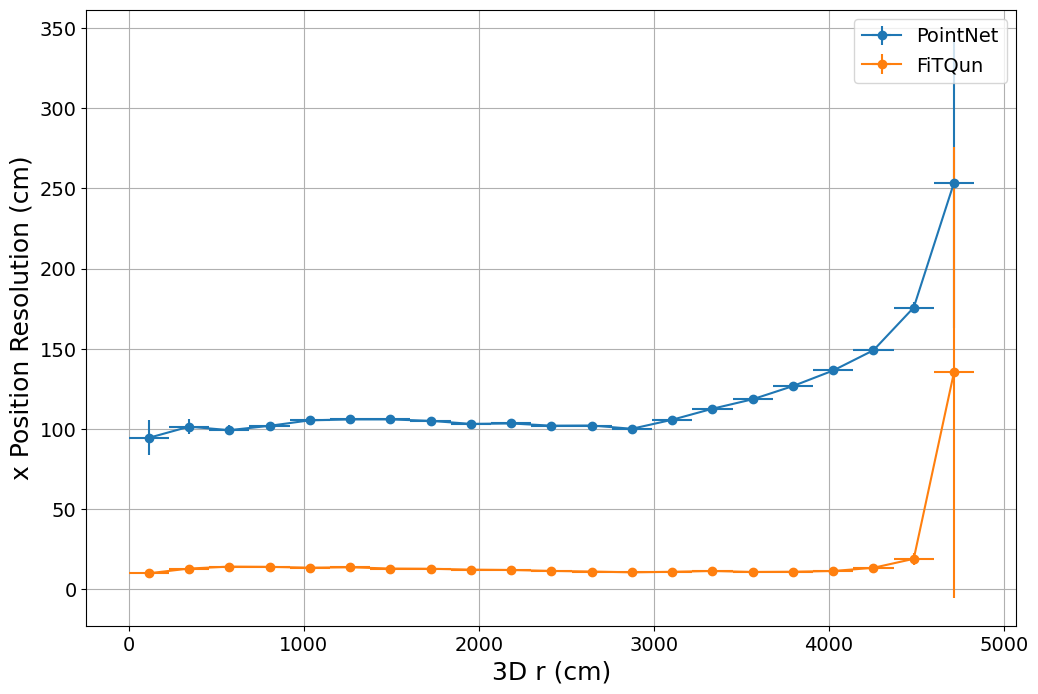

In [87]:
# As a function of x, y, z
# # against x, bin width 324 cm -> 20 bins
plot_against_true_variable(good_true_positions[:,0], [good_ml_recon_pos[:,0], good_fq_recon_pos[:,0]],
                           good_true_positions[:,0], recon_type, ['PointNet', 'FiTQun'], 'x', 
                           [-3240, 3240], 320, title='x')
# against y, 20 bins
plot_against_true_variable(good_true_positions[:,0], [good_ml_recon_pos[:,0], good_fq_recon_pos[:,0]],
                           good_true_positions[:,1], recon_type, ['PointNet', 'FiTQun'], 'y',
                           [-3240, 3240], 320, title='x')
# against z, 20 bins
plot_against_true_variable(good_true_positions[:,0], [good_ml_recon_pos[:,0], good_fq_recon_pos[:,0]],
                           good_true_positions[:,2], recon_type, ['PointNet', 'FiTQun'], 'z',
                           [-3287, 3287], 320, title='x')

# The E resolution vs a single dim didn't look great. Trying to plot against r = sqrt(x^2+y^2+z^2)
plot_against_true_variable(good_true_positions[:,0], [good_ml_recon_pos[:,0], good_fq_recon_pos[:,0]], r_3d, 
                           recon_type, ['PointNet', 'FiTQun'], '3D r (cm)', [0., round(max(r_3d),0)+1], 
                           230., title='x')

<Figure size 640x480 with 0 Axes>

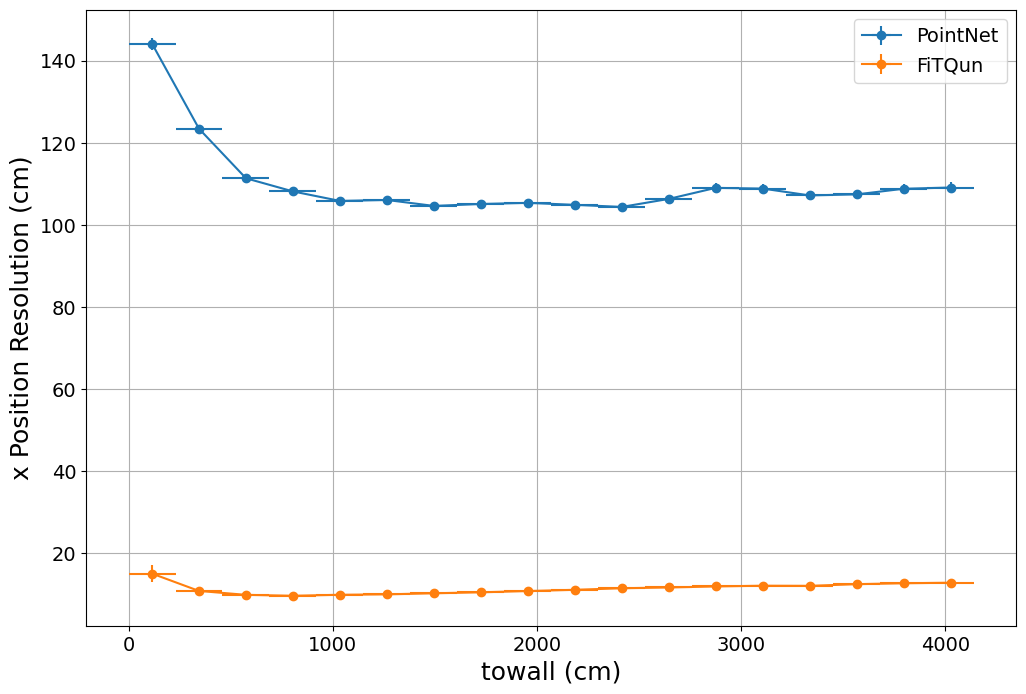

In [90]:
plot_against_true_variable(good_true_positions[:,0], [good_ml_recon_pos[:,0], good_fq_recon_pos[:,0]], towall,
                           recon_type, ['PointNet', 'FiTQun'], 'towall', [0., round(max(towall),0)+1], 
                           230., title='x')
plot_against_true_variable(good_true_positions[:,0], [good_ml_recon_pos[:,0], good_fq_recon_pos[:,0]], dwall, 
                           recon_type, ['PointNet', 'FiTQun'], 'dwall', [0., round(max(dwall),0)+1],
                           230., title='x')

#### y resolution

<Figure size 640x480 with 0 Axes>

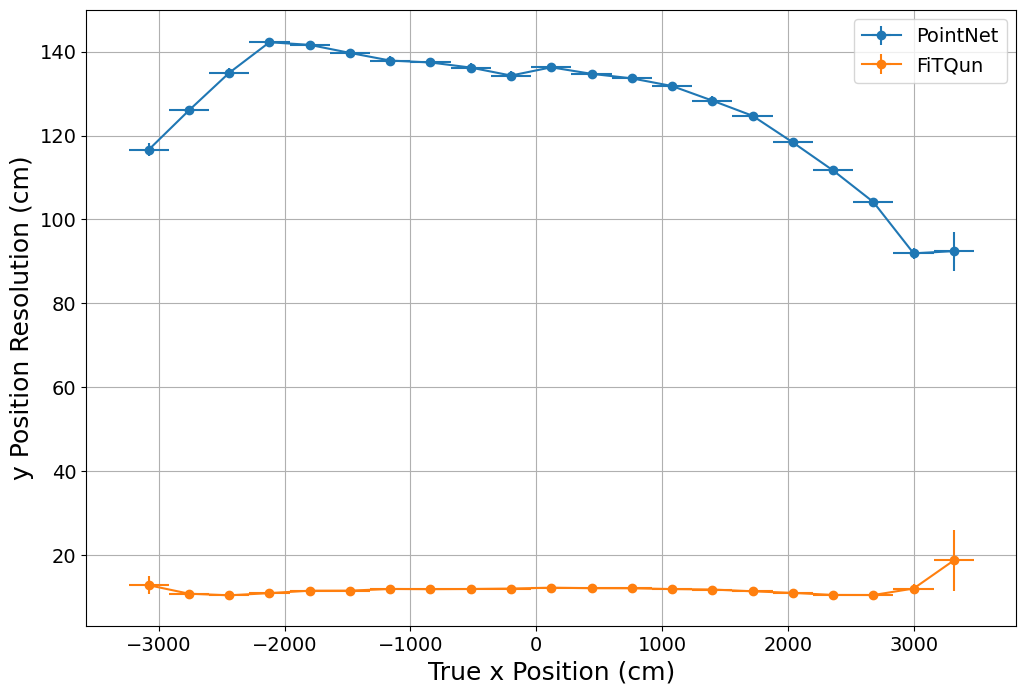

<Figure size 640x480 with 0 Axes>

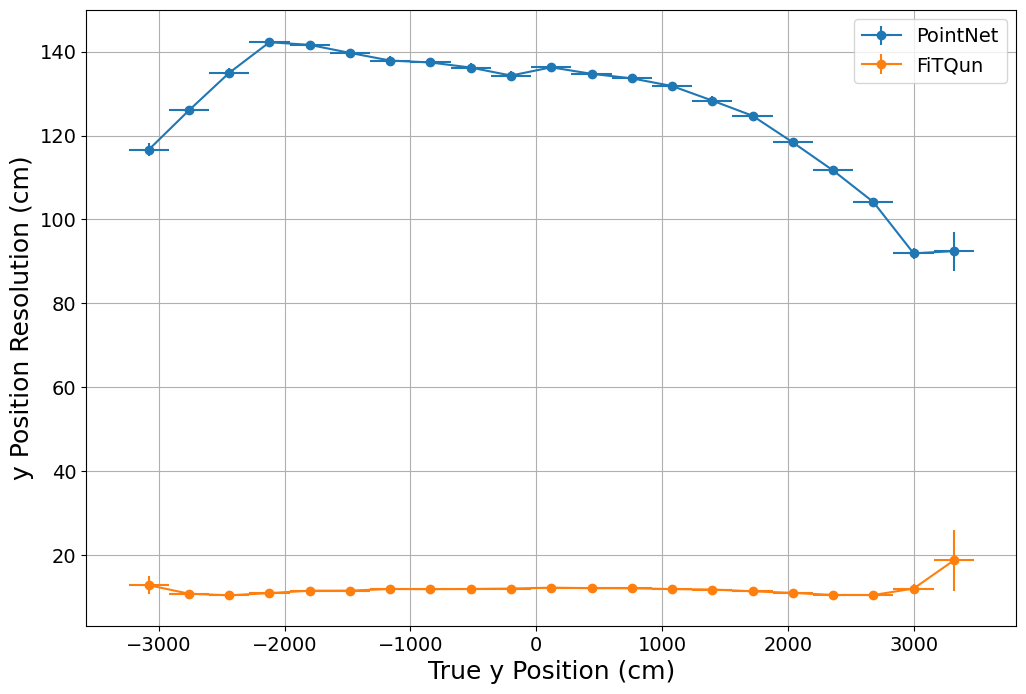

<Figure size 640x480 with 0 Axes>

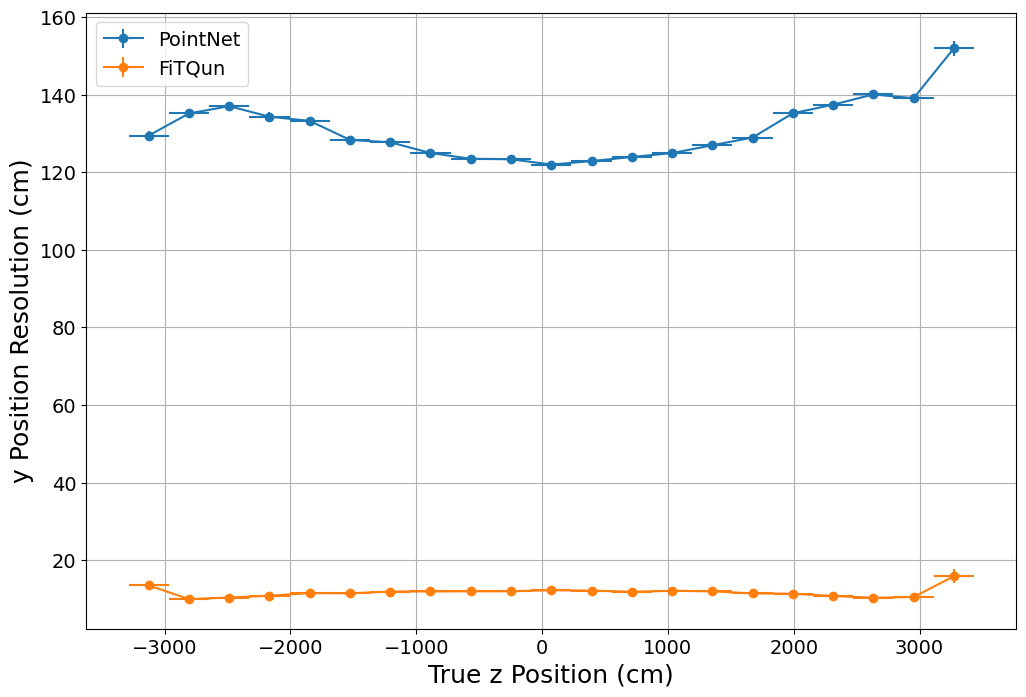

<Figure size 640x480 with 0 Axes>

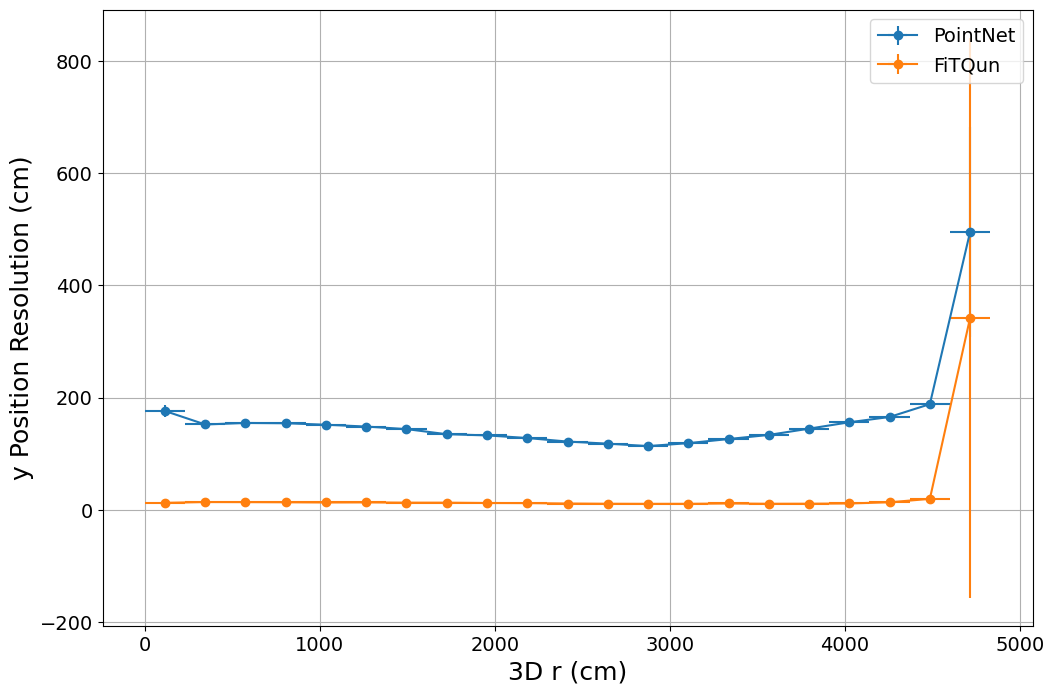

In [91]:
# As a function of x, y, z
# # against x, bin width 324 cm -> 20 bins
plot_against_true_variable(good_true_positions[:,1], [good_ml_recon_pos[:,1], good_fq_recon_pos[:,1]],
                           good_true_positions[:,0], recon_type, ['PointNet', 'FiTQun'], 'x', 
                           [-3240, 3240], 320, title='y')
# against y, 20 bins
plot_against_true_variable(good_true_positions[:,1], [good_ml_recon_pos[:,1], good_fq_recon_pos[:,1]],
                           good_true_positions[:,0], recon_type, ['PointNet', 'FiTQun'], 'y', 
                           [-3240, 3240], 320, title='y')
# against z, 20 bins
plot_against_true_variable(good_true_positions[:,1], [good_ml_recon_pos[:,1], good_fq_recon_pos[:,1]],
                           good_true_positions[:,2], recon_type, ['PointNet', 'FiTQun'], 'z',
                           [-3287, 3287], 320, title='y')

# The E resolution vs a single dim didn't look great. Trying to plot against r = sqrt(x^2+y^2+z^2)
plot_against_true_variable(good_true_positions[:,1], [good_ml_recon_pos[:,1], good_fq_recon_pos[:,1]], r_3d, 
                           recon_type, ['PointNet', 'FiTQun'], '3D r (cm)', [0., round(max(r_3d),0)+1], 
                           230., title='y')

<Figure size 640x480 with 0 Axes>

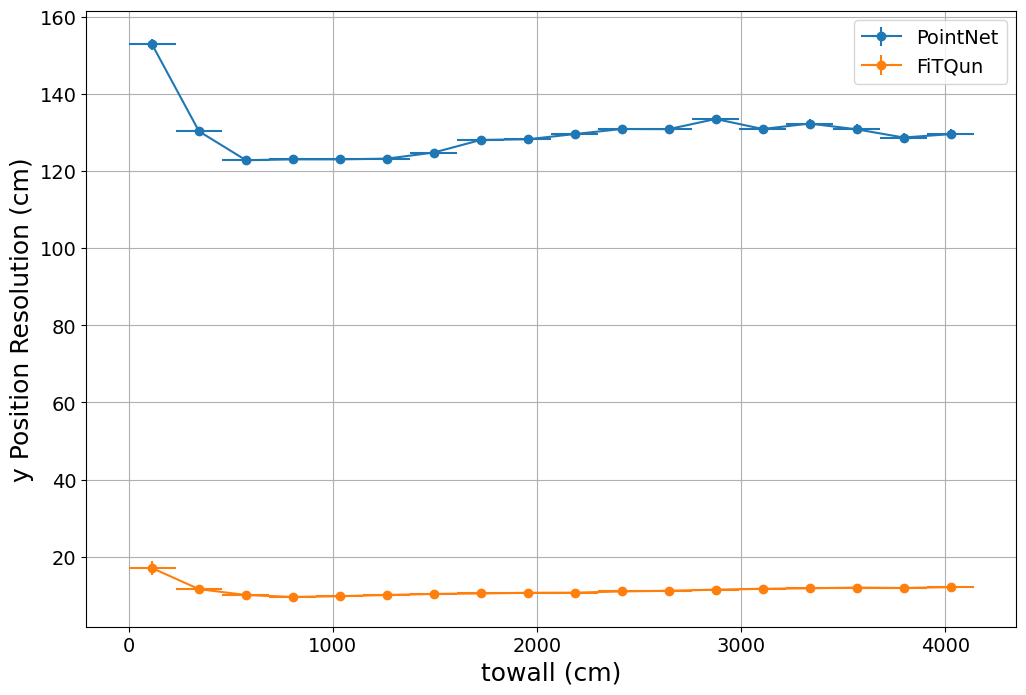

In [93]:
plot_against_true_variable(good_true_positions[:,1], [good_ml_recon_pos[:,1], good_fq_recon_pos[:,1]], towall,
                           recon_type, ['PointNet', 'FiTQun'], 'towall', [0., round(max(towall),0)+1], 
                           230., title='y')
plot_against_true_variable(good_true_positions[:,1], [good_ml_recon_pos[:,1], good_fq_recon_pos[:,1]], dwall, 
                           recon_type, ['PointNet', 'FiTQun'], 'dwall', [0., round(max(dwall),0)+1],
                           230., title='y')

#### z resolution

<Figure size 640x480 with 0 Axes>

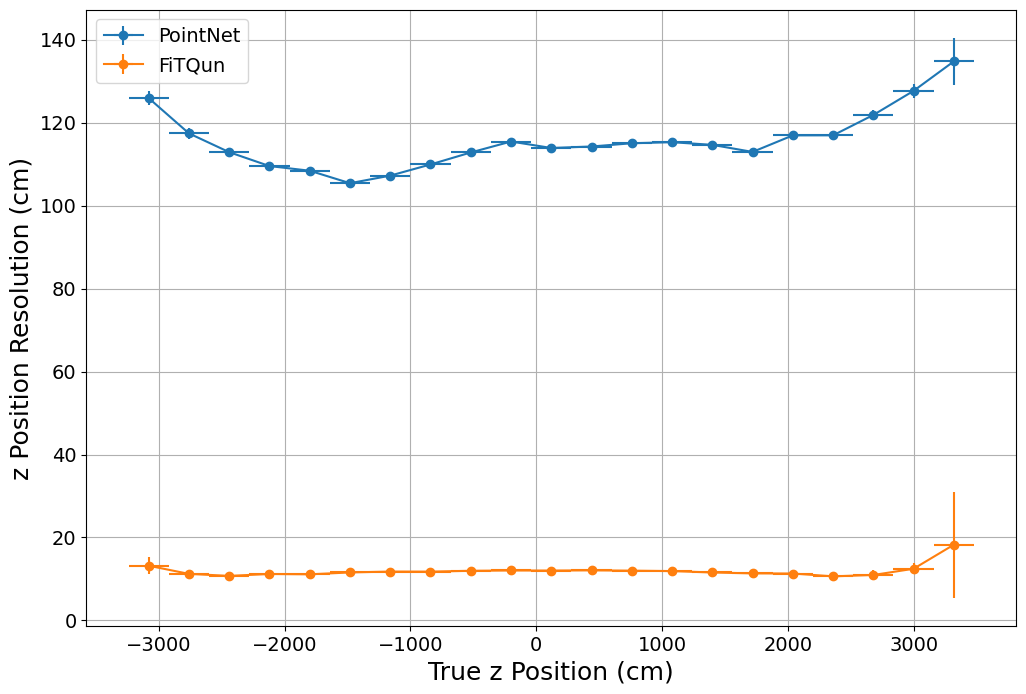

<Figure size 640x480 with 0 Axes>

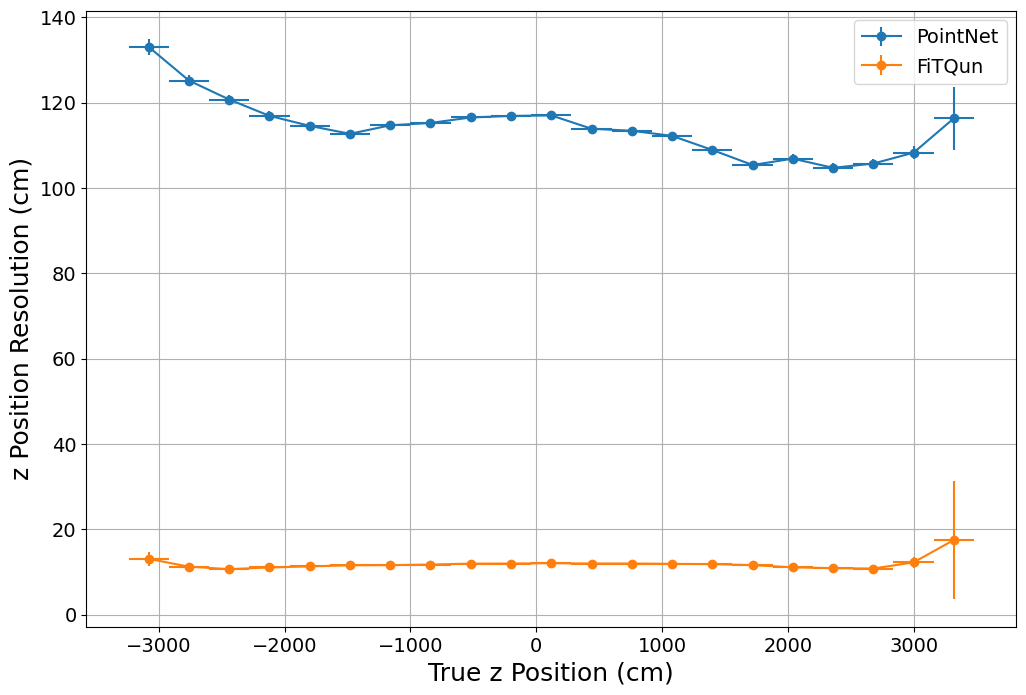

<Figure size 640x480 with 0 Axes>

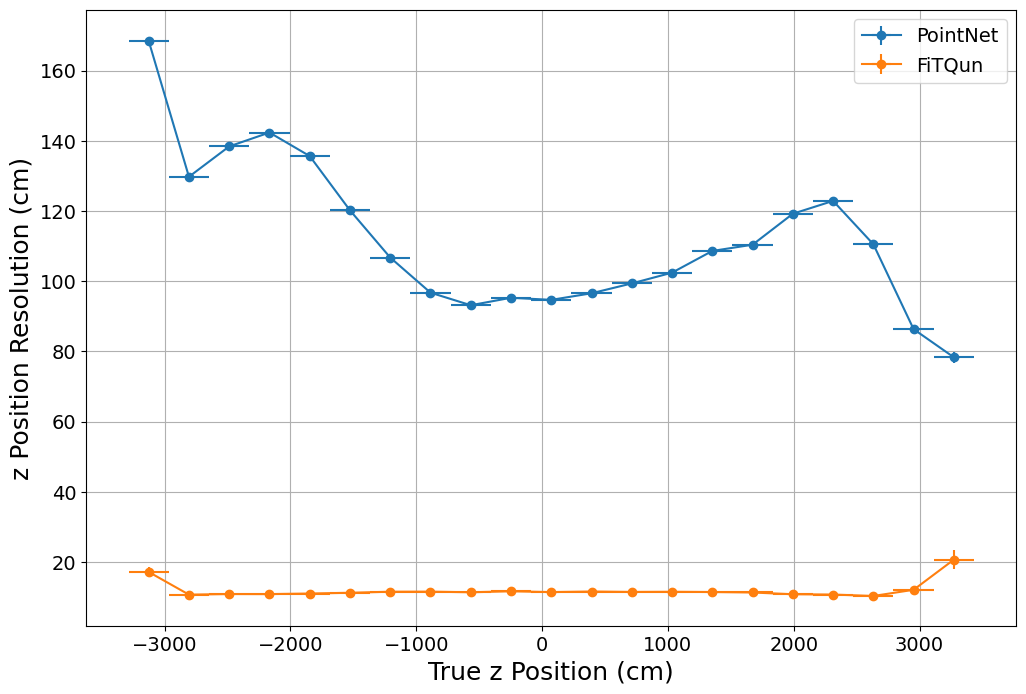

<Figure size 640x480 with 0 Axes>

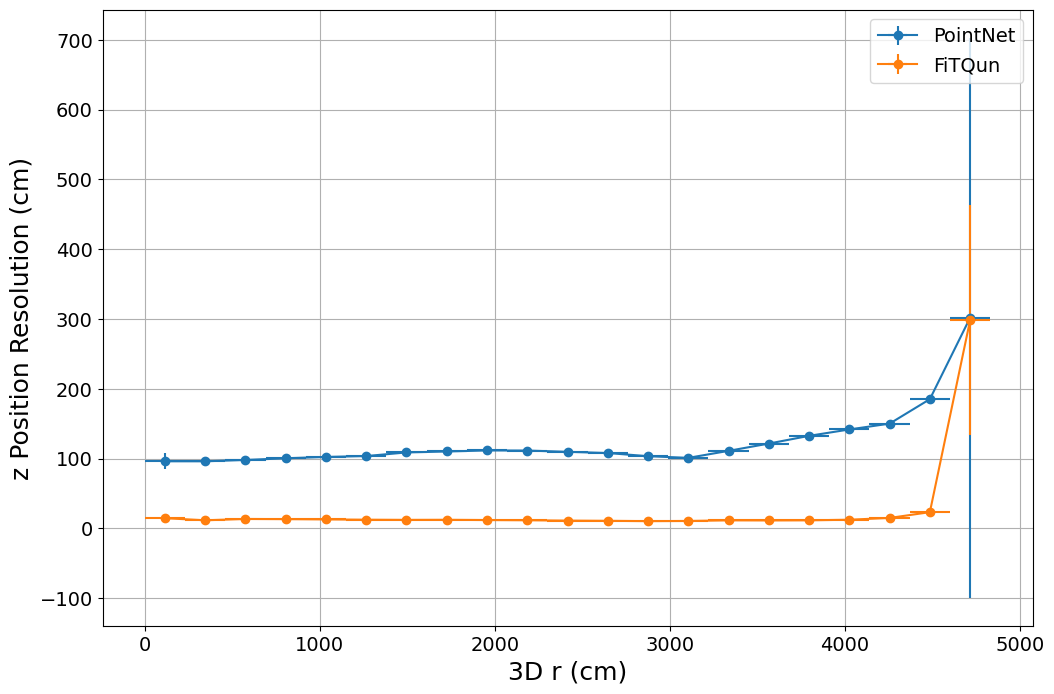

In [94]:
# As a function of x, y, z
# # against x, bin width 324 cm -> 20 bins
plot_against_true_variable(good_true_positions[:,2], [good_ml_recon_pos[:,2], good_fq_recon_pos[:,2]],
                           good_true_positions[:,0], recon_type, ['PointNet', 'FiTQun'], 'z', 
                           [-3240, 3240], 320, title='z')
# against y, 20 bins
plot_against_true_variable(good_true_positions[:,2], [good_ml_recon_pos[:,2], good_fq_recon_pos[:,2]],
                           good_true_positions[:,1], recon_type, ['PointNet', 'FiTQun'], 'z',
                           [-3240, 3240], 320, title='z')
# against z, 20 bins
plot_against_true_variable(good_true_positions[:,2], [good_ml_recon_pos[:,2], good_fq_recon_pos[:,2]],
                           good_true_positions[:,2], recon_type, ['PointNet', 'FiTQun'], 'z',
                           [-3287, 3287], 320, title='z')

# The E resolution vs a single dim didn't look great. Trying to plot against r = sqrt(x^2+y^2+z^2)
plot_against_true_variable(good_true_positions[:,2], [good_ml_recon_pos[:,2], good_fq_recon_pos[:,2]], r_3d, 
                           recon_type, ['PointNet', 'FiTQun'], '3D r (cm)', [0., round(max(r_3d),0)+1], 
                           230., title='z')

<Figure size 640x480 with 0 Axes>

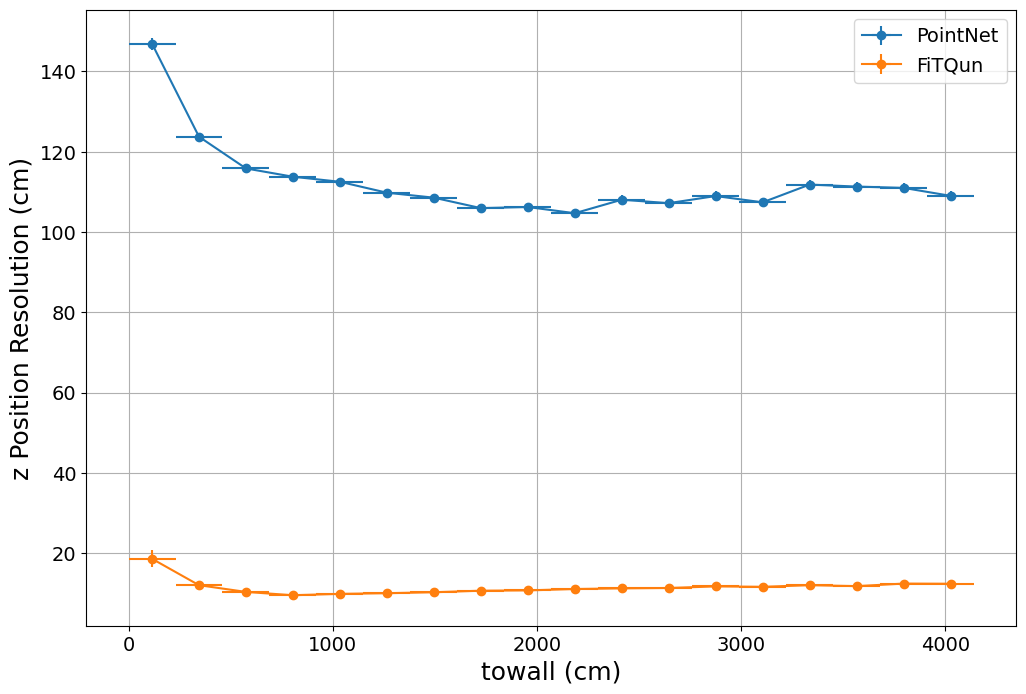

In [96]:
plot_against_true_variable(good_true_positions[:,2], [good_ml_recon_pos[:,2], good_fq_recon_pos[:,2]], towall,
                           recon_type, ['PointNet', 'FiTQun'], 'towall', [0., round(max(towall),0)+1], 
                           230., title='z')
plot_against_true_variable(good_true_positions[:,2], [good_ml_recon_pos[:,2], good_fq_recon_pos[:,2]], dwall, 
                           recon_type, ['PointNet', 'FiTQun'], 'dwall', [0., round(max(dwall),0)+1],
                           230., title='z')

#### 3D r resolution

<Figure size 640x480 with 0 Axes>

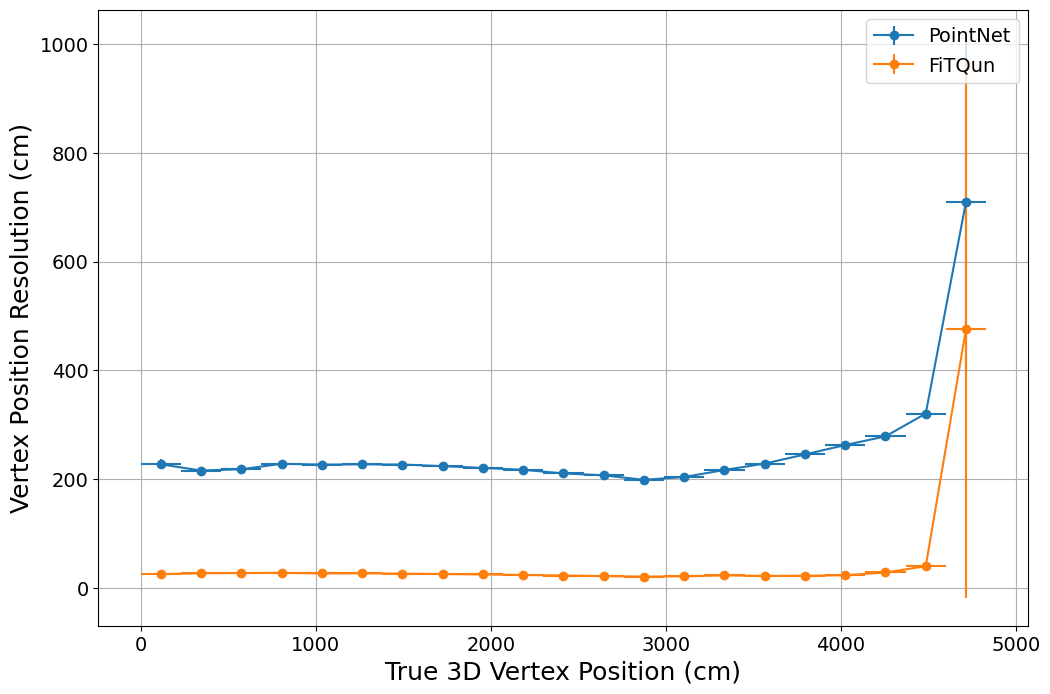

In [26]:
# The E resolution vs a single dim didn't look great. Trying to plot against r = sqrt(x^2+y^2+z^2)
plot_against_true_variable(np.zeros(dist_diff_3d_ml.shape), [dist_diff_3d_ml, dist_diff_3d_fq], r_3d, 
                           recon_type, ['PointNet', 'FiTQun'], 'True 3D Vertex Position (cm)', 
                           [0., round(max(r_3d),0)+1], 230., title='Vertex')

<Figure size 640x480 with 0 Axes>

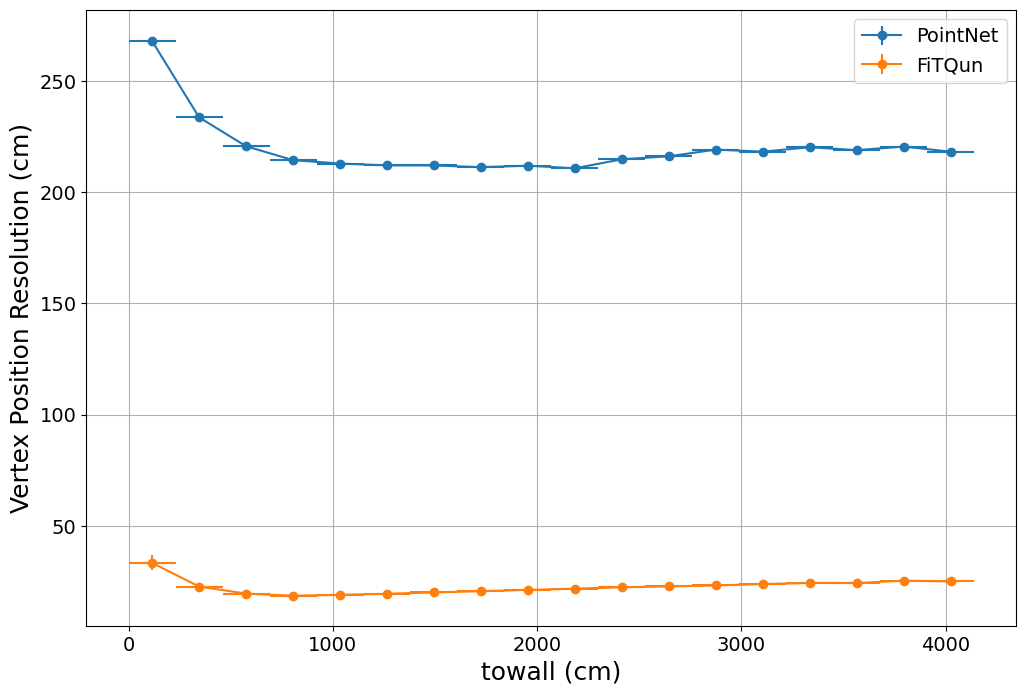

In [28]:
plot_against_true_variable(np.zeros(dist_diff_3d_ml.shape), [dist_diff_3d_ml, dist_diff_3d_fq], towall, 
                           recon_type, ['PointNet', 'FiTQun'], 'towall', [0., 4000.], 230.,
                           title='Vertex')
# plot_against_true_variable(np.zeros(dist_diff_3d_ml.shape), [dist_diff_3d_ml, dist_diff_3d_fq], dwall, 
#                            recon_type, ['PointNet', 'FiTQun'], 'dwall', [0., round(max(dwall),0)+1], 230., 
#                            title='Vertex')

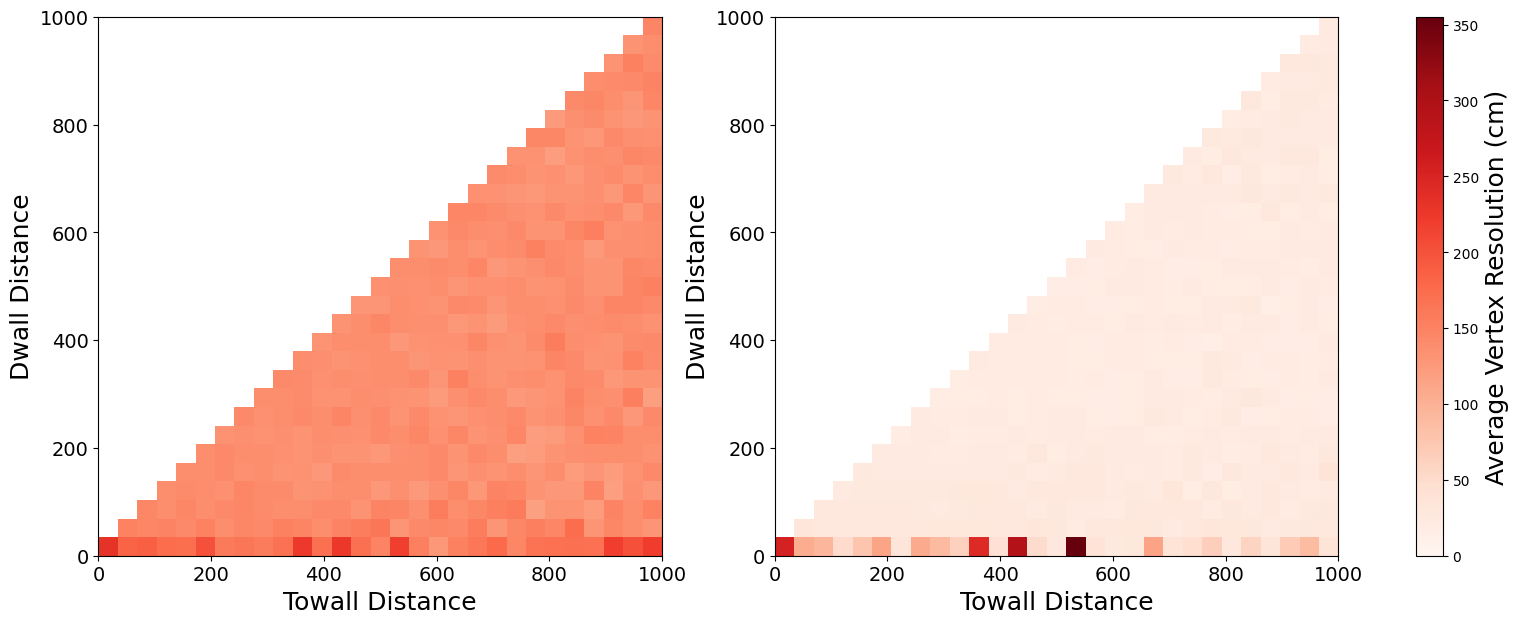

In [39]:
# Plot dwall vs. towall as histo and overlay energy resolution (%)
towall_edges = np.linspace(0., 1000., 30)
dwall_edges = np.linspace(0., 1000., 30)

residuals_ml = abs(dist_diff_3d_ml)
residuals_fq = abs(dist_diff_3d_fq)

pos_res_bin_ml = np.zeros((len(towall_edges)-1, len(dwall_edges)-1))
pos_res_bin_fq = np.zeros((len(towall_edges)-1, len(dwall_edges)-1))


# Fill the array with average energy resolutions
for i in range(len(towall_edges)-1):
    for j in range(len(dwall_edges)-1):
        # Get indices of events in the current bin
        indices = np.where((towall >= towall_edges[i]) & (towall < towall_edges[i+1]) &
                           (dwall >= dwall_edges[j]) & (dwall < dwall_edges[j+1]))

        # Calculate average energy resolution for the bin
        if len(indices[0]) > 0:
            pos_res_bin_ml[i, j] = np.mean(np.take(residuals_ml, indices))
            pos_res_bin_fq[i, j] = np.mean(np.take(residuals_fq, indices))

masked_pos_res_bin_ml = np.ma.masked_where(pos_res_bin_ml == 0, pos_res_bin_ml)
masked_pos_res_bin_fq = np.ma.masked_where(pos_res_bin_fq == 0, pos_res_bin_fq)

# Keep the colour consistent
global_min = min(np.min(pos_res_bin_ml), np.min(pos_res_bin_fq))
global_max = max(np.max(pos_res_bin_ml), np.max(pos_res_bin_fq))

# Create a colormap that sets masked values (zeros) to white
cmap = plt.cm.Reds  # or any colormap you prefer
cmap.set_bad(color='white')

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
# Plot for ML residuals
pc = axs[0].pcolormesh(towall_edges, dwall_edges, masked_pos_res_bin_ml.T, cmap=cmap, shading='auto', 
                       vmin=global_min, vmax=global_max)
axs[0].set_xlabel('Towall Distance', fontsize=18)
axs[0].set_ylabel('Dwall Distance', fontsize=18)
axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)
# axs[0].set_title('PointNet Residuals', fontsize=18)

# Plot for FQ residuals
pc = axs[1].pcolormesh(towall_edges, dwall_edges, masked_pos_res_bin_fq.T, cmap=cmap, shading='auto', 
                       vmin=global_min, vmax=global_max)
axs[1].set_xlabel('Towall Distance', fontsize=18)
axs[1].set_ylabel('Dwall Distance', fontsize=18)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)
# axs[1].set_title('FitQun Residuals', fontsize=18)

# Colorbar
cbar = fig.colorbar(pc, ax=axs.ravel().tolist())
cbar.set_label(label='Average Vertex Resolution (cm)', fontsize=18)

plt.savefig(f'plots/{particle_names[0]}_posResolution_68percentile/\
{particle_names[0]}_vertexResolution_68percentile_FV_compare_100MeVorMore.png')
plt.show()

### Against Angles/Directions

In [29]:
cos_zenith = np.cos(good_angles[:,0])

#### x resolution

<Figure size 640x480 with 0 Axes>

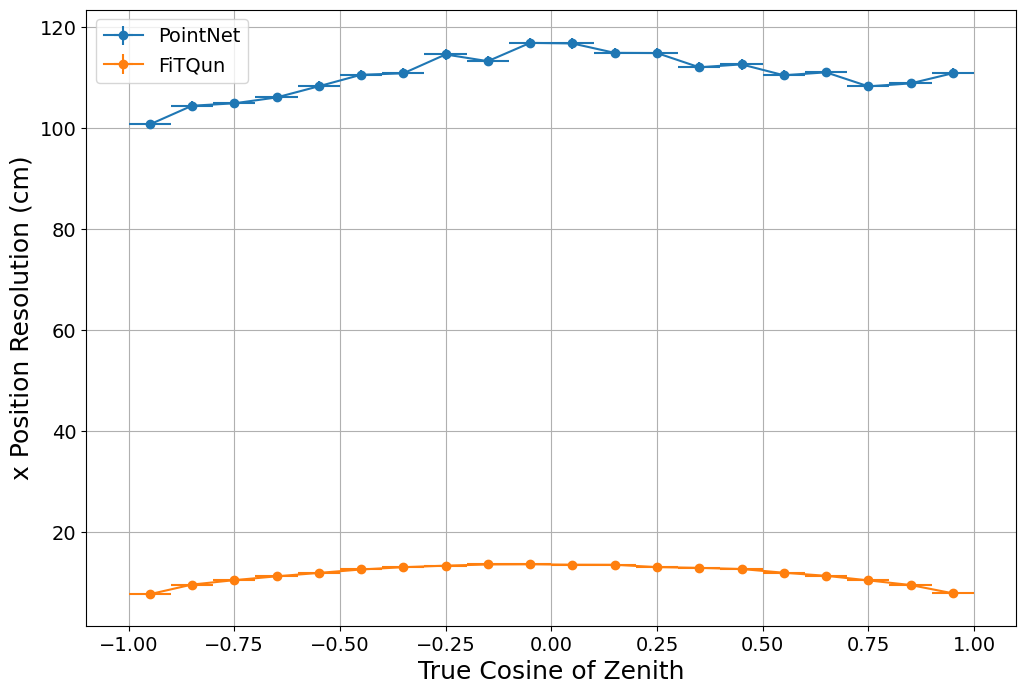

<Figure size 640x480 with 0 Axes>

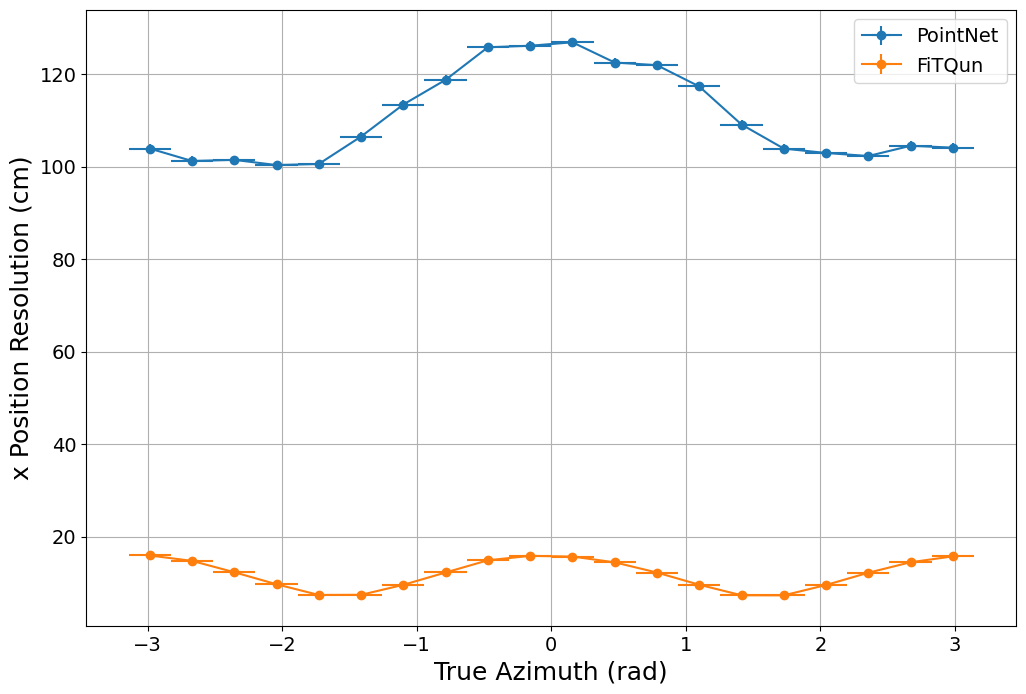

In [103]:
plot_against_true_variable(good_true_positions[:,0], [good_ml_recon_pos[:,0], good_fq_recon_pos[:,0]],
                           cos_zenith, recon_type, ['PointNet', 'FiTQun'], 'Cosine of Zenith', 
                           [-1, 1], 0.1, title='x')
plot_against_true_variable(good_true_positions[:,0], [good_ml_recon_pos[:,0], good_fq_recon_pos[:,0]], 
                           good_angles[:,1], recon_type, ['PointNet', 'FiTQun'], 'Azimuth',
                           [-np.pi, np.pi], np.pi/10, title='x')

#### y resolution

<Figure size 640x480 with 0 Axes>

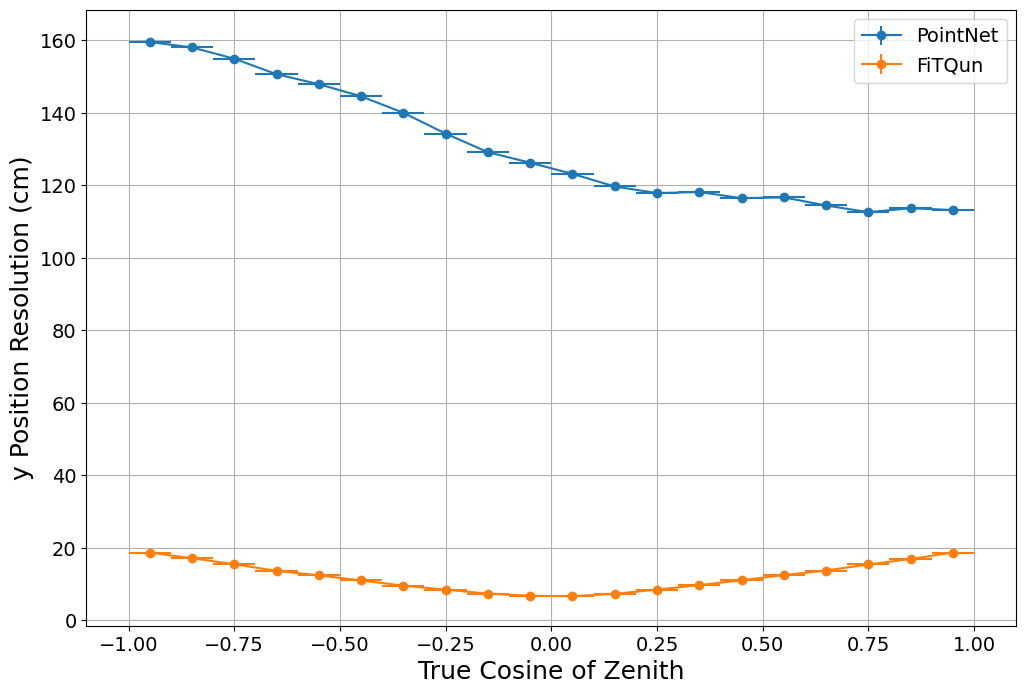

<Figure size 640x480 with 0 Axes>

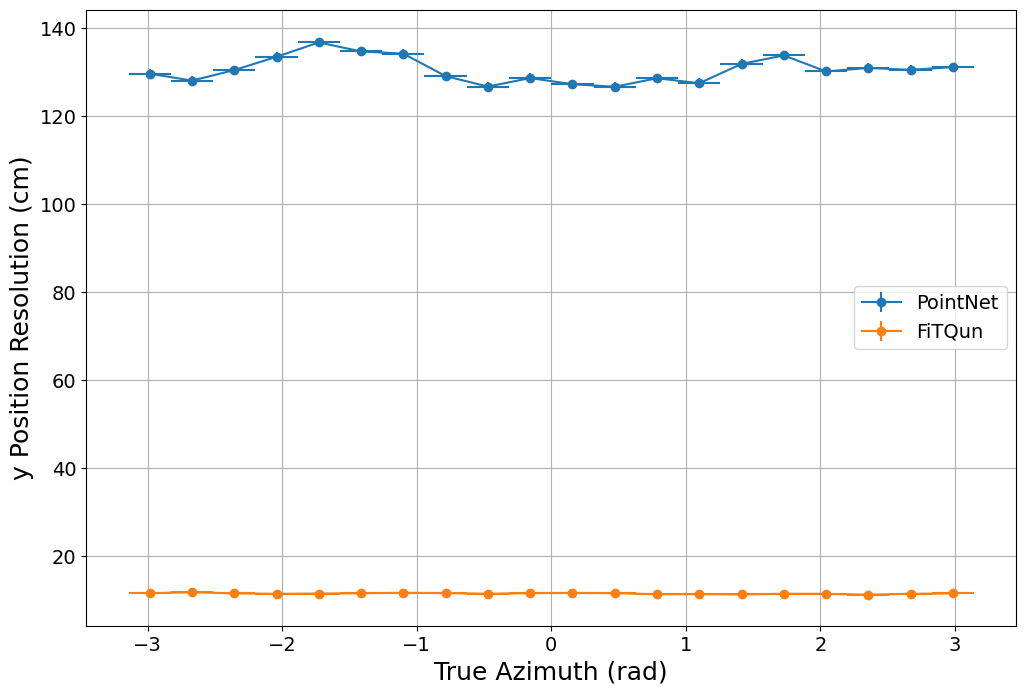

In [104]:
plot_against_true_variable(good_true_positions[:,1], [good_ml_recon_pos[:,1], good_fq_recon_pos[:,1]],
                           cos_zenith, recon_type, ['PointNet', 'FiTQun'], 'Cosine of Zenith', 
                           [-1, 1], 0.1, title='y')
plot_against_true_variable(good_true_positions[:,1], [good_ml_recon_pos[:,1], good_fq_recon_pos[:,1]], 
                           good_angles[:,1], recon_type, ['PointNet', 'FiTQun'], 'Azimuth',
                           [-np.pi, np.pi], np.pi/10, title='y')

#### z resolution

<Figure size 640x480 with 0 Axes>

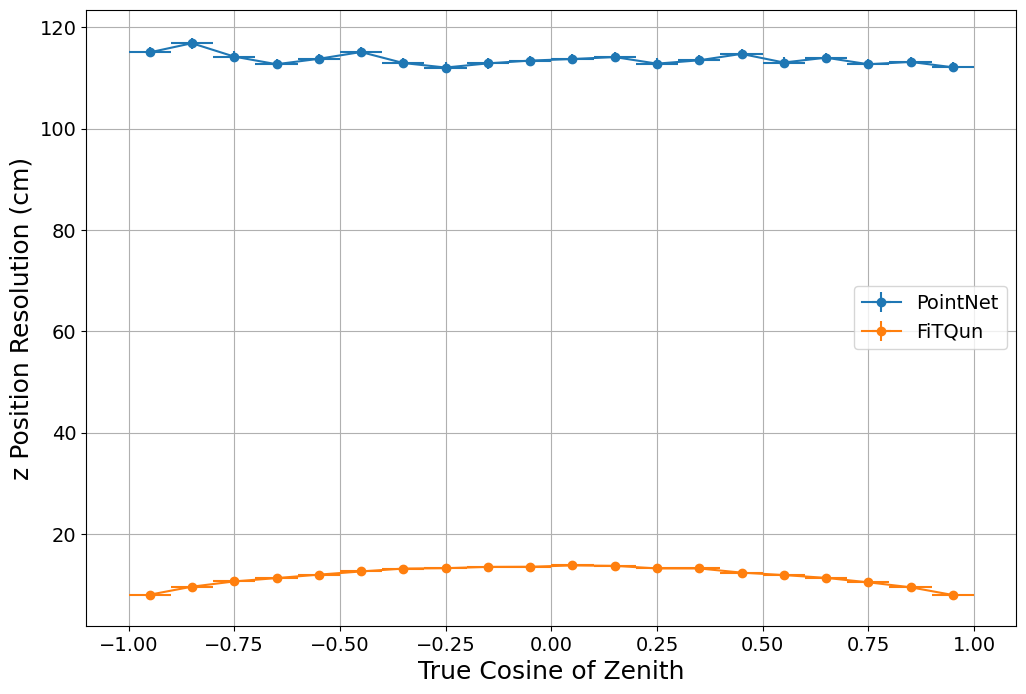

<Figure size 640x480 with 0 Axes>

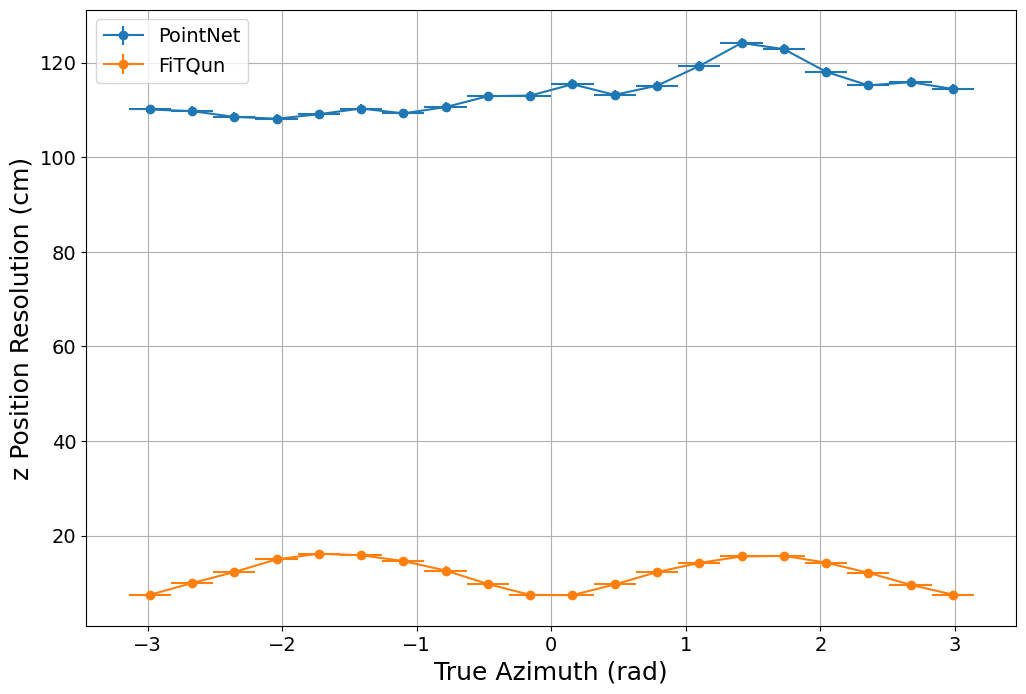

In [105]:
plot_against_true_variable(good_true_positions[:,2], [good_ml_recon_pos[:,2], good_fq_recon_pos[:,2]],
                           cos_zenith, recon_type, ['PointNet', 'FiTQun'], 'Cosine of Zenith', 
                           [-1, 1], 0.1, title='z')
plot_against_true_variable(good_true_positions[:,2], [good_ml_recon_pos[:,2], good_fq_recon_pos[:,2]], 
                           good_angles[:,1], recon_type, ['PointNet', 'FiTQun'], 'Azimuth',
                           [-np.pi, np.pi], np.pi/10, title='z')

<Figure size 640x480 with 0 Axes>

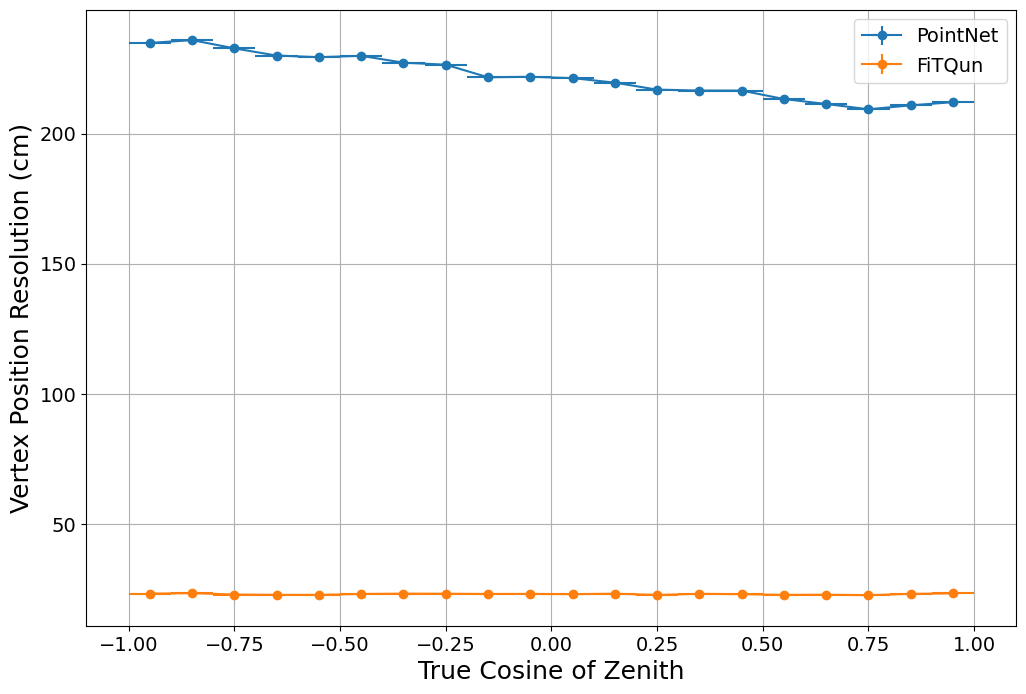

<Figure size 640x480 with 0 Axes>

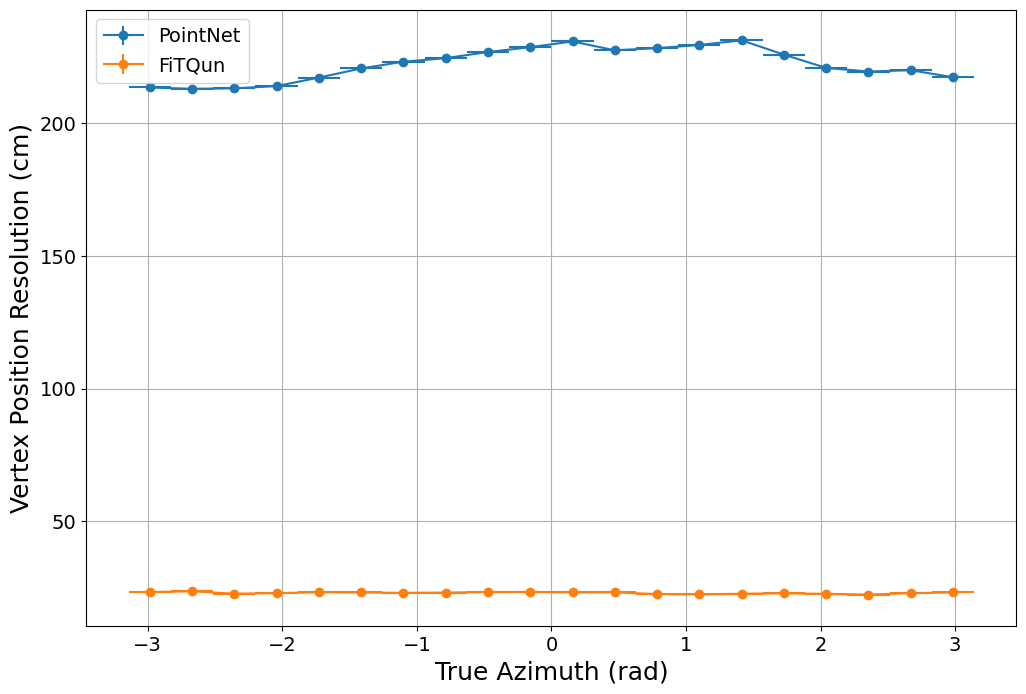

In [30]:
plot_against_true_variable(np.zeros(dist_diff_3d_ml.shape), [dist_diff_3d_ml, dist_diff_3d_fq], cos_zenith, 
                           recon_type, ['PointNet', 'FiTQun'], 'Cosine of Zenith', [-1, 1], 0.1, title='Vertex')
plot_against_true_variable(np.zeros(dist_diff_3d_ml.shape), [dist_diff_3d_ml, dist_diff_3d_fq], good_angles[:,1],
                           recon_type, ['PointNet', 'FiTQun'], 'Azimuth', [-np.pi, np.pi], np.pi/10, title='Vertex')

# Below are obselete code

In [7]:
# Calculate residual
residual = regression_target[0][:,dim_dict[dim]] - regression_prediction[0][:,dim_dict[dim]]


KeyboardInterrupt



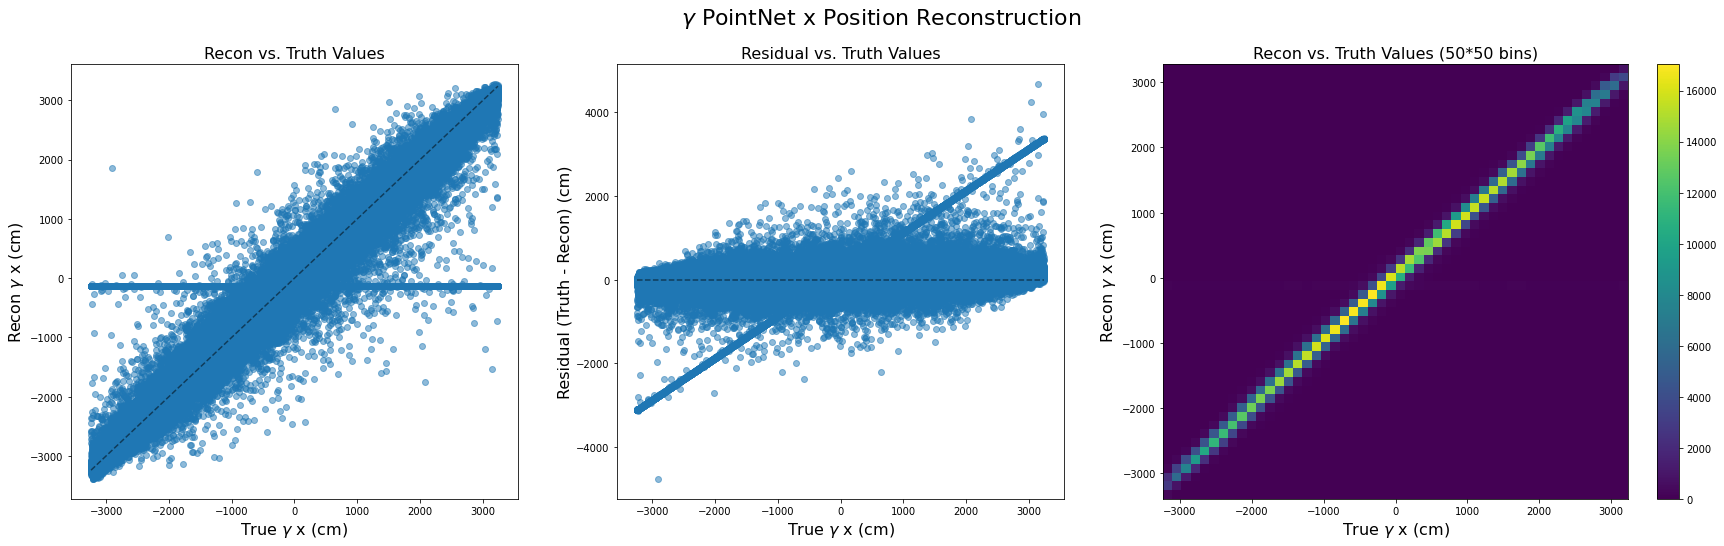

In [8]:
min_val = min(regression_target[0][:,dim_dict[dim]])
max_val = max(regression_target[0][:,dim_dict[dim]])
ref_x = [min_val, max_val]
ref_y = [min_val, max_val]

fig, axs = plt.subplots(1, 3, figsize=(30, 8), gridspec_kw={'width_ratios': [1, 1, 1.3]})
axs[0].plot(regression_target[0][:,dim_dict[dim]], regression_prediction[0][:,dim_dict[dim]], "o", alpha=0.5)
axs[0].plot(ref_x, ref_y, '--', color='black', alpha=0.5)
axs[1].plot(regression_target[0][:,dim_dict[dim]], residual, "o", alpha=0.5)
axs[1].plot(ref_x, [0, 0], '--', color='black', alpha=0.5)
h = axs[2].hist2d(regression_target[0][:,dim_dict[dim]], regression_prediction[0][:,dim_dict[dim]], bins=(50,50))
plt.colorbar(h[3])

axs[0].set_title("Recon vs. Truth Values", fontsize=16)
axs[0].set_xlabel("True $\gamma$ %c (cm)" %dim, fontsize=16)
axs[0].set_ylabel("Recon $\gamma$ %c (cm)" %dim, fontsize=16)
axs[1].set_title("Residual vs. Truth Values", fontsize=16)
axs[1].set_xlabel("True $\gamma$ %c (cm)" %dim, fontsize=16)
axs[1].set_ylabel("Residual (Truth - Recon) (cm)", fontsize=16)
axs[2].set_title("Recon vs. Truth Values (50*50 bins)", fontsize=16)
axs[2].set_xlabel("True $\gamma$ %c (cm)" %dim, fontsize=16)
axs[2].set_ylabel("Recon $\gamma$ %c (cm)" %dim, fontsize=16)
fig.suptitle("$\gamma$ PointNet %c Position Reconstruction" %dim, fontsize=22)
# plt.savefig("pos_recon_analysis_plots/after_mPMT_fix/g_%c_position_recon.png" %dim)
# axs[1].set_ylim([-50, 0])

In [149]:
# Overall 3D RMS error
# x_err = (regression_target[0][:,0][gammas] - regression_prediction[0][:,0][gammas])**2
# y_err = (regression_target[0][:,1][gammas] - regression_prediction[0][:,1][gammas])**2
# z_err = (regression_target[0][:,2][gammas] - regression_prediction[0][:,2][gammas])**2
x_err = (regression_target[0][:,0] - regression_prediction[0][:,0])**2
y_err = (regression_target[0][:,1] - regression_prediction[0][:,1])**2
z_err = (regression_target[0][:,2] - regression_prediction[0][:,2])**2
error_3d = np.sqrt(x_err + y_err + z_err)

105.23204351749716


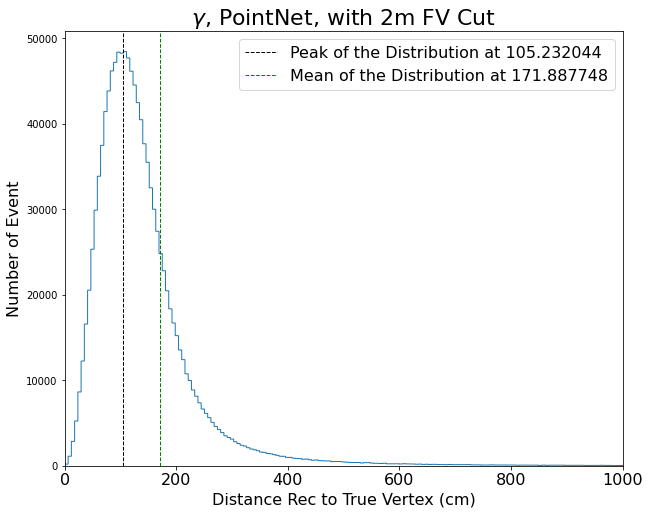

In [150]:
fig = plt.figure(figsize=(10,8))
bin_val, bin_edges, _ = plt.hist(error_3d, histtype='step', bins=1000)  # normalise use density=True
hist_peak = np.where(bin_val == max(bin_val))[0][0]
print(bin_edges[hist_peak])
plt.axvline(bin_edges[hist_peak], color='k', linestyle='dashed', linewidth=1,
            label='Peak of the Distribution at %f' %bin_edges[hist_peak])
plt.axvline(dist_mean, color='g', linestyle='dashed', linewidth=1,
            label='Mean of the Distribution at %f' %dist_mean)
plt.xlim([0,1000])
plt.title('$\gamma$, PointNet, with 2m FV Cut', fontsize=22)
plt.xlabel('Distance Rec to True Vertex (cm)', fontsize=16)
plt.ylabel('Number of Event', fontsize=16)
plt.rc('xtick', labelsize=16)
plt.legend(loc='upper right', fontsize=16)

In [10]:
print(regression_target[0][412760], regression_prediction[0][412760])

[ 8.49723816e-03 -2.89339038e+03  2.95150261e+01] [ -298.77062988 -3032.75854492   143.64529419]
